In [1]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import sys
import h5py

In [2]:
# 데이터를 담을 빈 리스트 생성
data_frames = []

print("데이터 로드 시작...")

for i in range(1, 11):
    # 1. 파일 경로 수정 (.mat 확장자 추가 및 변수명 오타 수정)
    address = f"ninapro_db5/s{i}/S{i}_E2_A1.mat"
    
    try:
        mat = sio.loadmat(address)
        
        # 2. 데이터 추출
        emg = mat['emg']
        # Ninapro 데이터셋 버전에 따라 키값이 대소문자가 다를 수 있어 안전하게 처리
        Restimulus = mat['restimulus'] if 'restimulus' in mat else mat['Restimulus']
        
        # 3. 데이터프레임 생성
        df_emg = pd.DataFrame(emg)
        df_Restimulus = pd.DataFrame(Restimulus)
        
        # 4. 옆으로 합치기 (axis=1)
        df = pd.concat([df_emg, df_Restimulus], axis=1)
        
        # 5. 컬럼명 지정
        df.columns = [f'emg{k}' for k in range(1, 17)] + ['Restimulus']
        
        # 6. 리스트에 추가 (속도 최적화)
        data_frames.append(df)
        print(f"Subject {i} Loaded.")
        
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"에러 발생 (Subject {i}): {e}")

# 7. 전체 데이터 하나로 병합 (루프 밖에서 한 번에 수행)
if data_frames:
    ninapro_df5 = pd.concat(data_frames, ignore_index=True)
    print("------------------------------")
    print("모든 데이터 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df5.shape}")
else:
    print("로드된 데이터가 없습니다.")
    
#ninapro2 데이터셋 불러오기
dfs = []
for i in range(1, 21):
    address = f"ninapro_db2/DB2_s{i}/S{i}_E1_A1.mat"
    try:
        mat = sio.loadmat(address)
        
        emg = mat['emg'] 
        restimulus = mat['restimulus']
        
        n_samples, n_channels = emg.shape
        target_channels = 16
        
        if n_channels < target_channels:
            pad_width = target_channels - n_channels
            zeros = np.zeros((n_samples, pad_width))
            emg_padded = np.hstack([emg, zeros])
        else:
            emg_padded = emg[:, :target_channels]
            

        col_names = [f'emg{k}' for k in range(1, target_channels + 1)]
        df_emg = pd.DataFrame(emg_padded, columns=col_names)
        df_restimulus = pd.DataFrame(restimulus, columns=['Restimulus'])
        
        df_concat = pd.concat([df_emg, df_restimulus], axis=1)
        
        dfs.append(df_concat)
    
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"Subject {i} 처리 중 에러 발생: {e}")

if dfs:
    ninapro_df2 = pd.concat(dfs, ignore_index=True)
    print("-" * 30)
    print("최종 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df2.shape}")
    print(f"컬럼 목록: {list(ninapro_df2.columns)}")
else:
    print("데이터가 로드되지 않았습니다.")

#nature df csv불러오는 코드
#nature_df = pd.read_csv('nature_df.csv')

데이터 로드 시작...
Subject 1 Loaded.
Subject 2 Loaded.
Subject 3 Loaded.
Subject 4 Loaded.
Subject 5 Loaded.
Subject 6 Loaded.
Subject 7 Loaded.
Subject 8 Loaded.
Subject 9 Loaded.
Subject 10 Loaded.
------------------------------
모든 데이터 병합 완료
전체 데이터 Shape: (2023639, 17)
------------------------------
최종 병합 완료
전체 데이터 Shape: (36027660, 17)
컬럼 목록: ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']


감지된 이벤트 개수: 2개
감지된 인덱스 위치: [23, 2027]


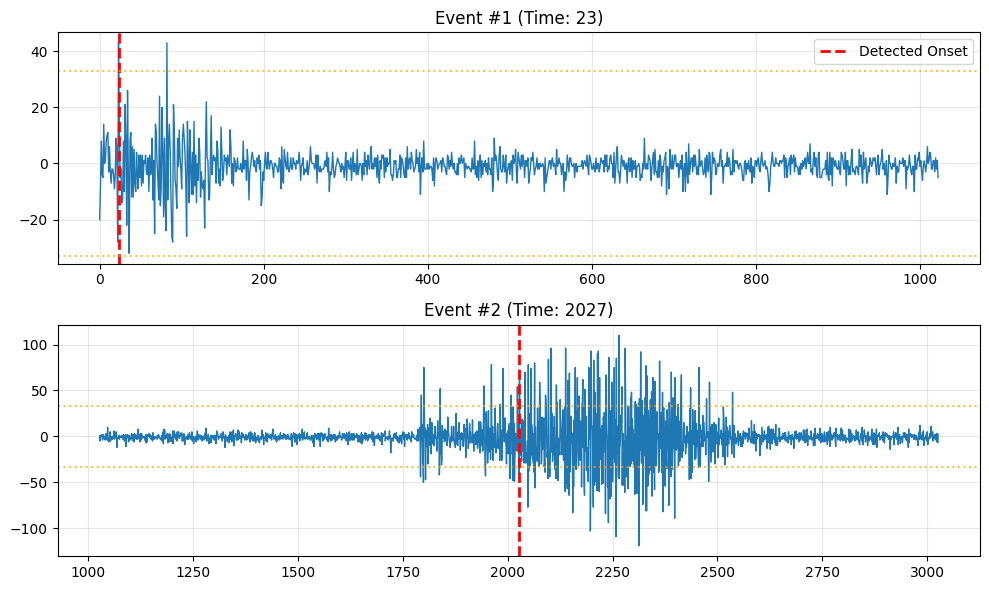

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. 설정 및 준비
# ---------------------------------------------------------
target_col = ninapro_df5.columns[0]  # 첫 번째 센서 컬럼 사용
signal = ninapro_df5[target_col].values # numpy 배열로 변환 (속도 향상)
times = ninapro_df5.index # 시간축

# (1) 임계값(Threshold) 자동 계산
# 처음 0.5초(약 1000개 샘플)를 휴식 구간으로 가정
rest_samples = 1000
threshold = np.mean(signal[:rest_samples]) + (6 * np.std(signal[:rest_samples])) # 표준편차의 6배

# (2) 이벤트 탐지 설정
events = []
min_distance = 2000  # [중요] 최소 간격: 2000샘플(1초). 이 시간 안에는 중복 탐지 안 함.
last_event_idx = -min_distance # 초기값 설정

# ---------------------------------------------------------
# 2. 순차적으로 5개의 이벤트 찾기
# ---------------------------------------------------------
for i in range(len(signal)):
    # 절대값이 임계값을 넘고, 마지막 감지로부터 1초 이상 지났으면 '새로운 동작'으로 인정
    if (np.abs(signal[i]) > threshold) and (i - last_event_idx > min_distance):
        events.append(i)
        last_event_idx = i
        
        if len(events) == 2: # 5개 찾으면 중단
            break

print(f"감지된 이벤트 개수: {len(events)}개")
print(f"감지된 인덱스 위치: {events}")

# ---------------------------------------------------------
# 3. 5개 구간 시각화 (Subplots)
# ---------------------------------------------------------
if len(events) == 0:
    print("임계값을 넘는 신호를 찾지 못했습니다. threshold 배수를 낮춰주세요.")
else:
    # 감지된 개수만큼만 subplot 생성 (최대 5개)
    fig, axes = plt.subplots(len(events), 1, figsize=(10, 3 * len(events)), sharex=False)
    if len(events) == 1: axes = [axes] # 1개일 경우 리스트로 변환

    window = 1000 # 감지 지점 앞뒤로 보여줄 범위 (약 0.25초)

    for i, ax in enumerate(axes):
        idx = events[i]
        t_event = times[idx]
        
        # 슬라이싱 범위 계산 (배열 범위 안 벗어나게)
        start = max(0, idx - window)
        end = min(len(signal), idx + window)
        
        # 데이터 자르기
        segment_t = times[start:end]
        segment_y = signal[start:end]
        
        # 그래프 그리기
        ax.plot(segment_t, segment_y, color='#1f77b4', lw=1)
        
        # 감지된 순간 표시 (빨간 점선)
        ax.axvline(x=t_event, color='red', linestyle='--', lw=2, label='Detected Onset')
        
        # 임계값 표시 (주황 점선)
        ax.axhline(y=threshold, color='orange', linestyle=':', alpha=0.7)
        ax.axhline(y=-threshold, color='orange', linestyle=':', alpha=0.7)
        
        ax.set_title(f'Event #{i+1} (Time: {t_event})')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [4]:
import pandas as pd
import numpy as np
from scipy import signal

# 1. 그룹 ID 생성
group_id = (ninapro_df5['Restimulus'] != ninapro_df5['Restimulus'].shift()).cumsum()

# 처리된 조각들을 담을 임시 리스트
processed_segments = []

# 업샘플링 설정
target_fs = 1000
original_fs = 200
scale_factor = int(target_fs / original_fs)  # 5배

print(f"=== 구간별 업샘플링 및 1000단위 절삭 시작 ===")

for gid, segment in ninapro_df5.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    original_len = len(segment)
    
    # 1. 업샘플링 후 전체 길이 계산
    full_upsampled_len = original_len * scale_factor 
    
    # 2. 1000 단위로 자를 길이 계산 (버림)
    cutoff_len = (full_upsampled_len // 1000) * 1000
    
    # 길이가 1000 미만이면 스킵
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Upsampled Len={full_upsampled_len} (Too Short)")
        continue

    # 3. 리샘플링 (전체 길이로 먼저 늘림)
    resampled_data = signal.resample(segment, full_upsampled_len)
    
    # 4. DataFrame 변환
    new_segment = pd.DataFrame(resampled_data, columns=segment.columns)
    
    # 5. 1000 단위까지만 슬라이싱 (뒷부분 버림)
    new_segment = new_segment.iloc[:cutoff_len]
    
    # 라벨 보정 (리샘플링으로 인해 소수점이 된 값을 정수 라벨로 복구)
    new_segment['Restimulus'] = int(rest_value)

    # ---------------------------------------------------------
    # [요청하신 기능] 로그 출력 (Len: 업샘플링된 길이 -> 저장된 길이)
    # ---------------------------------------------------------
    counts_info = new_segment['Restimulus'].value_counts().to_dict()
    
    print(f"Group {gid}: Label={rest_value}, Len={full_upsampled_len} -> {len(new_segment)} (Saved) | Counts: {counts_info}")

    # 리스트에 추가
    processed_segments.append(new_segment)

# -------------------------------------------------------------
# 리스트를 합쳐서 'ninapro_df5'에 덮어쓰기
# -------------------------------------------------------------
if len(processed_segments) > 0:
    ninapro_df5 = pd.concat(processed_segments).reset_index(drop=True)
    print("\n=== 최종 병합 완료 ===")
    print(f"결과가 'ninapro_df5'에 저장되었습니다.")
    print(f"최종 데이터 크기: {ninapro_df5.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== 구간별 업샘플링 및 1000단위 절삭 시작 ===
Group 1: Label=0, Len=8900 -> 8000 (Saved) | Counts: {0: 8000}
Group 2: Label=1, Len=4640 -> 4000 (Saved) | Counts: {1: 4000}
Group 3: Label=0, Len=5375 -> 5000 (Saved) | Counts: {0: 5000}
Group 4: Label=1, Len=3260 -> 3000 (Saved) | Counts: {1: 3000}
Group 5: Label=0, Len=5225 -> 5000 (Saved) | Counts: {0: 5000}
Group 6: Label=1, Len=4365 -> 4000 (Saved) | Counts: {1: 4000}
Group 7: Label=0, Len=4445 -> 4000 (Saved) | Counts: {0: 4000}
Group 8: Label=1, Len=4890 -> 4000 (Saved) | Counts: {1: 4000}
Group 9: Label=0, Len=4280 -> 4000 (Saved) | Counts: {0: 4000}
Group 10: Label=1, Len=4755 -> 4000 (Saved) | Counts: {1: 4000}
Group 11: Label=0, Len=4475 -> 4000 (Saved) | Counts: {0: 4000}
Group 12: Label=1, Len=4815 -> 4000 (Saved) | Counts: {1: 4000}
Group 13: Label=0, Len=4250 -> 4000 (Saved) | Counts: {0: 4000}
Group 14: Label=2, Len=3550 -> 3000 (Saved) | Counts: {2: 3000}
Group 15: Label=0, Len=5725 -> 5000 (Saved) | Counts: {0: 5000}
Group 16: Label=2

In [5]:
import pandas as pd

# 1. 그룹 ID 생성
group_id = (ninapro_df2['Restimulus'] != ninapro_df2['Restimulus'].shift()).cumsum()

df2 = []  # 잘린 df들을 저장할 리스트

print("=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===")

# 2. 그룹별 순회
for gid, segment in ninapro_df2.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    
    # ---------------------------------------------------------
    # [추가된 기능] 2000Hz -> 1000Hz 다운샘플링
    # ---------------------------------------------------------
    # 2개 중 1개만 가져옵니다 (데이터를 절반으로 줄임)
    segment = segment.iloc[::2]

    # 다운샘플링 후의 길이 계산
    current_len = len(segment)

    # ---------------------------------------------------------
    # 1000 단위로 길이 계산 (나머지 버림)
    # ---------------------------------------------------------
    cutoff_len = (current_len // 1000) * 1000

    # 1000개 미만이면 저장하지 않고 건너뜀
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Length={current_len} (Too Short)")
        continue
    
    # 계산된 길이만큼만 자르기
    truncated_segment = segment.iloc[:cutoff_len].reset_index(drop=True)
    
    # ---------------------------------------------------------
    # [요청하신 기능] value_counts() 계산
    # ---------------------------------------------------------
    # 결과가 Series 형태이므로 보기 좋게 to_dict()로 변환하여 출력
    counts_info = truncated_segment['Restimulus'].value_counts().to_dict()

    print(f"Group {gid}: Label={rest_value}, Len={current_len} -> {len(truncated_segment)} (Saved) | Counts: {counts_info}")
    
    # 리스트에 추가
    df2.append(truncated_segment)

# 3. 최종 결과를 'ninapro_df2'에 덮어쓰기
if len(df2) > 0:
    ninapro_df2 = pd.concat(df2).reset_index(drop=True)
    print("\n=== 처리 완료 ===")
    print(f"최종 'ninapro_df2' 데이터 크기: {ninapro_df2.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===
Group 1: Label=0, Len=5413 -> 5000 (Saved) | Counts: {0: 5000}
Group 2: Label=1, Len=7111 -> 7000 (Saved) | Counts: {1: 7000}
Group 3: Label=0, Len=2410 -> 2000 (Saved) | Counts: {0: 2000}
Group 4: Label=1, Len=6462 -> 6000 (Saved) | Counts: {1: 6000}
Group 5: Label=0, Len=2327 -> 2000 (Saved) | Counts: {0: 2000}
Group 6: Label=1, Len=6426 -> 6000 (Saved) | Counts: {1: 6000}
Group 7: Label=0, Len=2325 -> 2000 (Saved) | Counts: {0: 2000}
Group 8: Label=1, Len=6483 -> 6000 (Saved) | Counts: {1: 6000}
Group 9: Label=0, Len=2268 -> 2000 (Saved) | Counts: {0: 2000}
Group 10: Label=1, Len=6455 -> 6000 (Saved) | Counts: {1: 6000}
Group 11: Label=0, Len=2296 -> 2000 (Saved) | Counts: {0: 2000}
Group 12: Label=1, Len=6415 -> 6000 (Saved) | Counts: {1: 6000}
Group 13: Label=0, Len=2374 -> 2000 (Saved) | Counts: {0: 2000}
Group 14: Label=2, Len=6502 -> 6000 (Saved) | Counts: {2: 6000}
Group 15: Label=0, Len=2992 -> 2000 (Saved) | Counts: {0: 2000}

총 18개의 클래스를 발견했습니다: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
------------------------------------------------------------
Label 0 정보:
  - DB2: 7831000 samples (Total 2041 Groups merged)
  - DB5: 5887000 samples (Total 1021 Groups merged)
  >>> 그래프 생성 중...


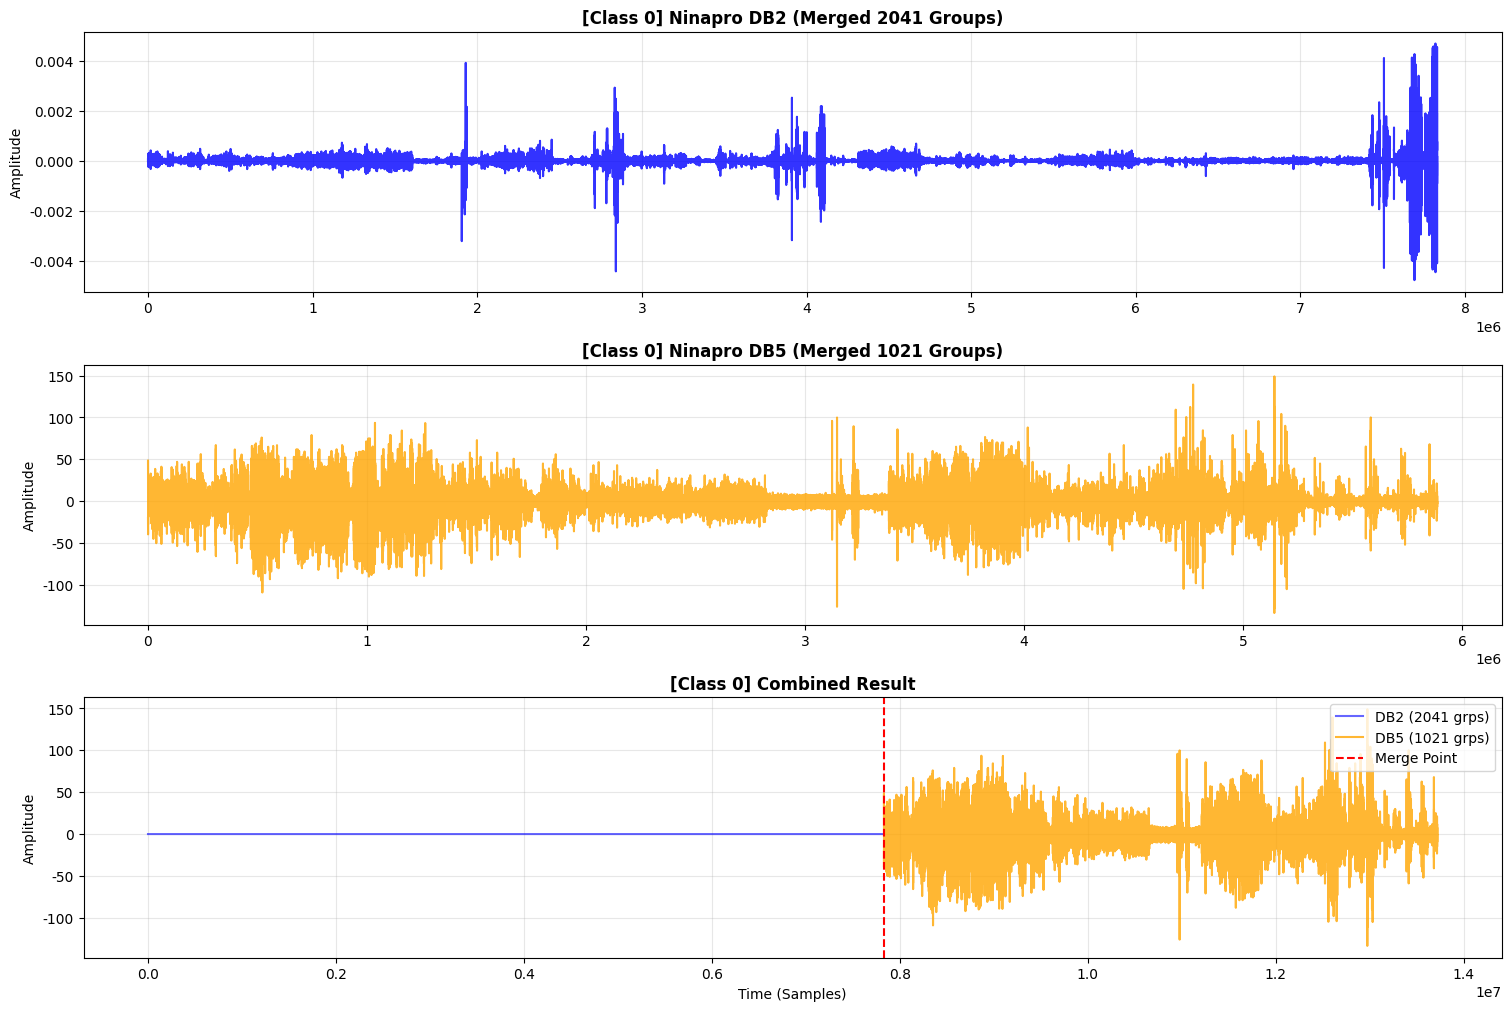

------------------------------------------------------------
Label 1 정보:
  - DB2: 673000 samples (Total 120 Groups merged)
  - DB5: 220000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


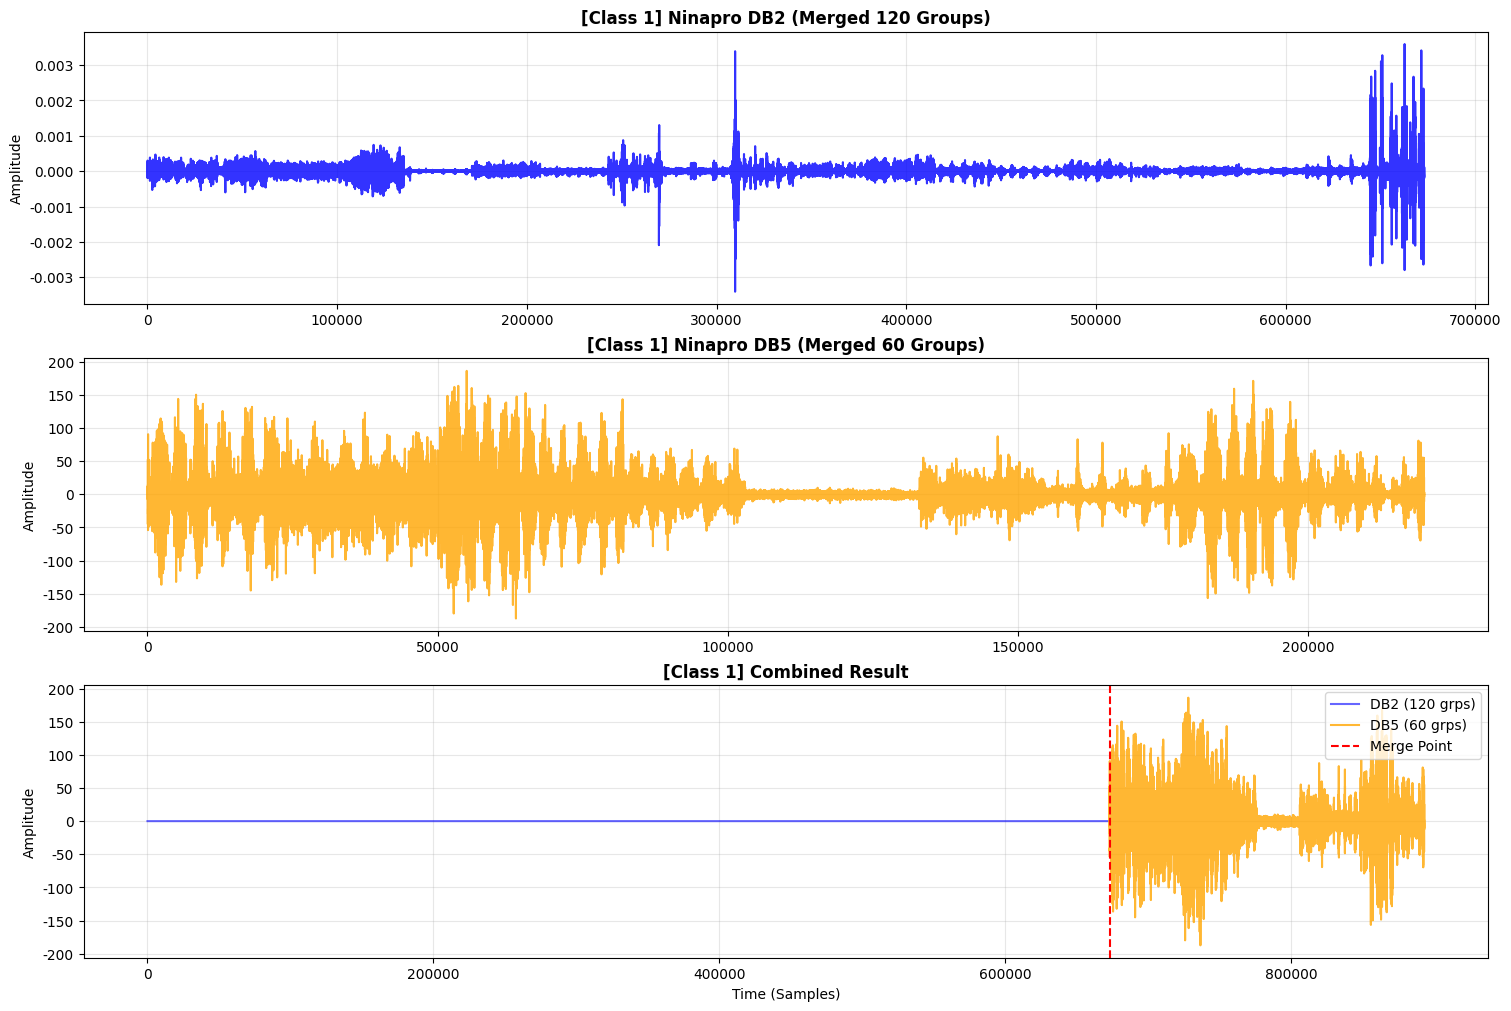

------------------------------------------------------------
Label 2 정보:
  - DB2: 583000 samples (Total 120 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


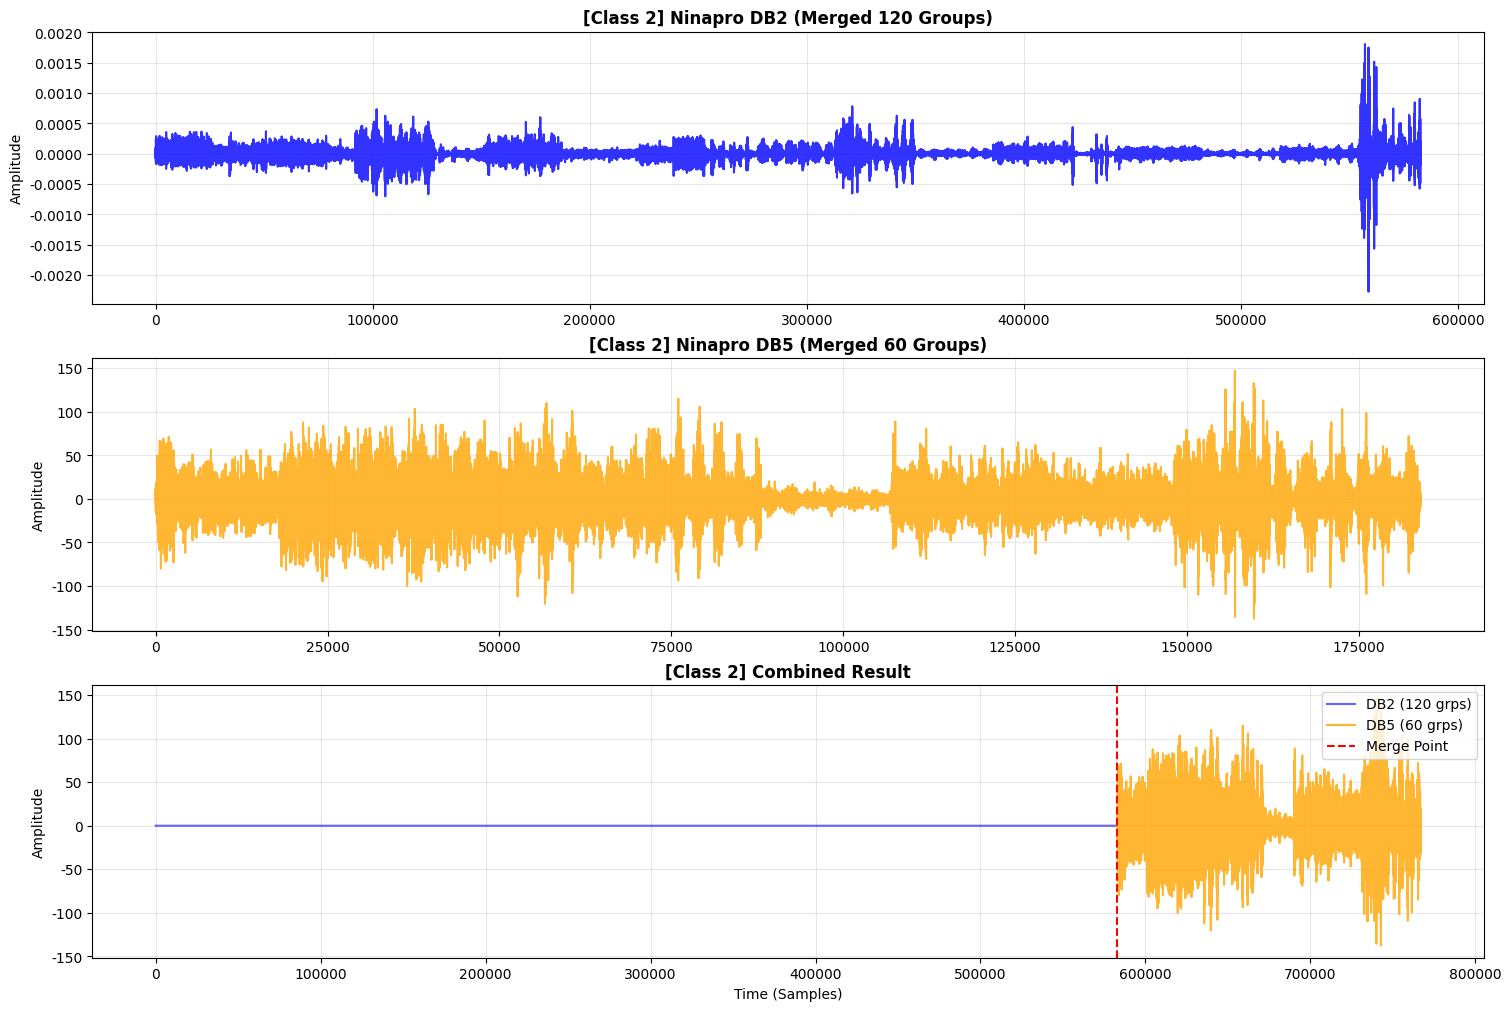

------------------------------------------------------------
Label 3 정보:
  - DB2: 507000 samples (Total 120 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


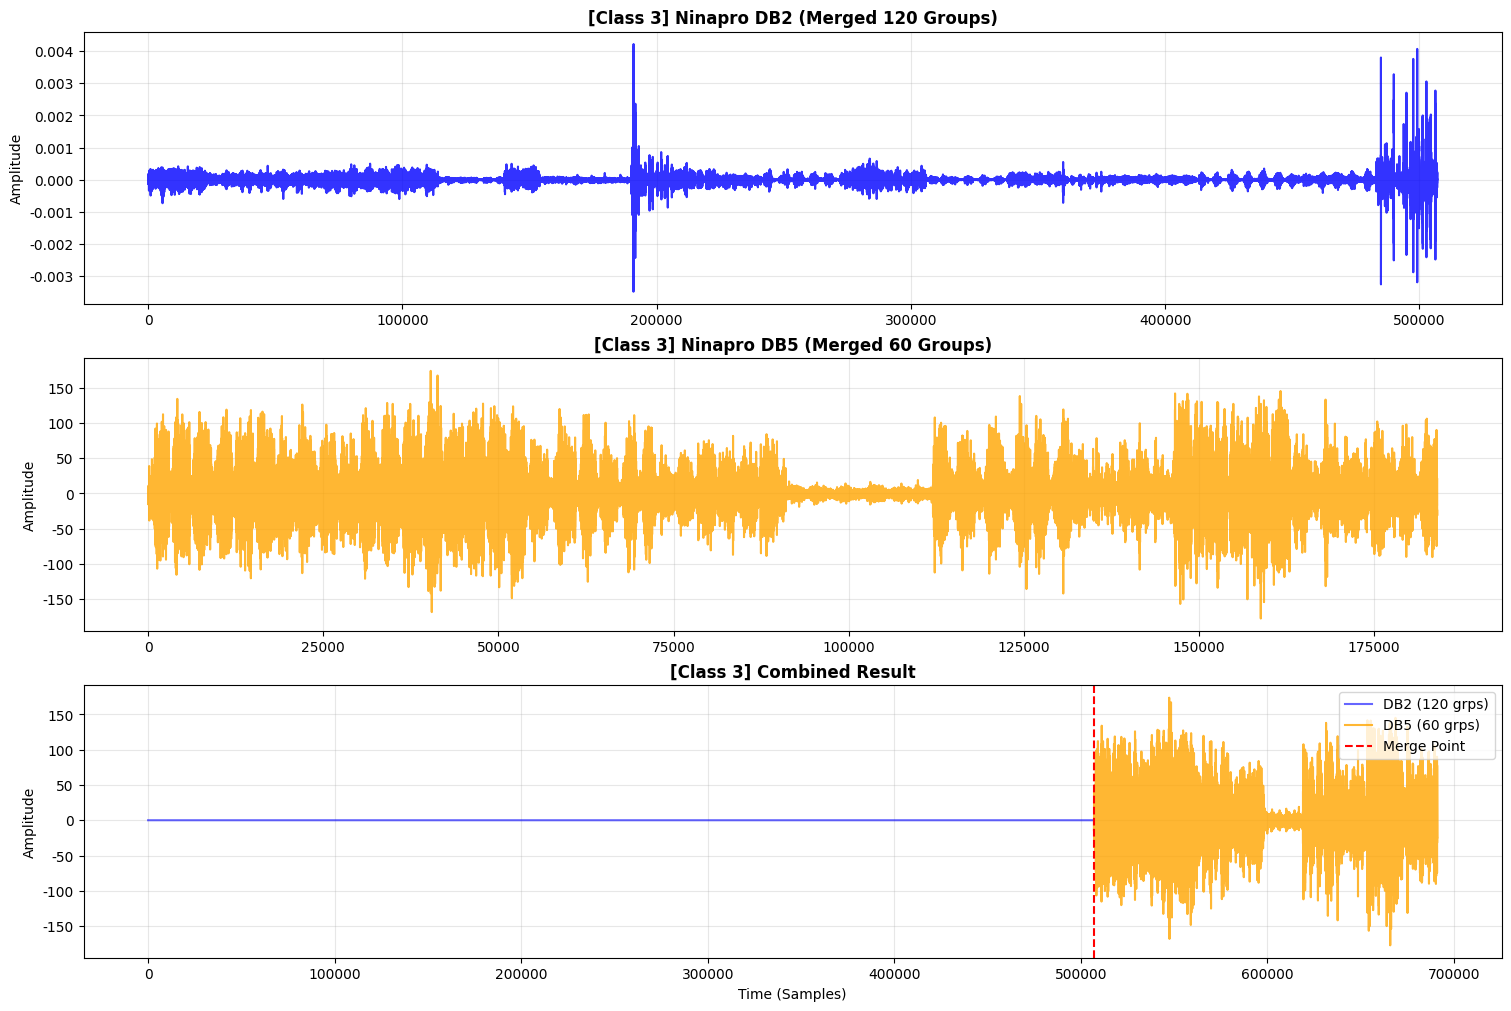

------------------------------------------------------------
Label 4 정보:
  - DB2: 483000 samples (Total 120 Groups merged)
  - DB5: 187000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


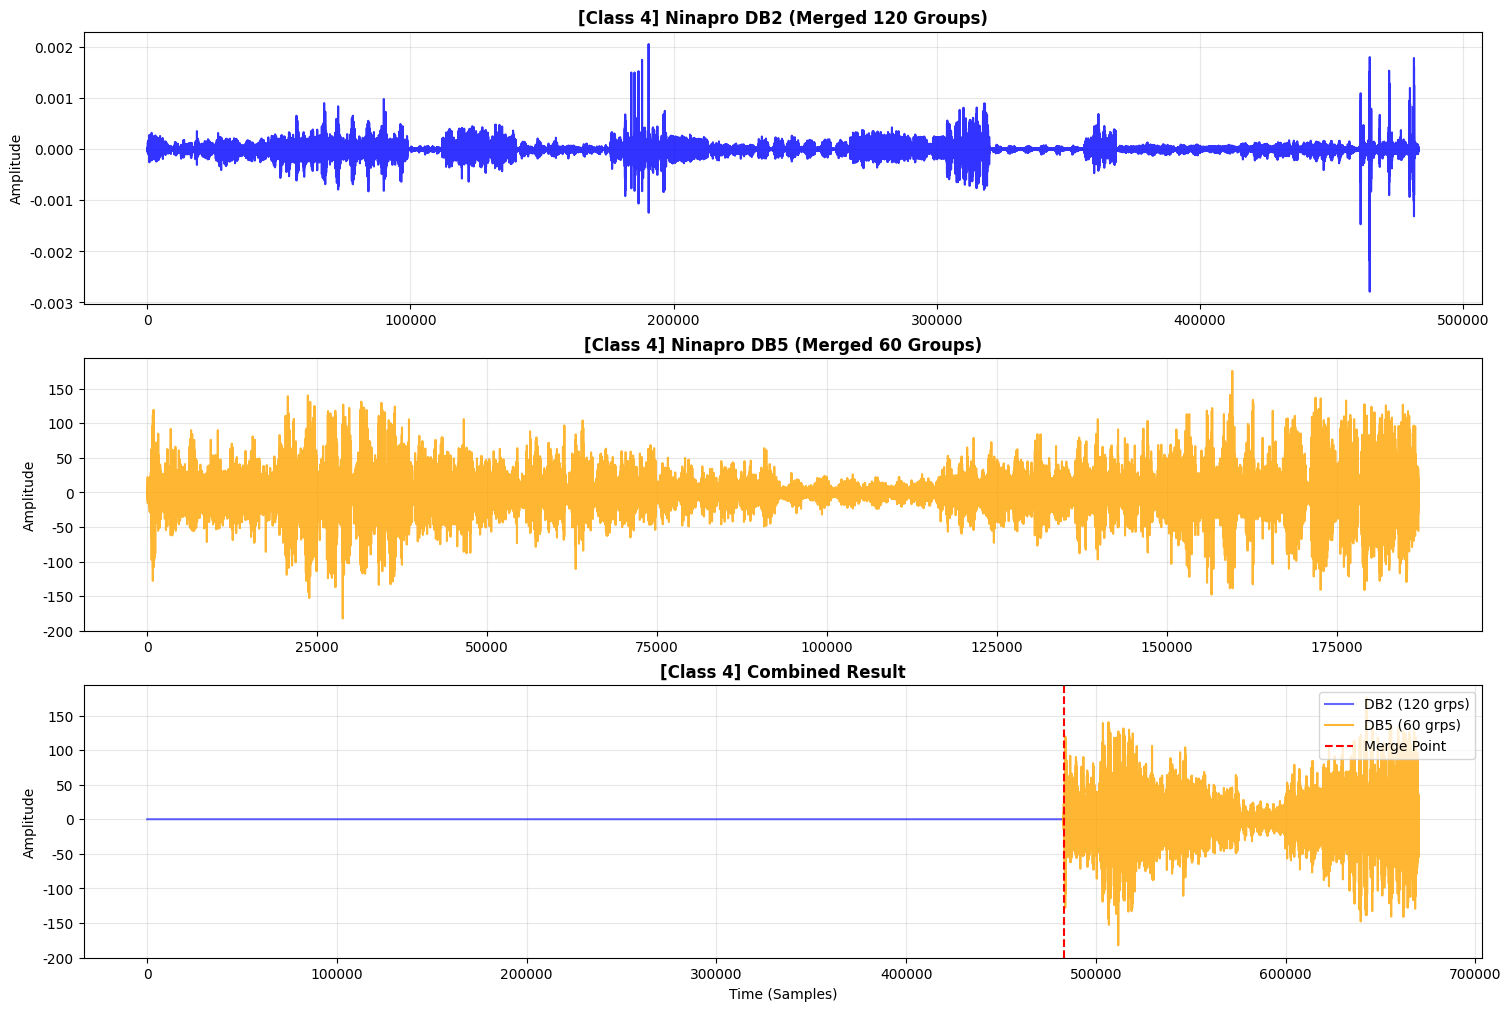

------------------------------------------------------------
Label 5 정보:
  - DB2: 439000 samples (Total 120 Groups merged)
  - DB5: 161000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


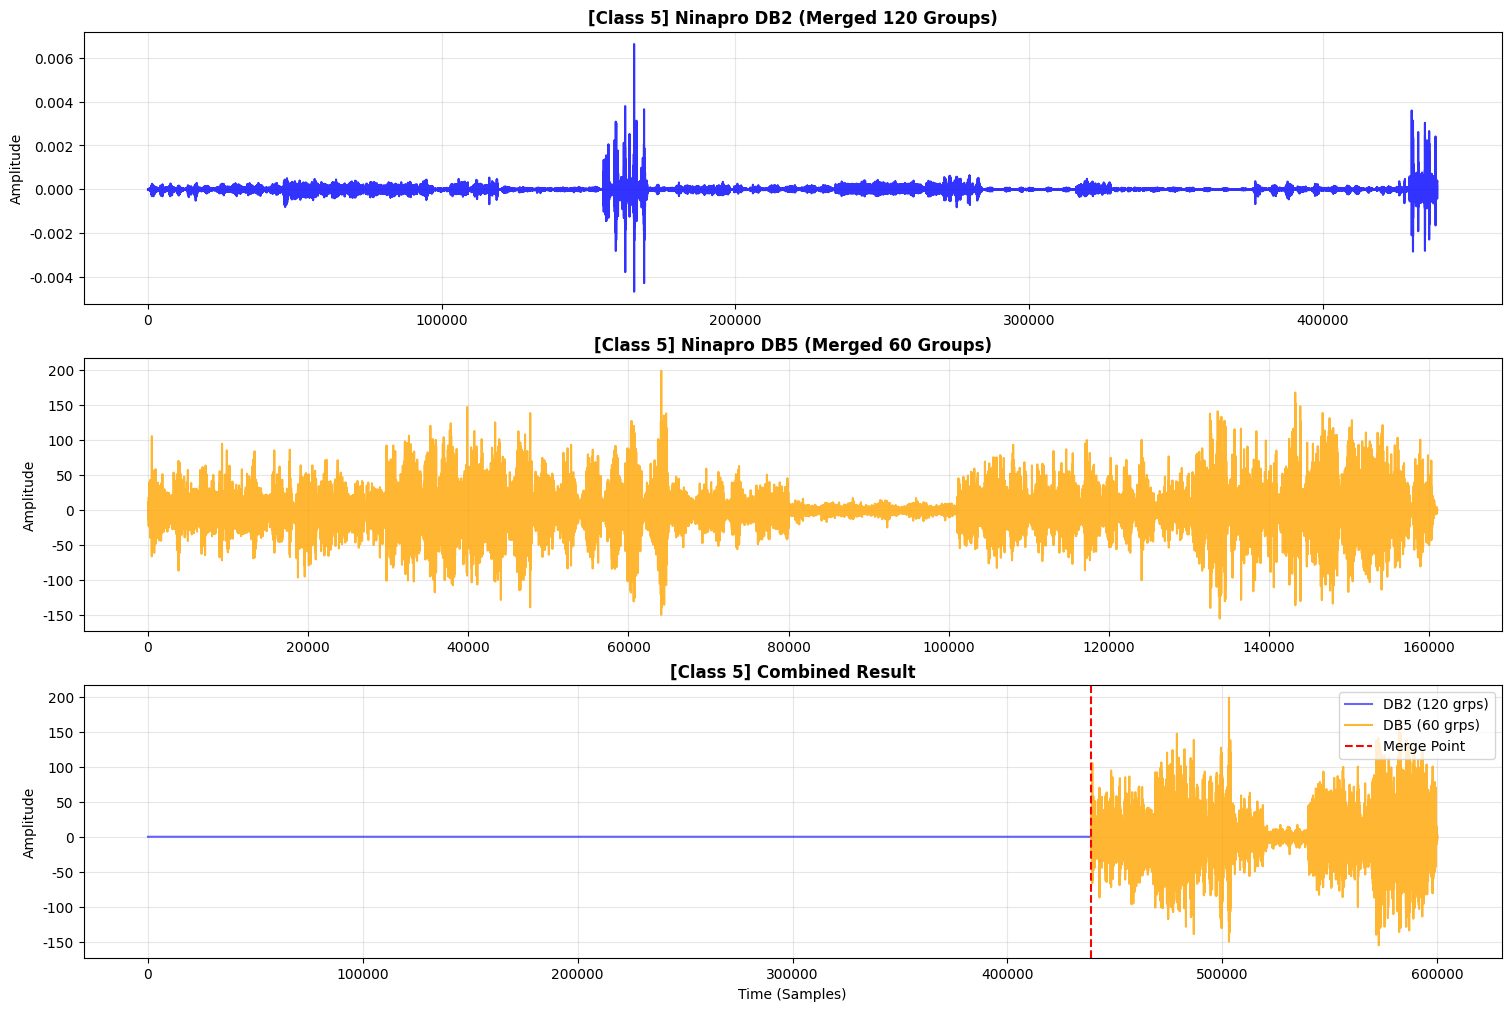

------------------------------------------------------------
Label 6 정보:
  - DB2: 401000 samples (Total 120 Groups merged)
  - DB5: 167000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


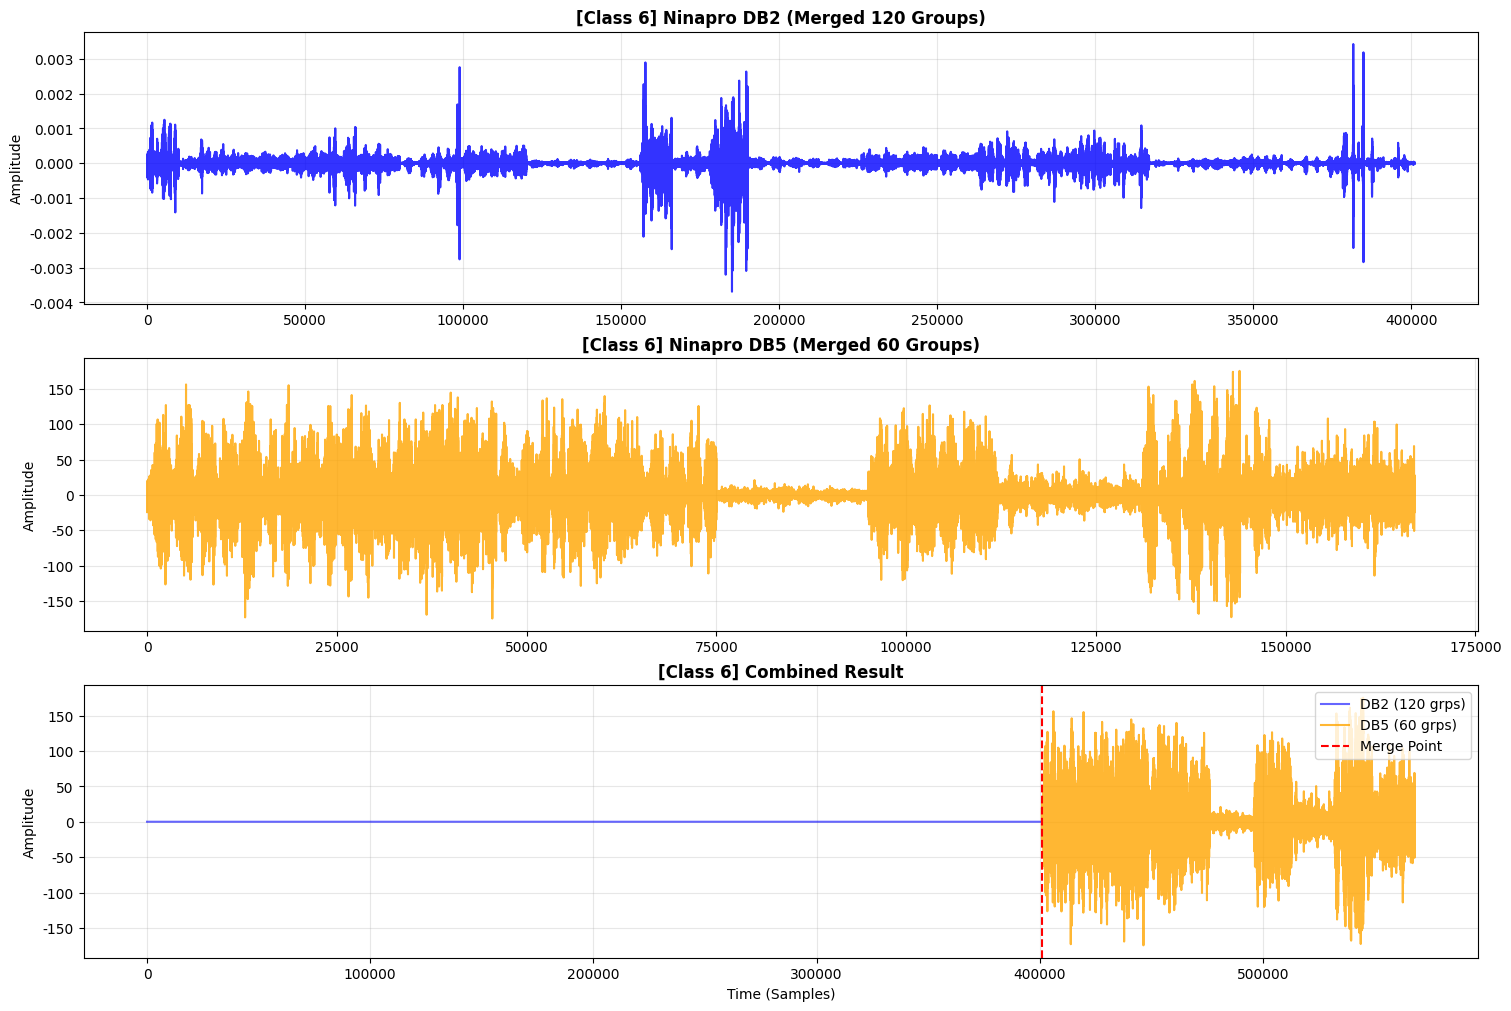

------------------------------------------------------------
Label 7 정보:
  - DB2: 636000 samples (Total 120 Groups merged)
  - DB5: 192000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


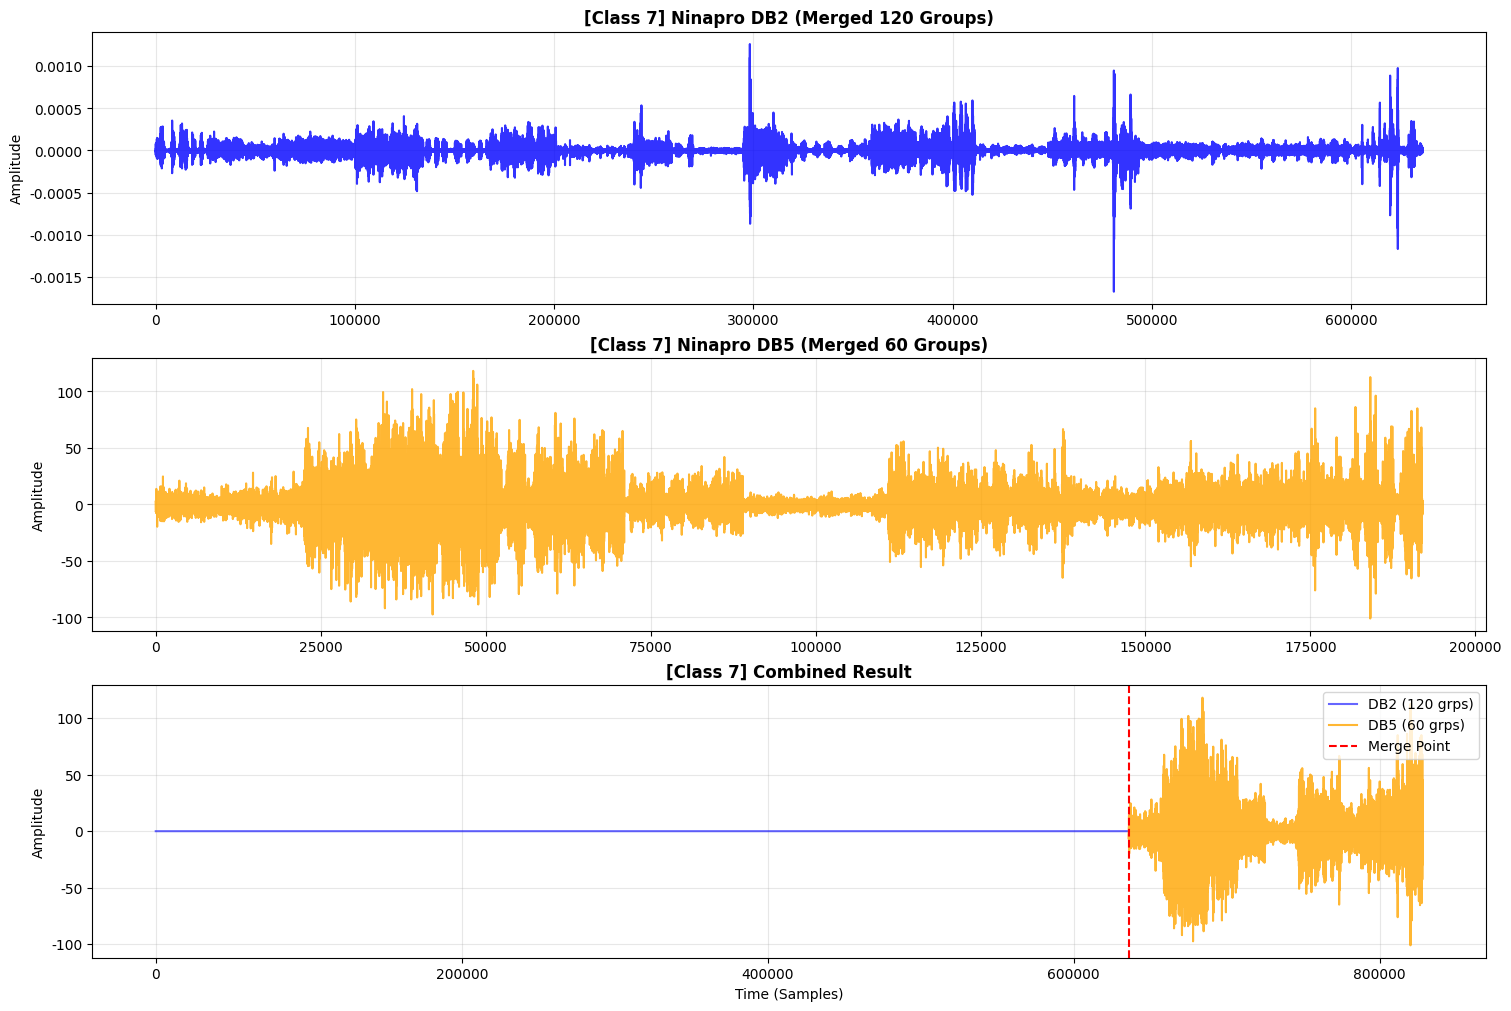

------------------------------------------------------------
Label 8 정보:
  - DB2: 491000 samples (Total 120 Groups merged)
  - DB5: 182000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


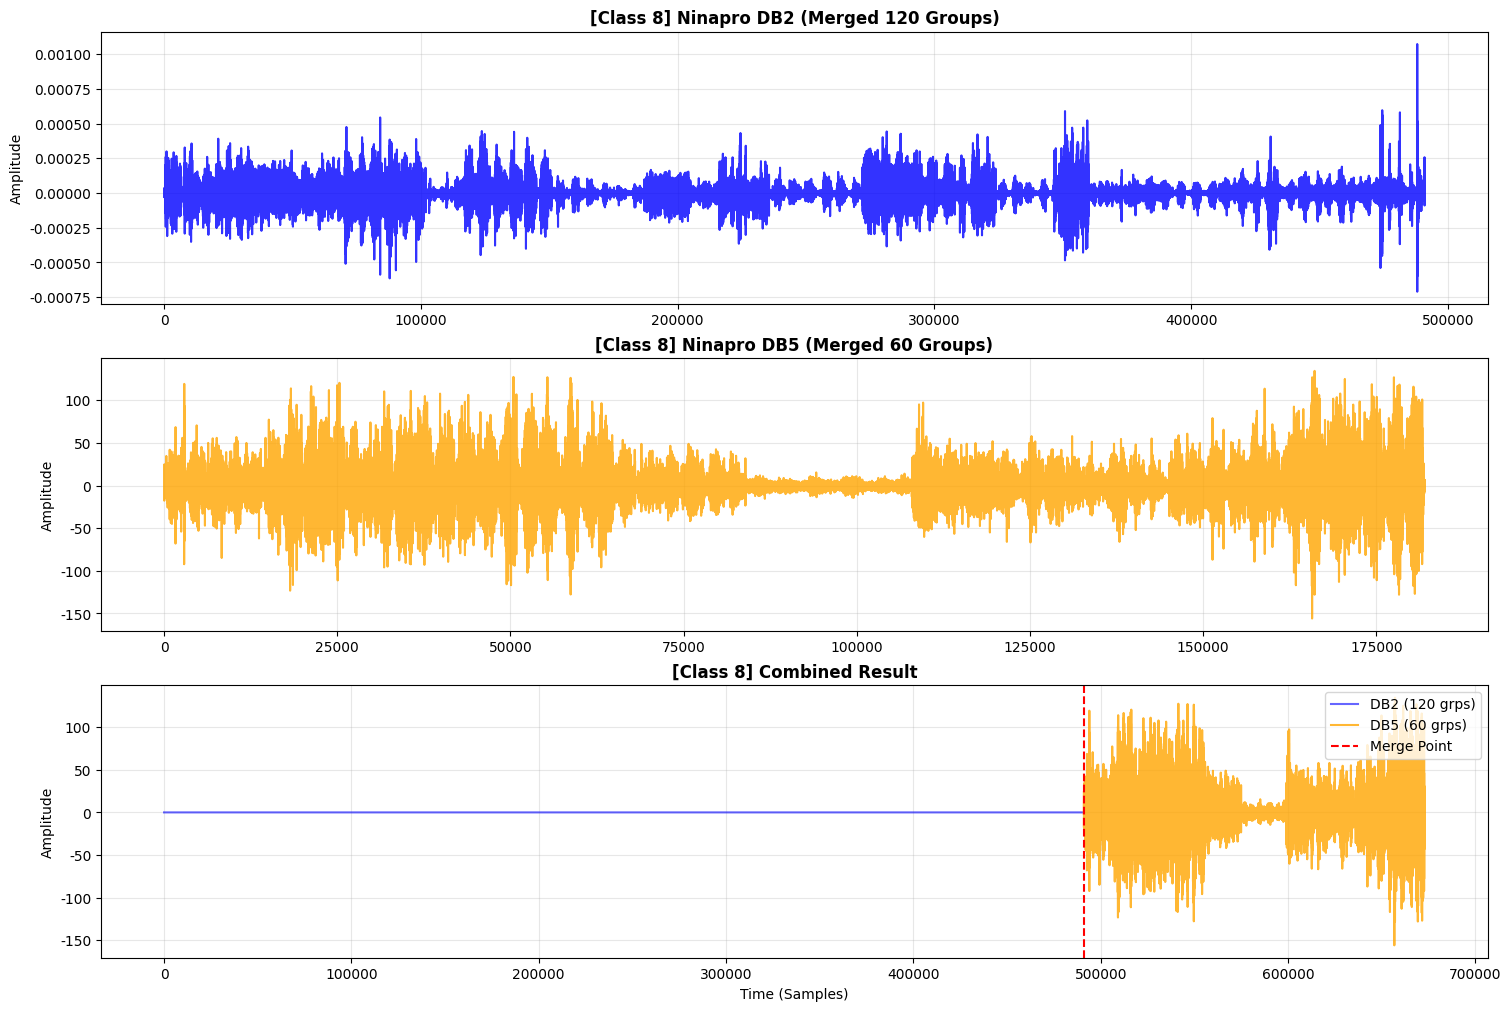

------------------------------------------------------------
Label 9 정보:
  - DB2: 532000 samples (Total 120 Groups merged)
  - DB5: 199000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


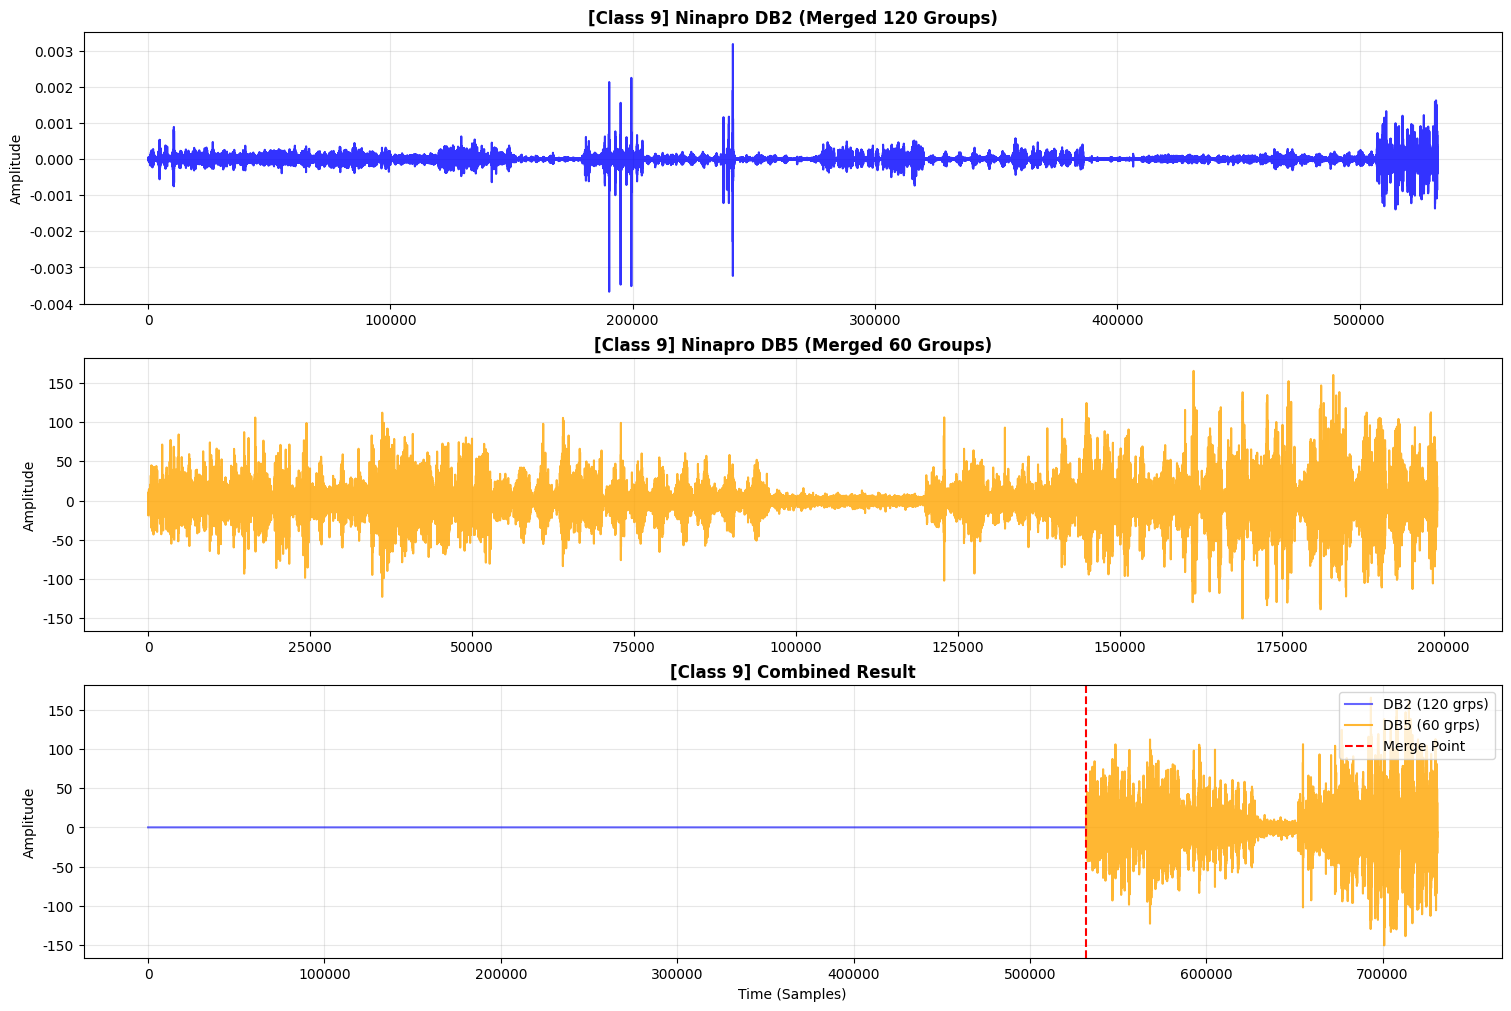

------------------------------------------------------------
Label 10 정보:
  - DB2: 516000 samples (Total 120 Groups merged)
  - DB5: 187000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


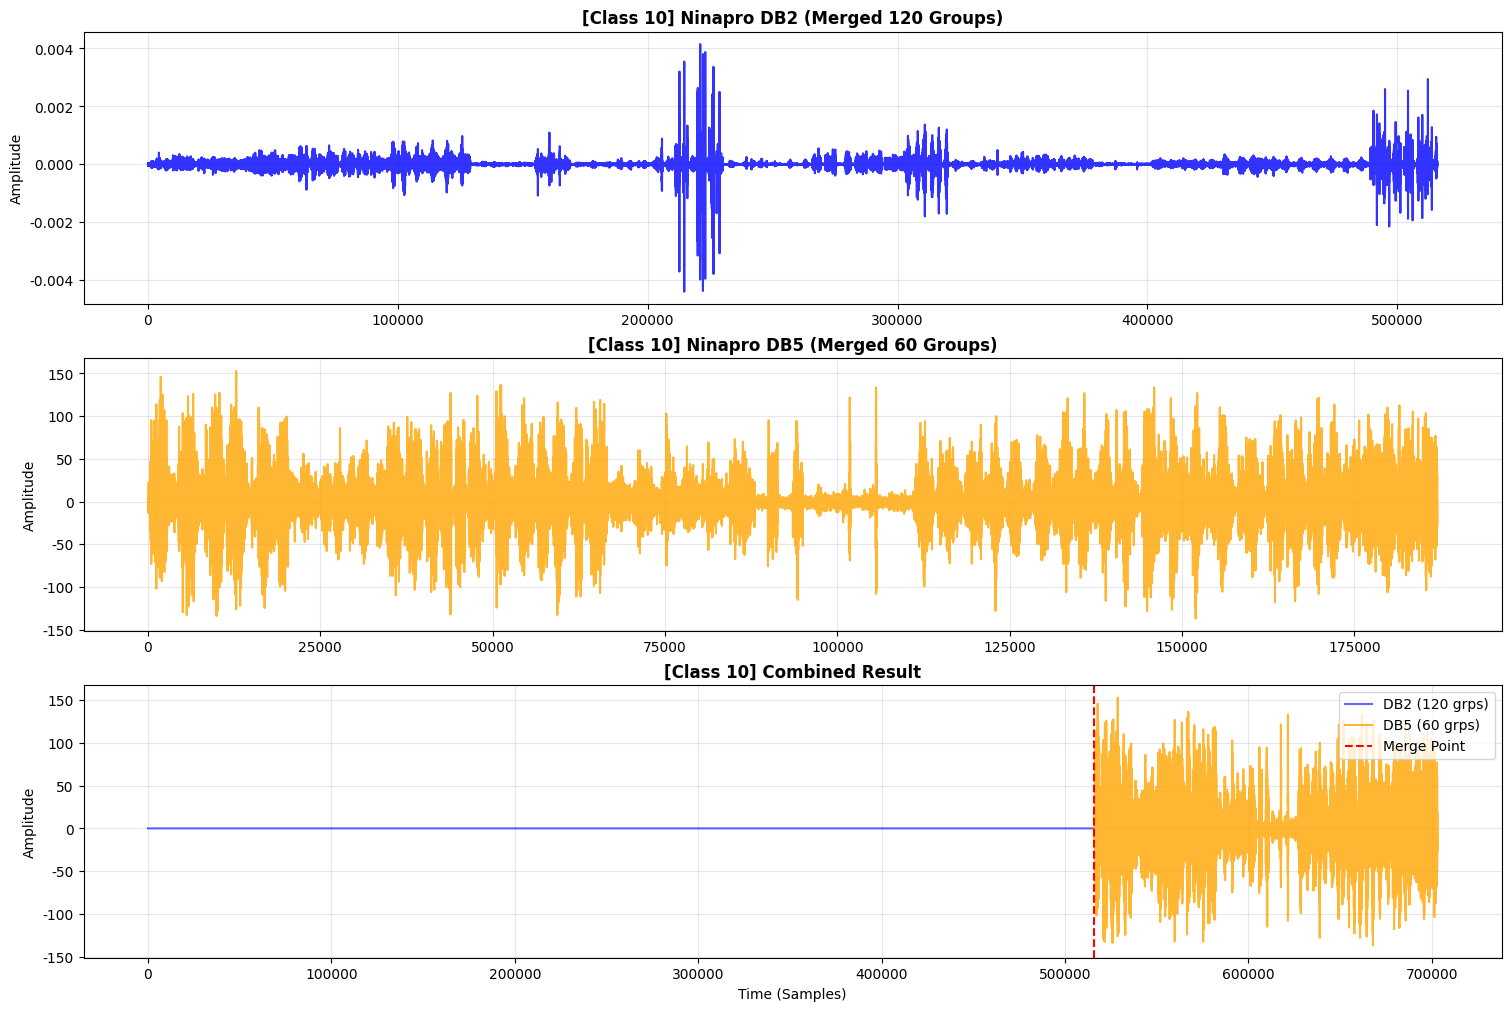

------------------------------------------------------------
Label 11 정보:
  - DB2: 549000 samples (Total 120 Groups merged)
  - DB5: 218000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


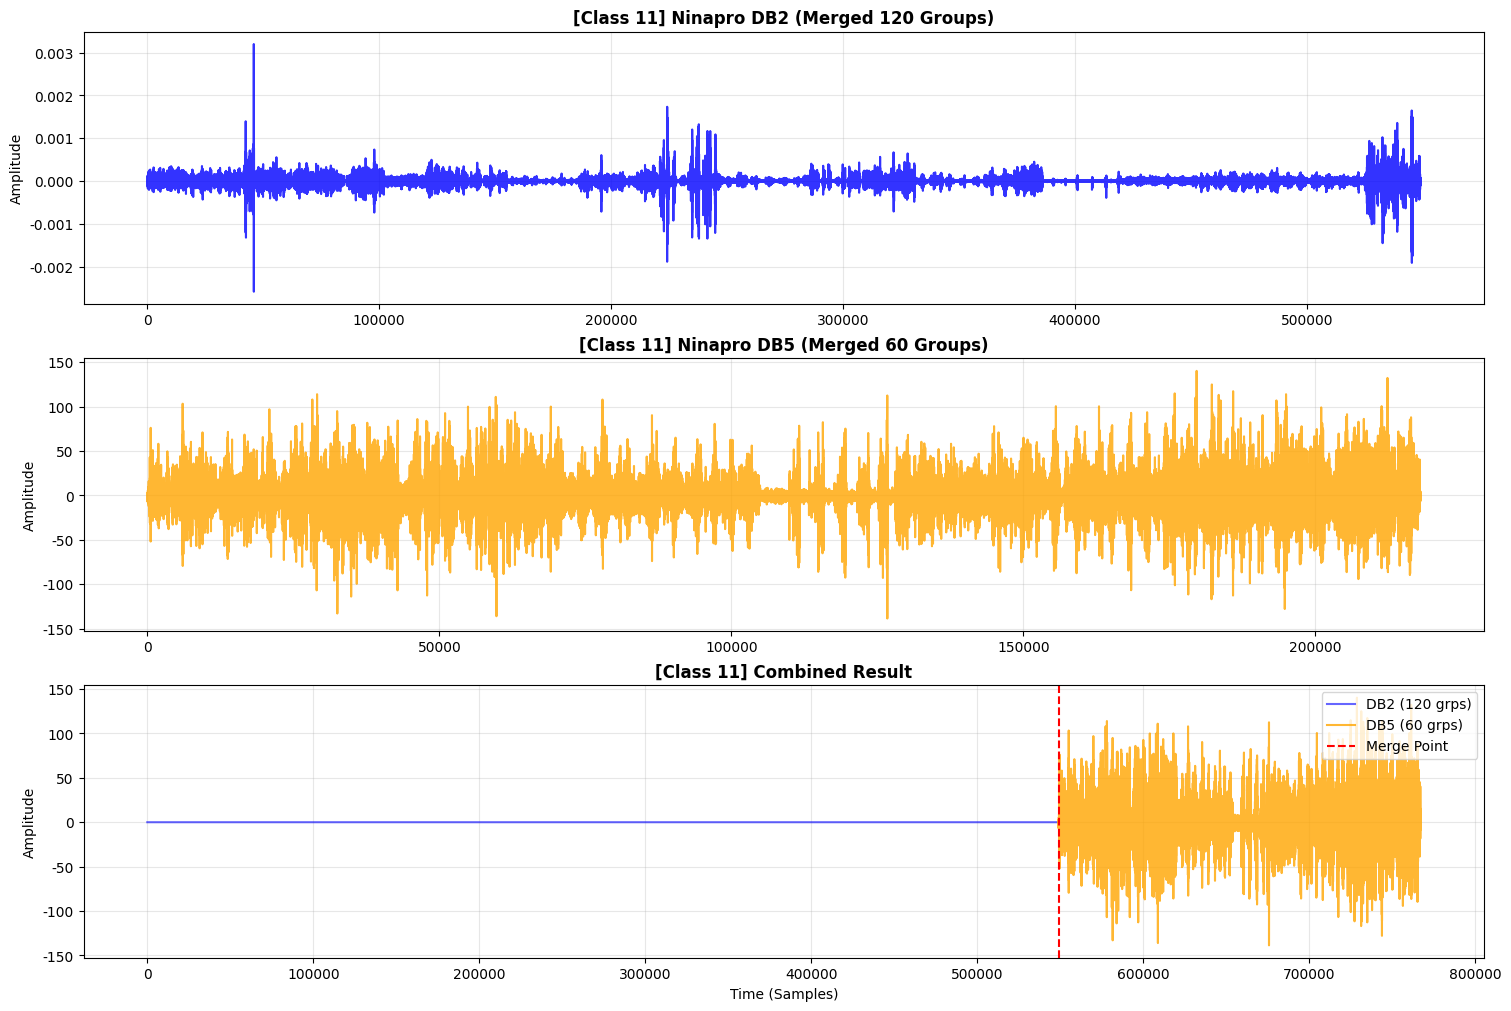

------------------------------------------------------------
Label 12 정보:
  - DB2: 446000 samples (Total 120 Groups merged)
  - DB5: 195000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


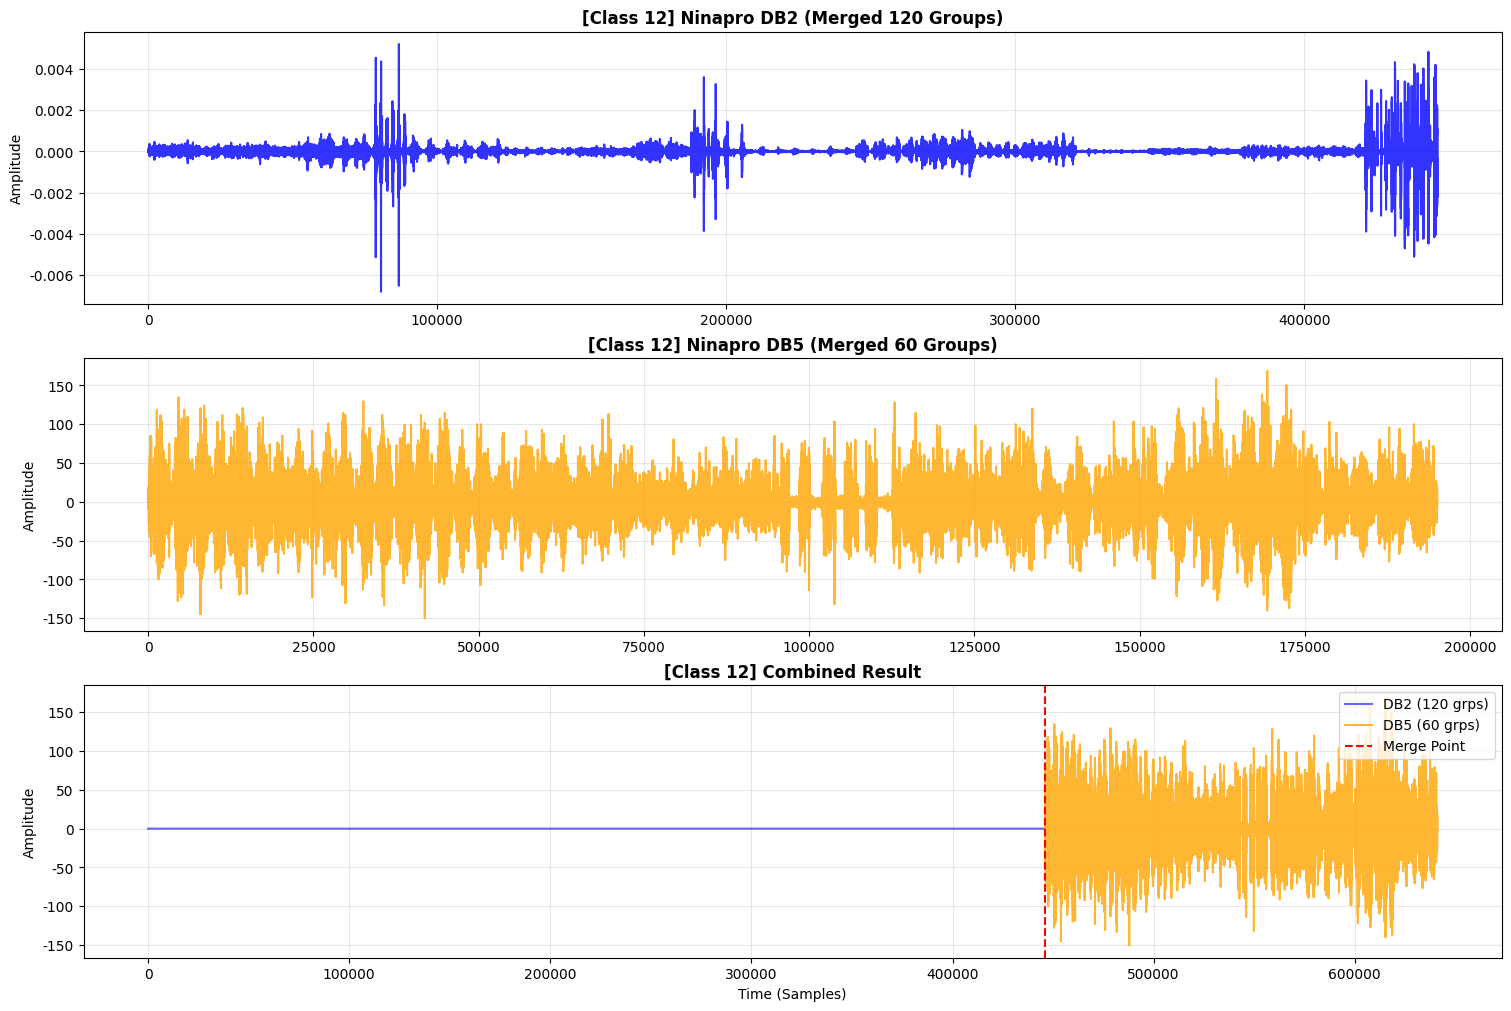

------------------------------------------------------------
Label 13 정보:
  - DB2: 352000 samples (Total 120 Groups merged)
  - DB5: 194000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


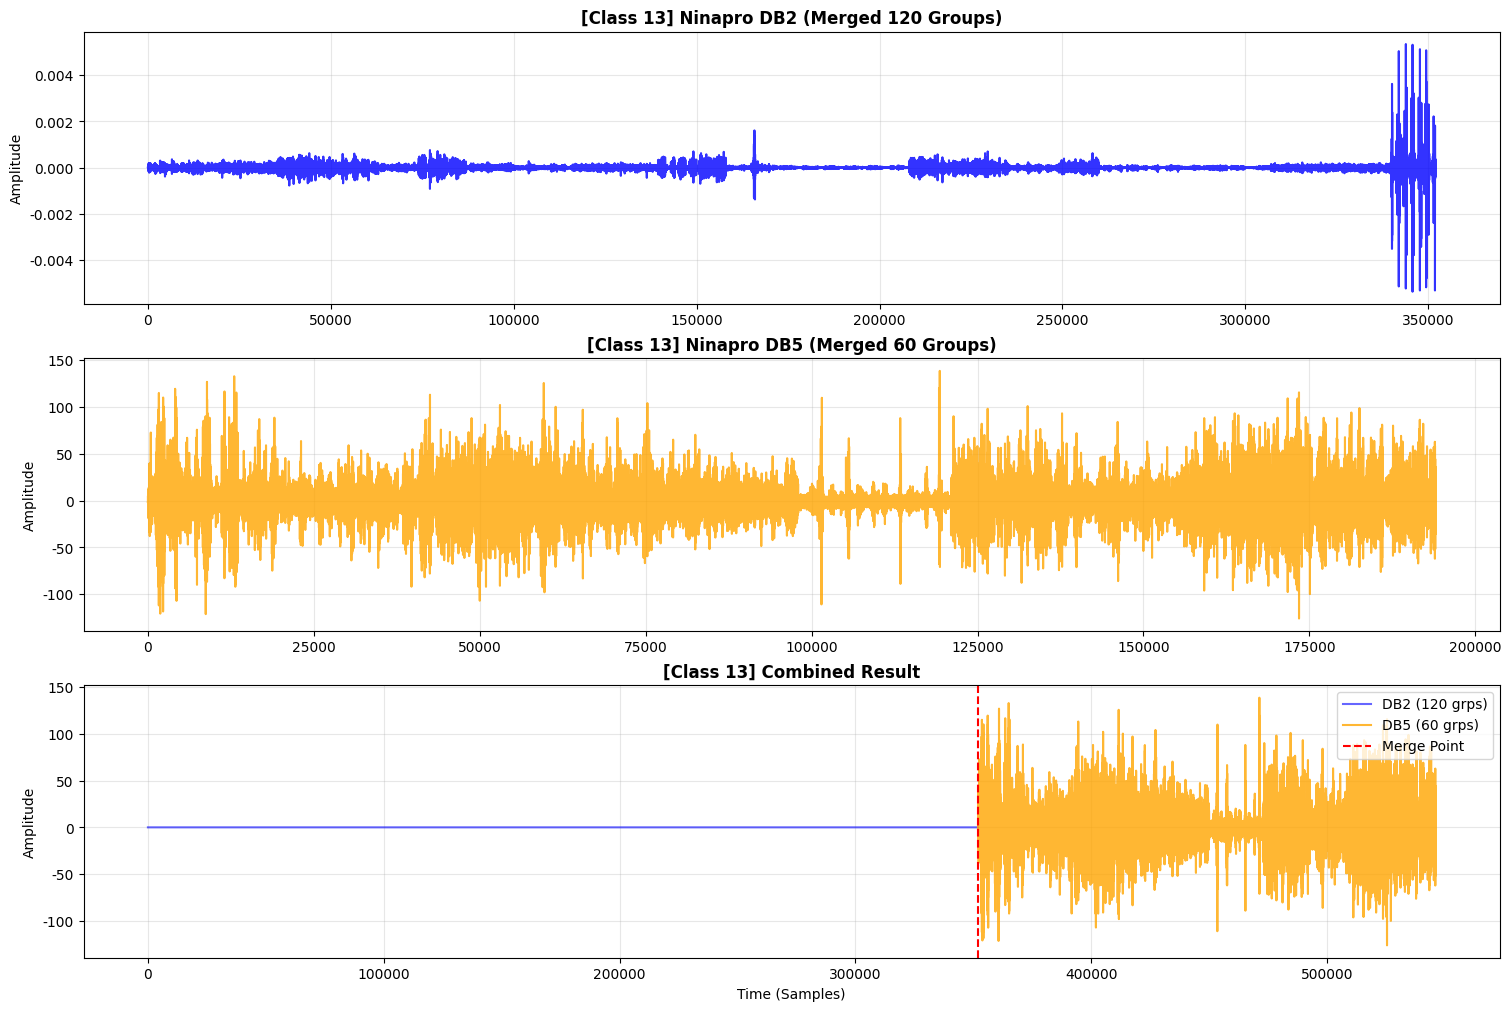

------------------------------------------------------------
Label 14 정보:
  - DB2: 354000 samples (Total 120 Groups merged)
  - DB5: 168000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


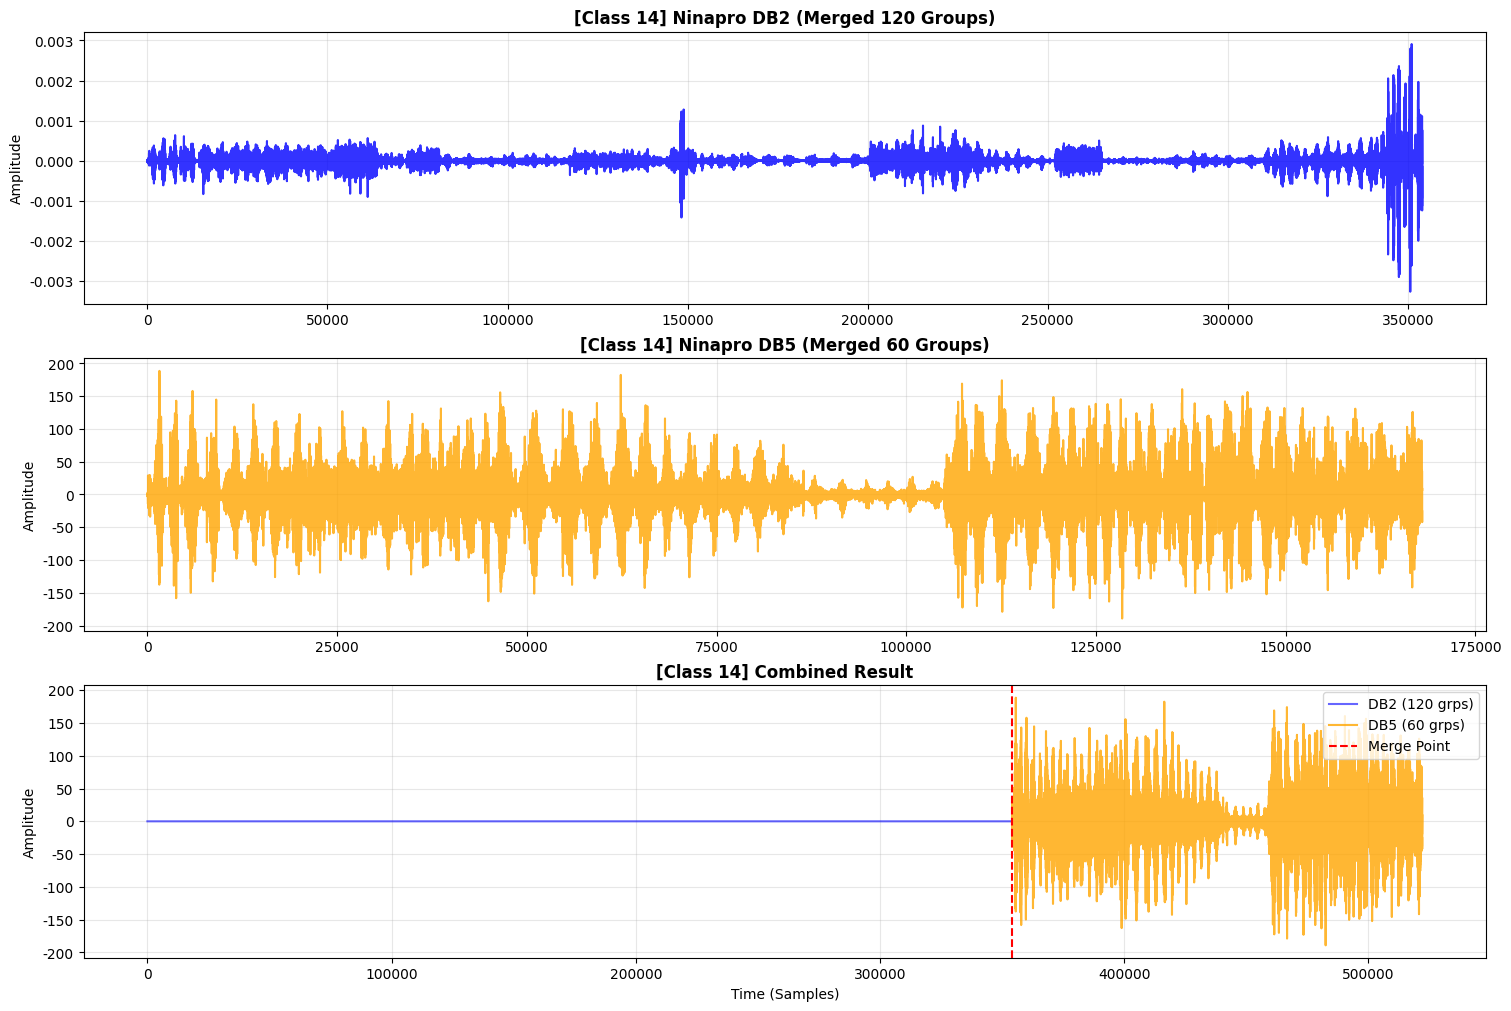

------------------------------------------------------------
Label 15 정보:
  - DB2: 458000 samples (Total 120 Groups merged)
  - DB5: 151000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


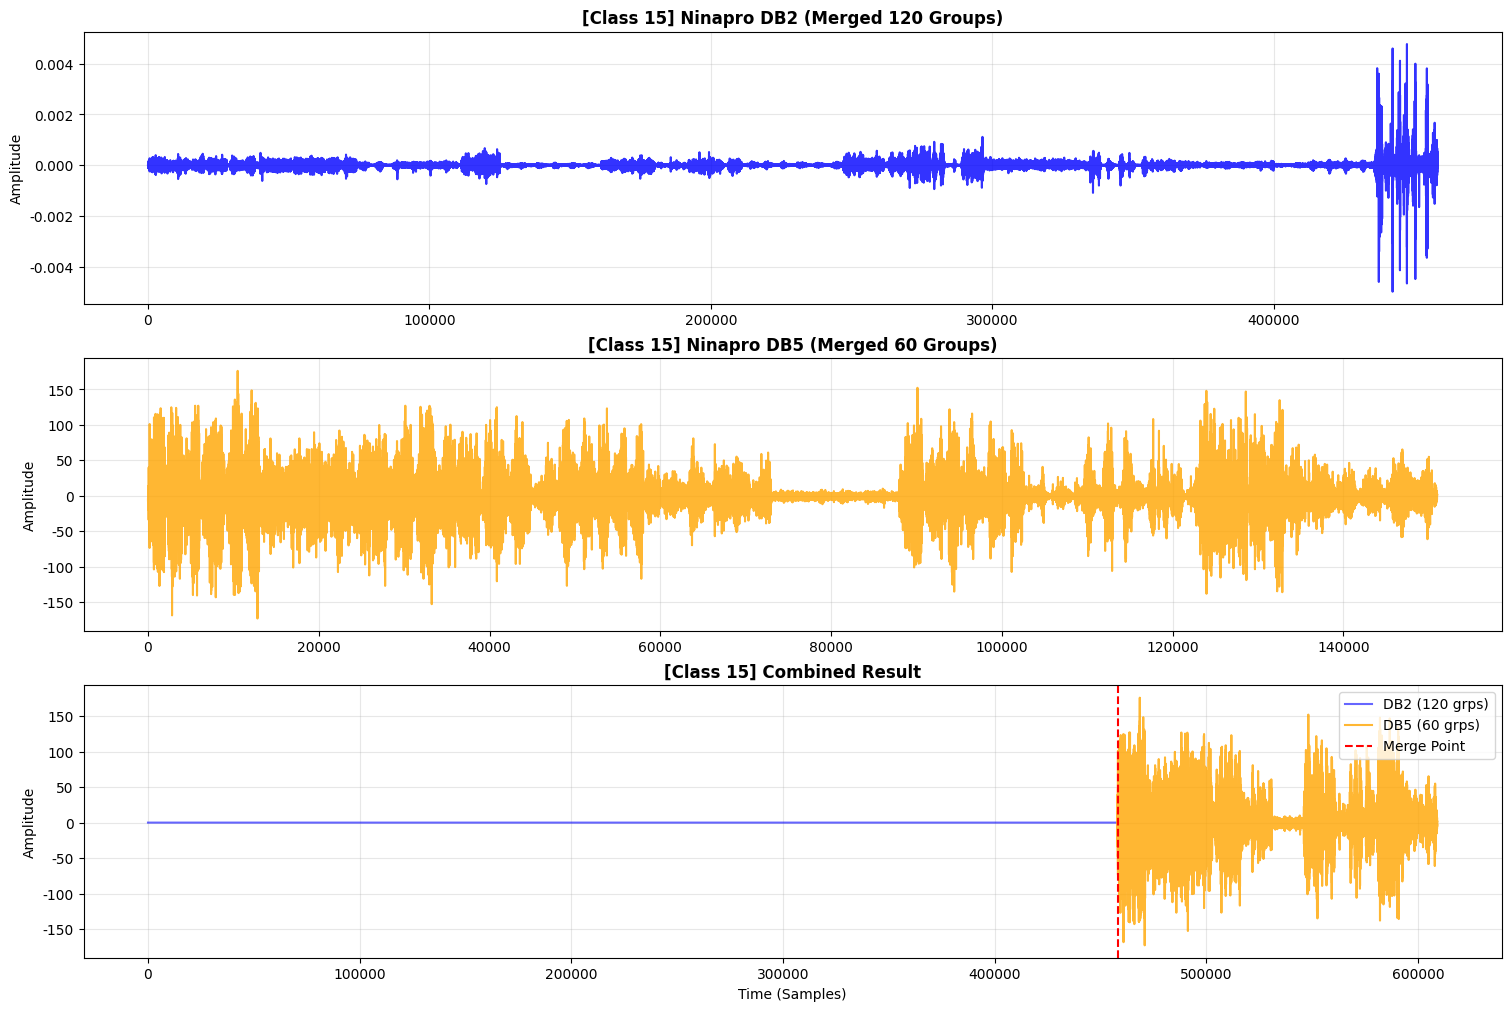

------------------------------------------------------------
Label 16 정보:
  - DB2: 451000 samples (Total 120 Groups merged)
  - DB5: 224000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


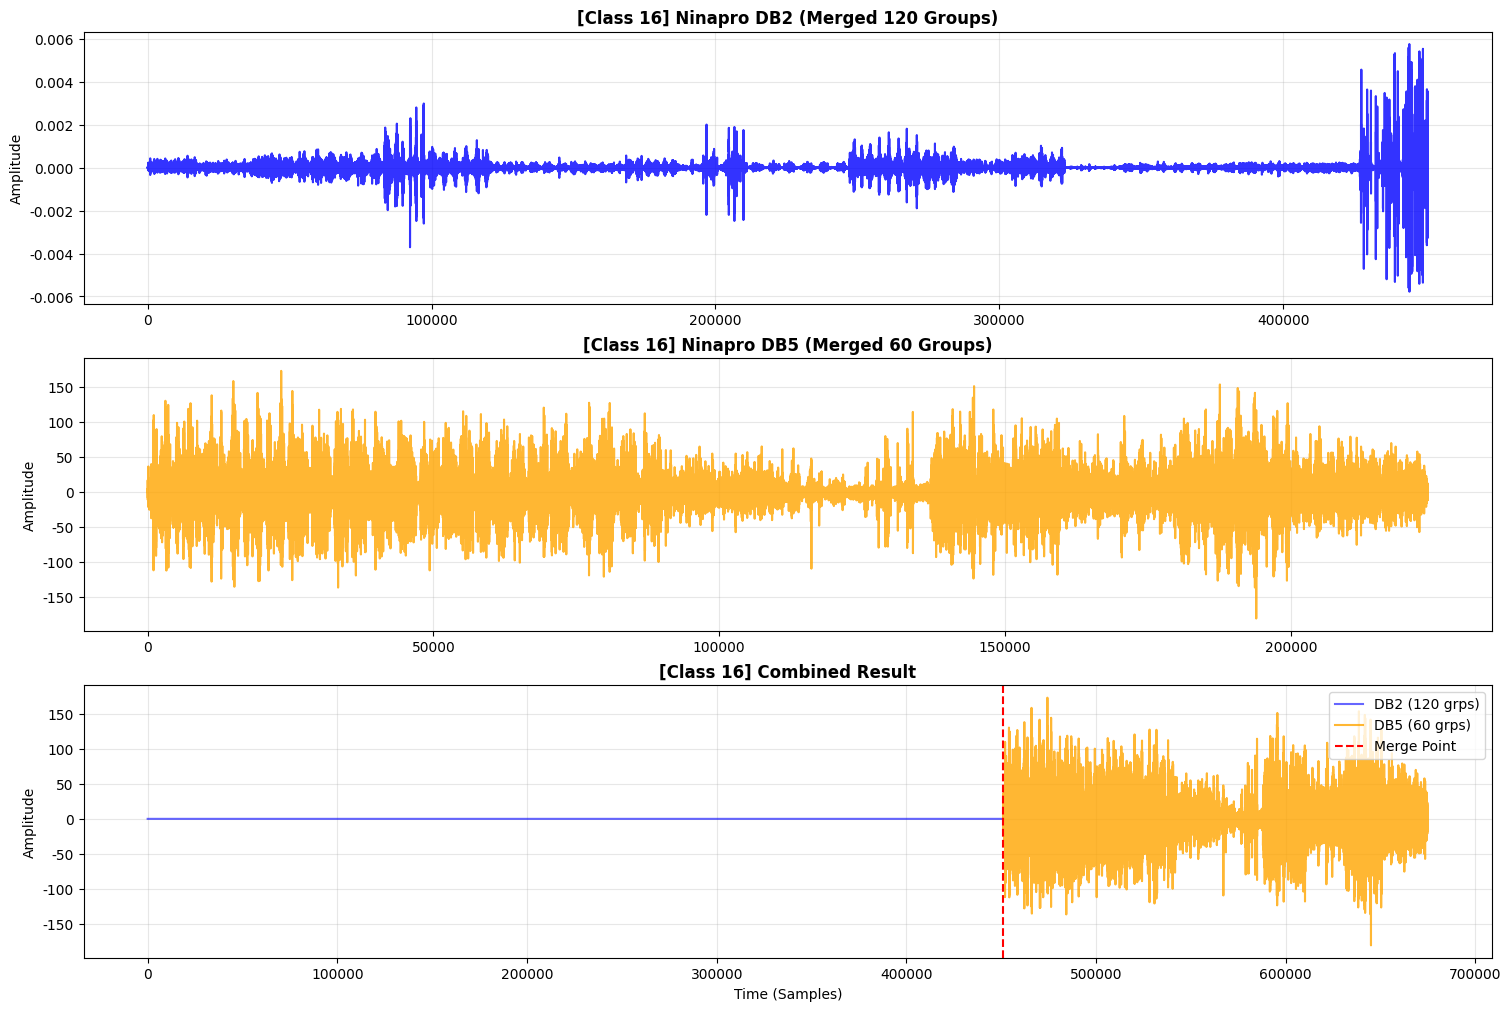

------------------------------------------------------------
Label 17 정보:
  - DB2: 359000 samples (Total 120 Groups merged)
  - DB5: 203000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


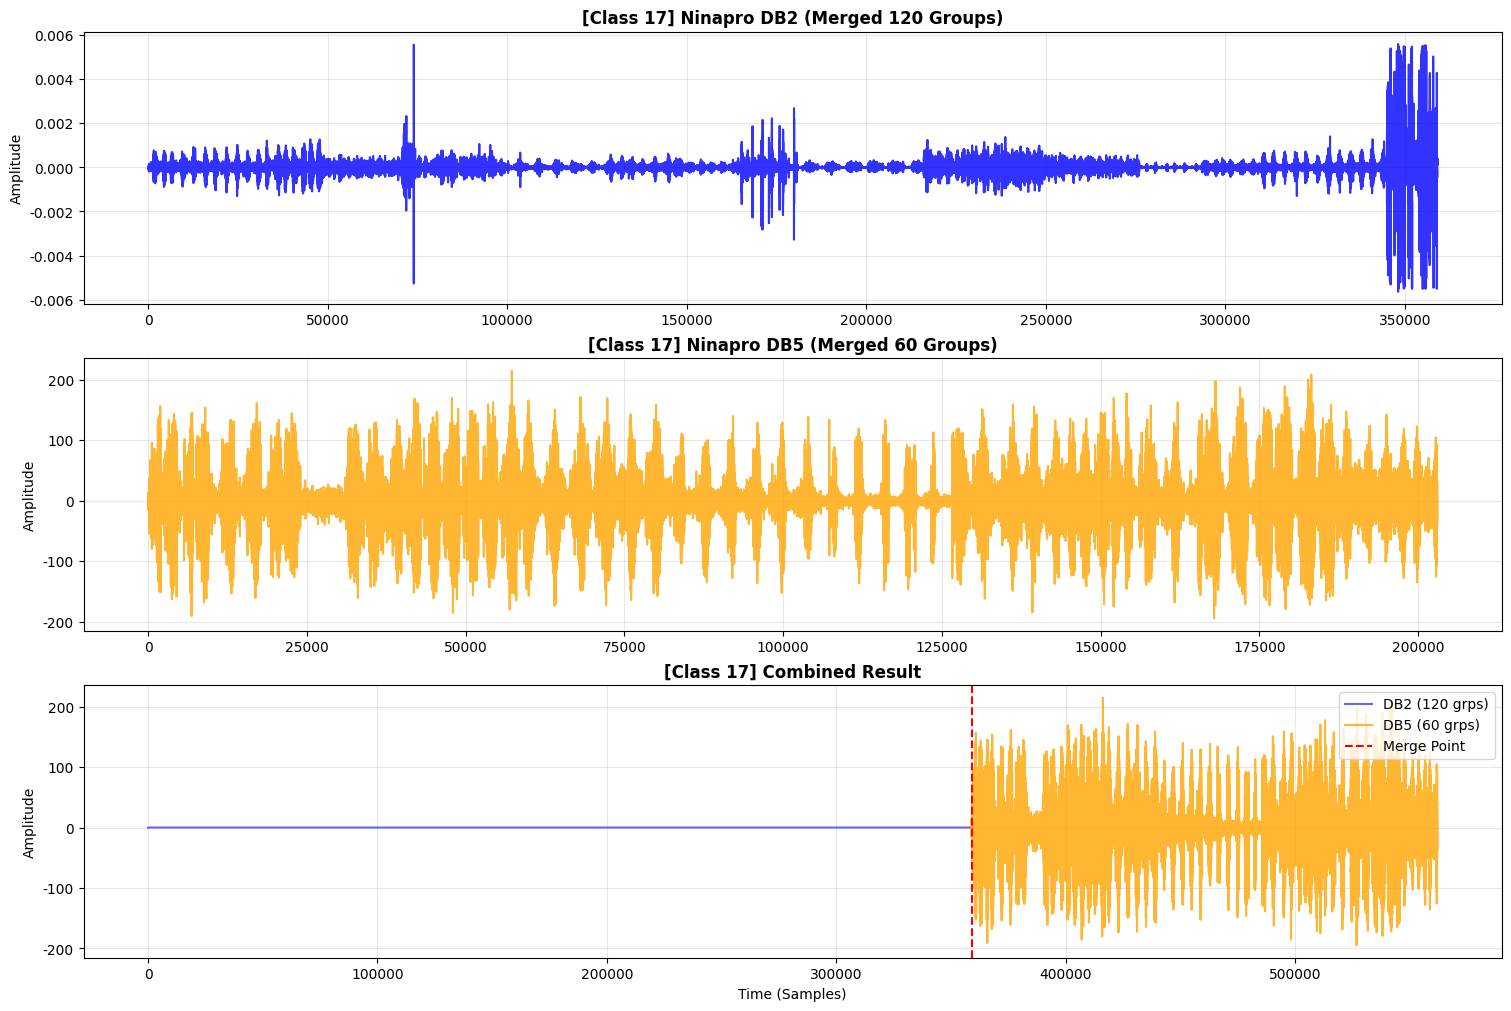

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# [핵심 해결책] 폰트 관련 경고 로그를 차단하고, 폰트를 기본값으로 변경
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# [가정] ninapro_df2, ninapro_df5 데이터프레임이 이미 로드되어 있어야 합니다.

# ==========================================
# 1. 설정
# ==========================================
sensor_idx_to_plot = 0  

if 'ninapro_df2' in locals() and 'ninapro_df5' in locals():
    emg_columns = [col for col in ninapro_df2.columns if col != 'Restimulus']
    target_col_name = emg_columns[sensor_idx_to_plot]

    classes_df2 = set(ninapro_df2['Restimulus'].unique())
    classes_df5 = set(ninapro_df5['Restimulus'].unique())
    all_classes = sorted(list(classes_df2 | classes_df5)) 

    print(f"총 {len(all_classes)}개의 클래스를 발견했습니다: {all_classes}")

    # ==========================================
    # 2. 반복 시각화
    # ==========================================
    for target_class in all_classes:
        
        # --------------------------------------
        # [수정됨] 그룹 수 카운팅 및 데이터 추출
        # --------------------------------------
        # 1. 인덱스를 유지한 상태로 필터링 (원본 위치 확인용)
        raw_df2 = ninapro_df2[ninapro_df2['Restimulus'] == target_class]
        raw_df5 = ninapro_df5[ninapro_df5['Restimulus'] == target_class]
        
        # 2. 그룹 수 계산: 인덱스가 1보다 크게 차이나는 지점(끊긴 지점)의 개수를 셈
        # (데이터가 없으면 0, 있으면 최소 1그룹 + 끊긴 횟수)
        groups_count_2 = 0
        if not raw_df2.empty:
            groups_count_2 = 1 + (raw_df2.index.to_series().diff() > 1).sum()
            
        groups_count_5 = 0
        if not raw_df5.empty:
            groups_count_5 = 1 + (raw_df5.index.to_series().diff() > 1).sum()

        # 3. 그래프용 데이터 준비 (인덱스 초기화)
        df2_subset = raw_df2[target_col_name].reset_index(drop=True)
        df5_subset = raw_df5[target_col_name].reset_index(drop=True)
        
        if df2_subset.empty and df5_subset.empty:
            continue

        # [출력] 데이터 길이 및 합쳐진 그룹 수 정보 출력
        print(f"-" * 60)
        print(f"Label {target_class} 정보:")
        print(f"  - DB2: {len(df2_subset)} samples (Total {groups_count_2} Groups merged)")
        print(f"  - DB5: {len(df5_subset)} samples (Total {groups_count_5} Groups merged)")
        print(f"  >>> 그래프 생성 중...")

        # --------------------------------------
        # 그래프 그리기
        # --------------------------------------
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), constrained_layout=True)
        
        # [1] DB2
        if not df2_subset.empty:
            axes[0].plot(df2_subset, color='blue', alpha=0.8)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Merged {groups_count_2} Groups)', fontsize=12, fontweight='bold')
        else:
            axes[0].text(0.5, 0.5, "No Data in DB2", ha='center', va='center', fontsize=15)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Missing)', fontsize=12, color='red')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)

        # [2] DB5
        if not df5_subset.empty:
            axes[1].plot(df5_subset, color='orange', alpha=0.8)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Merged {groups_count_5} Groups)', fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, "No Data in DB5", ha='center', va='center', fontsize=15)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Missing)', fontsize=12, color='red')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True, alpha=0.3)

        # [3] Merged
        if not df2_subset.empty:
            axes[2].plot(np.arange(len(df2_subset)), df2_subset, color='blue', alpha=0.6, label=f'DB2 ({groups_count_2} grps)')
        
        if not df5_subset.empty:
            start_idx = len(df2_subset)
            axes[2].plot(np.arange(start_idx, start_idx + len(df5_subset)), df5_subset, 
                        color='orange', alpha=0.8, label=f'DB5 ({groups_count_5} grps)')
            if start_idx > 0:
                axes[2].axvline(x=start_idx, color='red', linestyle='--', label='Merge Point')

        axes[2].set_title(f'[Class {target_class}] Combined Result', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Time (Samples)')
        axes[2].set_ylabel('Amplitude')
        axes[2].legend(loc='upper right')
        axes[2].grid(True, alpha=0.3)

        plt.show() 
else:
    print("오류: 데이터프레임이 정의되지 않았습니다.")

In [7]:
import pandas as pd

def print_max_min_exclude_zero(df, df_name):
    # 1. 연속된 그룹 식별 ID 생성
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    # 2. 그룹별 길이(size)와 라벨값(first) 추출
    group_info = df.groupby(group_id)['Restimulus'].agg(['size', 'first'])
    
    # -------------------------------------------------------
    # [기능 추가] Label 0 제외 필터링
    # -------------------------------------------------------
    # 라벨이 0이 아닌 그룹만 남깁니다.
    target_groups = group_info[group_info['first'] != 0]
    
    if target_groups.empty:
        print(f"[{df_name}] Label 0을 제외하면 남는 데이터가 없습니다.")
        return

    # 3. 최대/최소값 찾기 (필터링된 데이터 기준)
    max_len = target_groups['size'].max()
    min_len = target_groups['size'].min()
    
    # 해당 길이의 라벨 찾기
    max_label = target_groups.loc[target_groups['size'].idxmax(), 'first']
    min_label = target_groups.loc[target_groups['size'].idxmin(), 'first']
    
    print(f"📊 [{df_name}] 분석 결과 (Label 0 제외)")
    print(f"----------------------------------------")
    print(f"최대 길이: {max_len} (Label: {max_label})")
    print(f"최소 길이: {min_len} (Label: {min_label})")
    print(f"분석된 그룹 수: {len(target_groups)} (전체 {len(group_info)}개 중)")
    print(f"----------------------------------------\n")

# --- 실행 ---
print_max_min_exclude_zero(ninapro_df2, "ninapro_df2")
print_max_min_exclude_zero(ninapro_df5, "ninapro_df5")

📊 [ninapro_df2] 분석 결과 (Label 0 제외)
----------------------------------------
최대 길이: 7000 (Label: 1)
최소 길이: 1000 (Label: 6)
분석된 그룹 수: 2040 (전체 4081개 중)
----------------------------------------

📊 [ninapro_df5] 분석 결과 (Label 0 제외)
----------------------------------------
최대 길이: 7000 (Label: 17)
최소 길이: 2000 (Label: 6)
분석된 그룹 수: 1020 (전체 2041개 중)
----------------------------------------



In [8]:
import pandas as pd

def force_fixed_length_with_stitching(df, target_length=2000):
    """
    모든 그룹을 target_length로 만듭니다.
    - 긴 경우: 2000개 자르고, 남은 것은 '대기열(Buffer)'에 넣습니다.
    - 짧은 경우: '대기열'에 있는 데이터와 합쳐서 2000을 만듭니다.
    - 그래도 부족하면: 다음 데이터가 올 때까지 대기열에서 기다립니다.
    """
    # 1. 그룹 식별
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    processed_list = []
    
    # [핵심] 라벨별로 자투리 데이터를 모아둘 저장소 (Dictionary)
    # 예: { Label_1: DataFrame, Label_2: DataFrame ... }
    label_buffer = {}
    
    print(f"--- 길이 고정 및 이어붙이기 작업 시작 (Target: {target_length}) ---")
    
    # 2. 그룹별 순회
    for gid, segment in df.groupby(group_id):
        label = segment['Restimulus'].iloc[0] # 현재 그룹의 동작 라벨
        
        # (1) 해당 라벨의 버퍼가 비어있으면 새로 생성
        if label not in label_buffer:
            label_buffer[label] = pd.DataFrame()
            
        # (2) 현재 구간을 버퍼(대기열) 뒤에 추가
        #     이전 그룹에서 남은 자투리 뒤에 현재 데이터를 붙이는 개념
        label_buffer[label] = pd.concat([label_buffer[label], segment])
        
        # (3) 버퍼에 데이터가 2000개 이상 쌓였는지 확인 (반복)
        while len(label_buffer[label]) >= target_length:
            # 2000개만큼 뚝 떼어내기
            complete_segment = label_buffer[label].iloc[:target_length].copy()
            
            # 인덱스 깔끔하게 초기화 (0 ~ 1999)
            complete_segment = complete_segment.reset_index(drop=True)
            
            # 결과 리스트에 저장
            processed_list.append(complete_segment)
            
            # 버퍼 업데이트 (앞에 쓴 2000개는 버리고 남은 뒷부분만 남김)
            label_buffer[label] = label_buffer[label].iloc[target_length:]
            
    # 3. 병합 및 반환
    if processed_list:
        new_df = pd.concat(processed_list).reset_index(drop=True)
        
        # 통계 출력
        print(f"-> 처리 완료. 생성된 2000길이 샘플 수: {len(processed_list)}개")
        
        # (선택사항) 아직 버퍼에 남아서 2000이 안 되어 버려진 데이터 확인
        total_leftover = sum([len(buf) for buf in label_buffer.values()])
        print(f"-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: {total_leftover}개")
        
        return new_df
    else:
        return pd.DataFrame(columns=df.columns)

# ---------------------------------------------------------
# 실행 및 결과 저장
# ---------------------------------------------------------

# ninapro_df2 적용
print("\nProcessing 'ninapro_df2'...")
ninapro_df2 = force_fixed_length_with_stitching(ninapro_df2, target_length=2000)

# ninapro_df5 적용
print("\nProcessing 'ninapro_df5'...")
ninapro_df5 = force_fixed_length_with_stitching(ninapro_df5, target_length=2000)


# ---------------------------------------------------------
# 결과 검증
# ---------------------------------------------------------
def check_length_stats(df, name):
    if len(df) == 0:
        print(f"[{name}] 데이터가 없습니다.")
        return
    # 이제 단순히 Restimulus로 묶으면 안되고(이어붙여서 섞였을 수 있음), 
    # 인덱스나 개수로 확인해야 합니다. 여기서는 전체 길이를 2000으로 나눠서 확인.
    
    total_len = len(df)
    is_perfect = (total_len % 2000) == 0
    
    print(f"\n📊 [{name}] 최종 검증")
    print(f"  - 전체 데이터 길이: {total_len}")
    print(f"  - 2000 단위로 딱 떨어집니까? : {is_perfect}")
    if is_perfect:
        print(f"  - 총 샘플 개수: {total_len // 2000}개")

check_length_stats(ninapro_df2, "ninapro_df2")
check_length_stats(ninapro_df5, "ninapro_df5")


Processing 'ninapro_df2'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 8025개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 11000개

Processing 'ninapro_df5'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 4547개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 9000개

📊 [ninapro_df2] 최종 검증
  - 전체 데이터 길이: 16050000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 8025개

📊 [ninapro_df5] 최종 검증
  - 전체 데이터 길이: 9094000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 4547개


총 18개의 클래스를 발견했습니다: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
------------------------------------------------------------
Label 0 정보:
  - DB2: 7830000 samples (Total 2007 Groups merged)
  - DB5: 5886000 samples (Total 1021 Groups merged)
  >>> 그래프 생성 중...


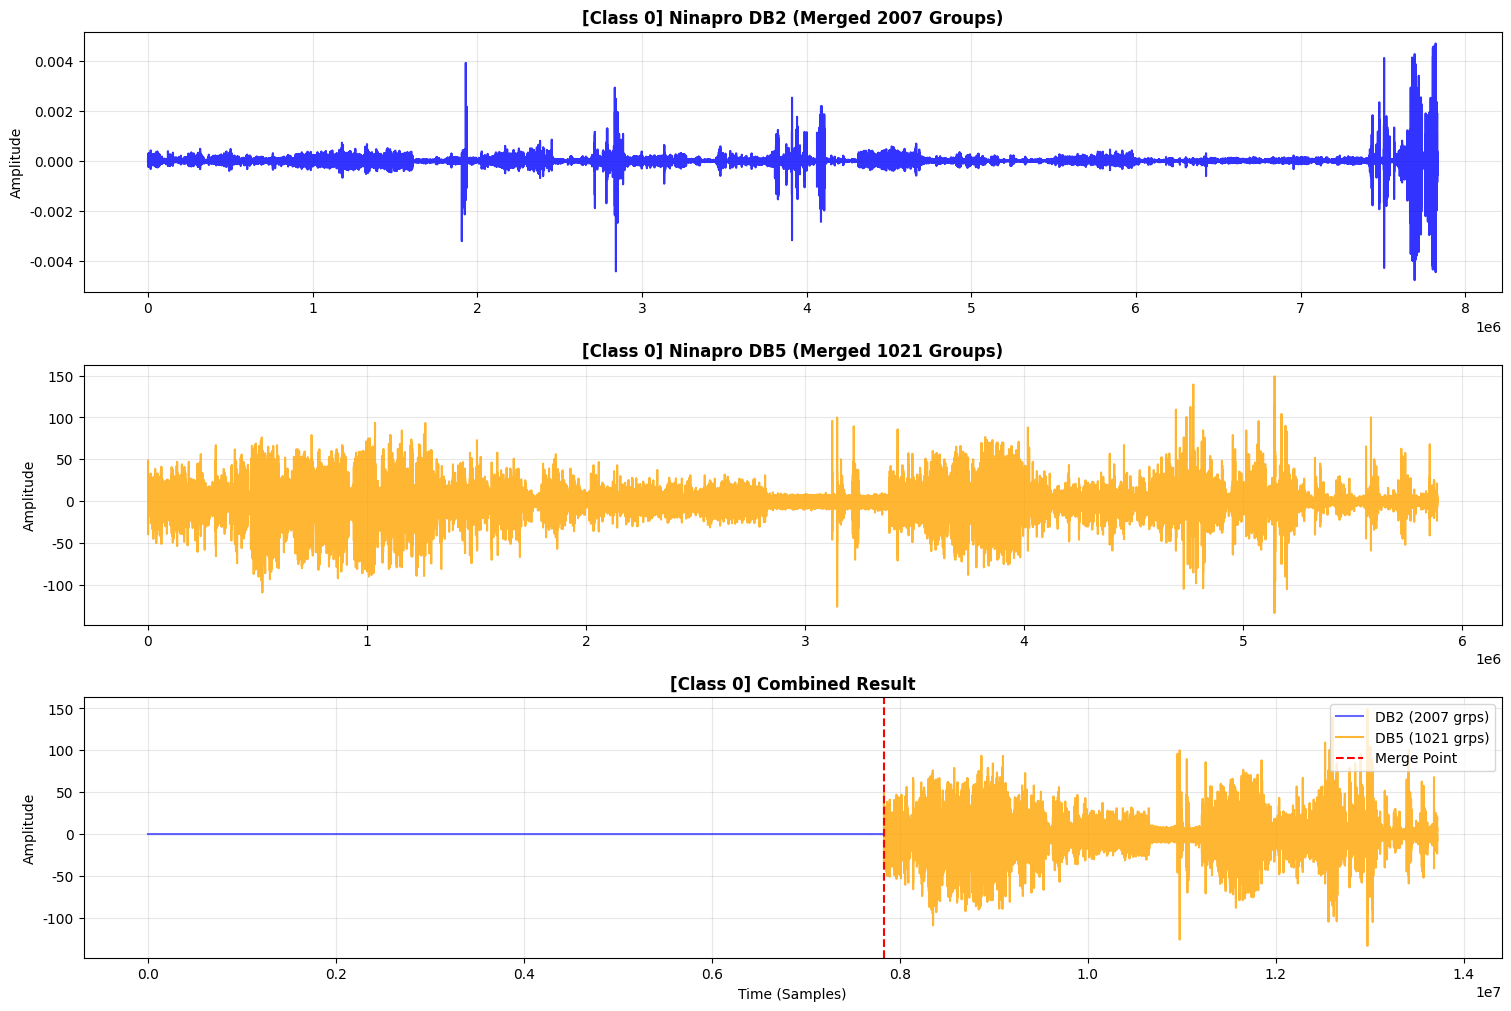

------------------------------------------------------------
Label 1 정보:
  - DB2: 672000 samples (Total 120 Groups merged)
  - DB5: 220000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


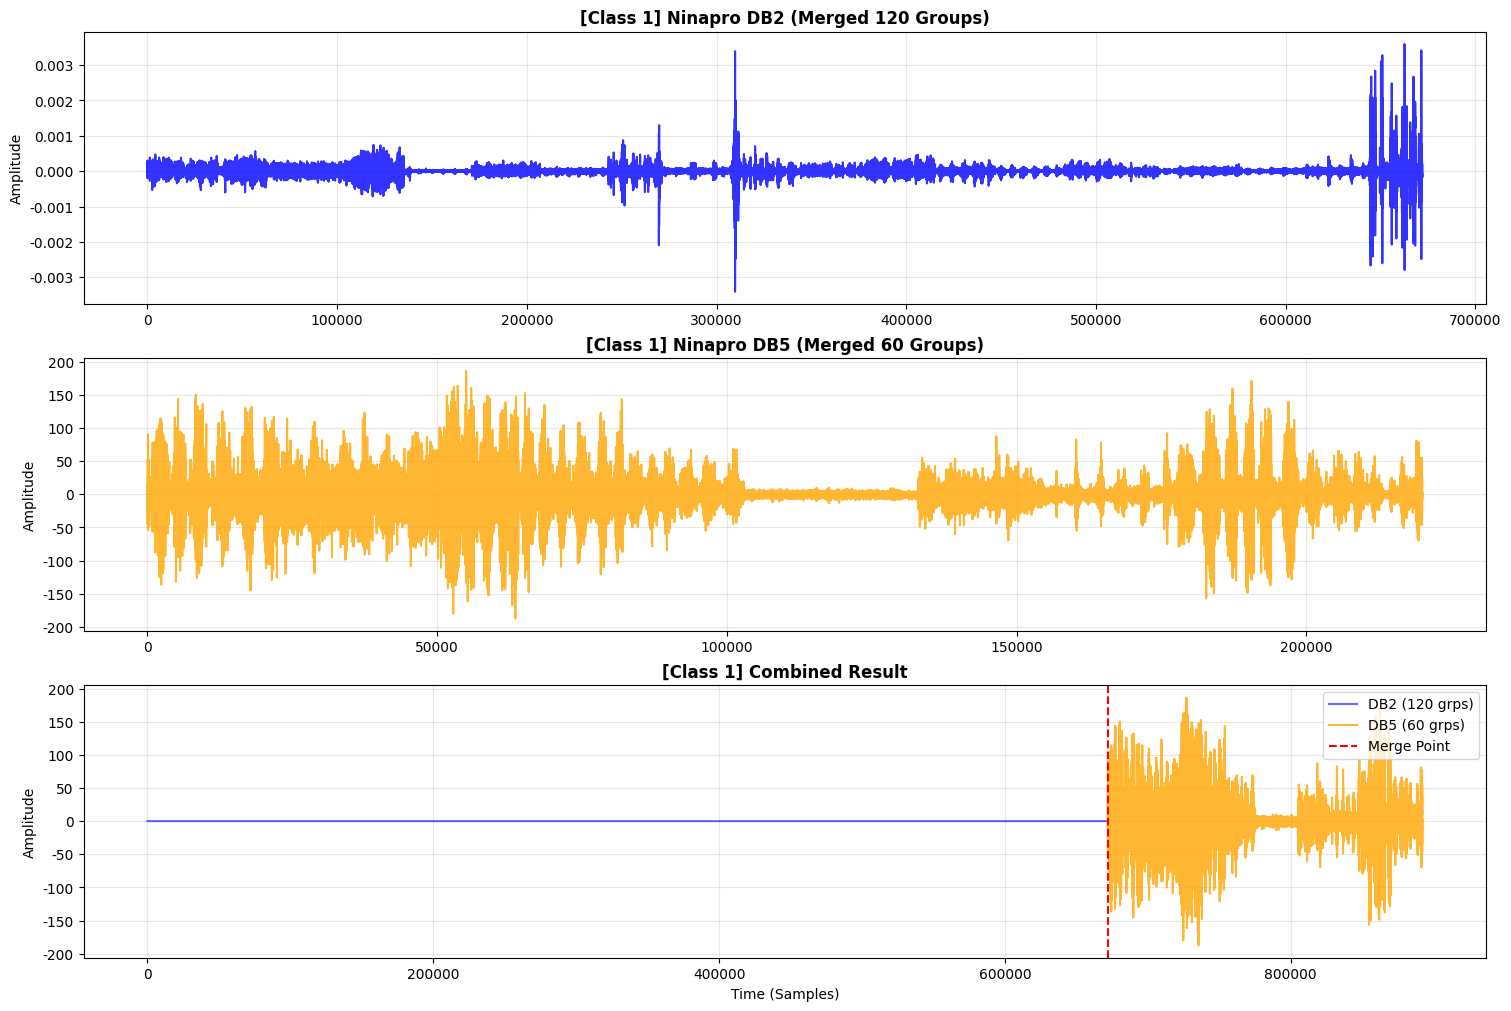

------------------------------------------------------------
Label 2 정보:
  - DB2: 582000 samples (Total 118 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


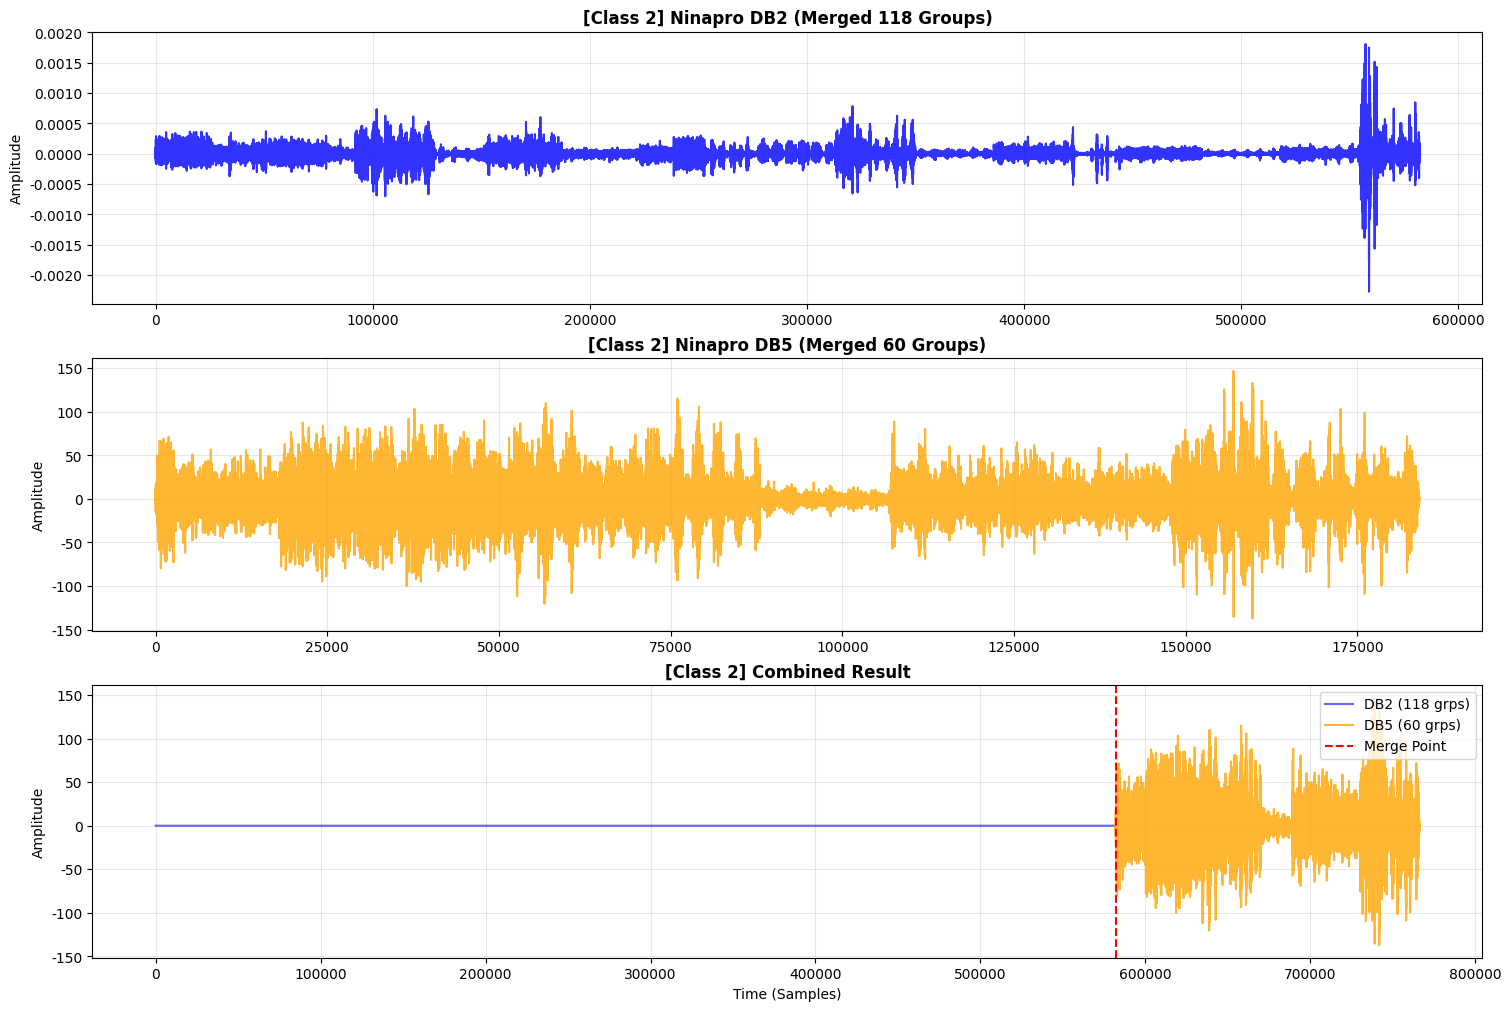

------------------------------------------------------------
Label 3 정보:
  - DB2: 506000 samples (Total 119 Groups merged)
  - DB5: 184000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


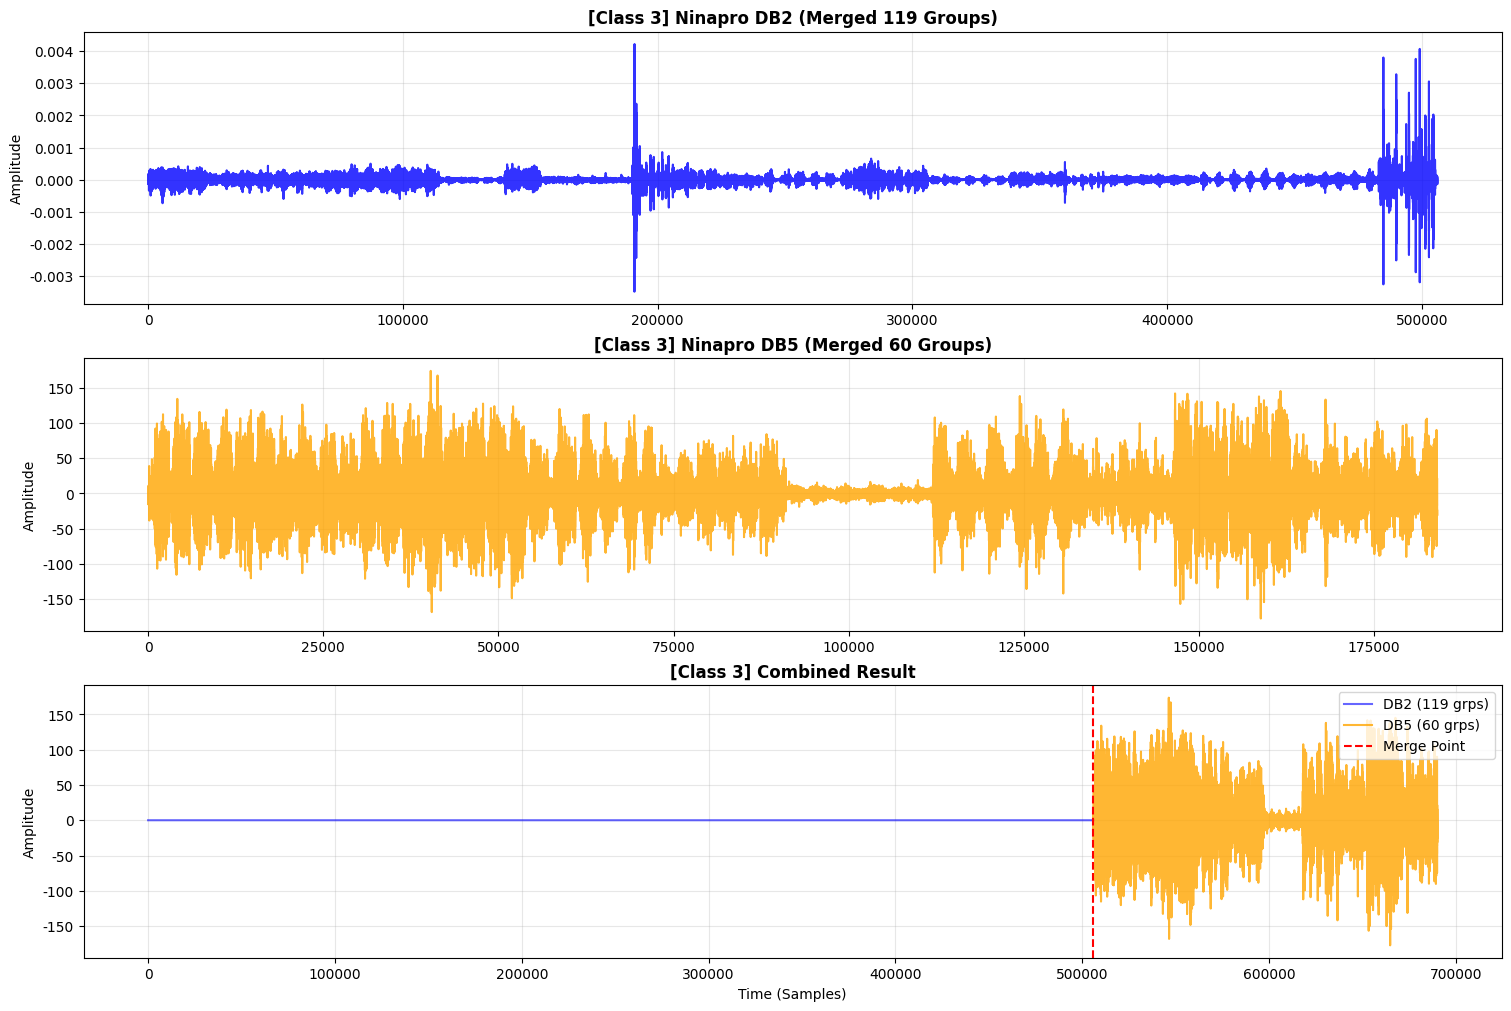

------------------------------------------------------------
Label 4 정보:
  - DB2: 482000 samples (Total 119 Groups merged)
  - DB5: 186000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


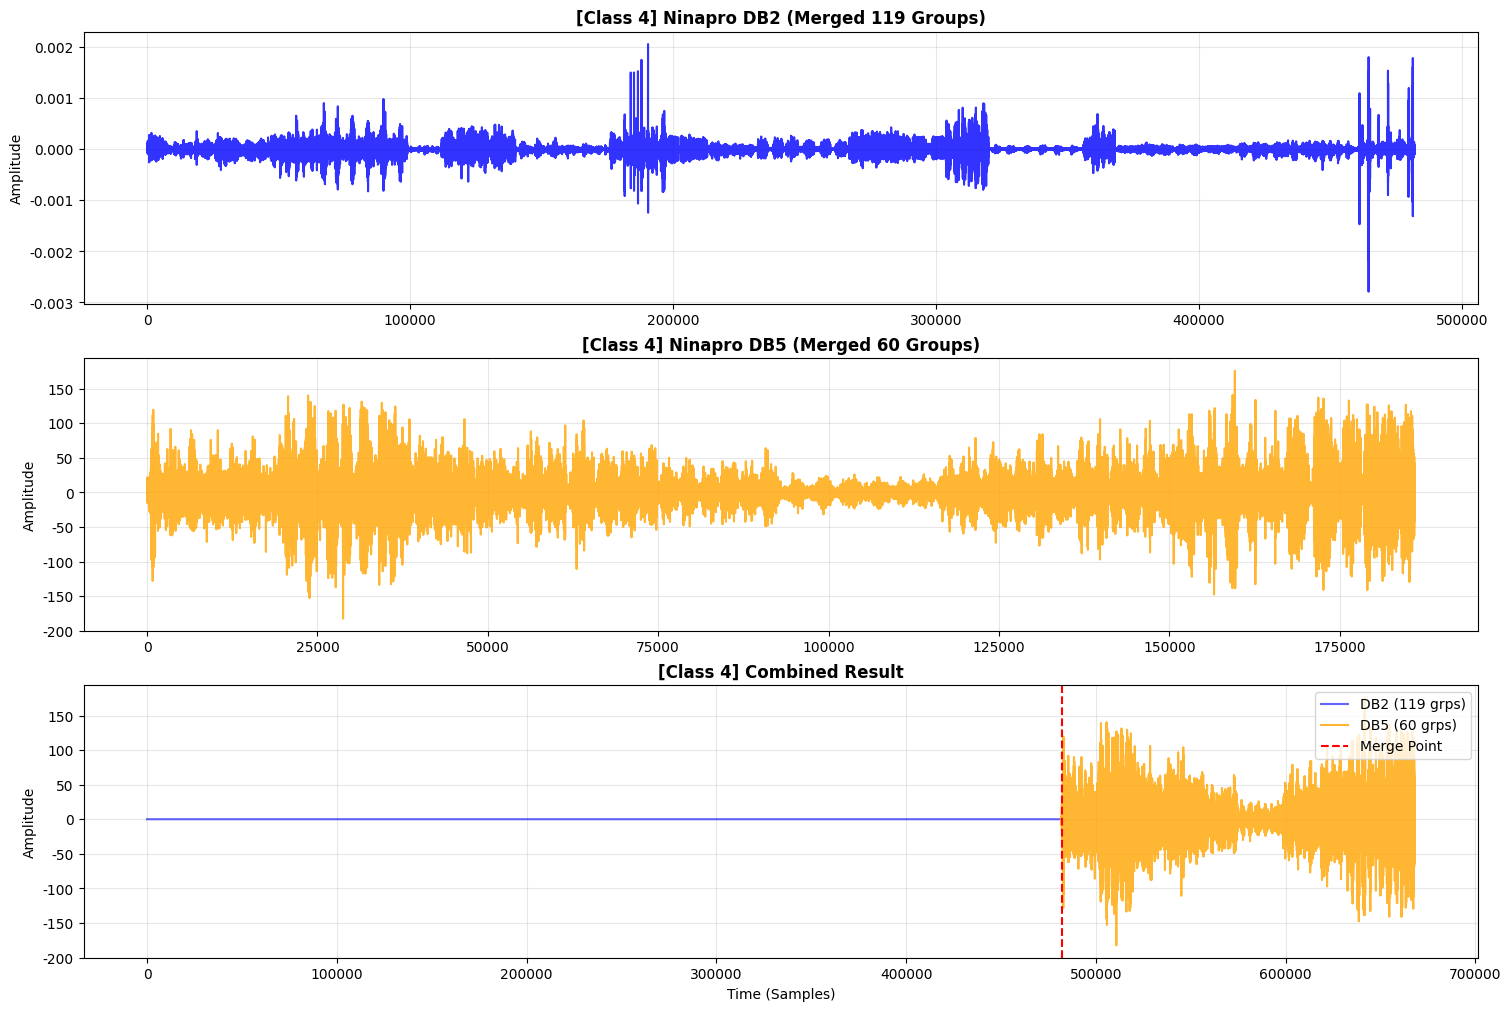

------------------------------------------------------------
Label 5 정보:
  - DB2: 438000 samples (Total 117 Groups merged)
  - DB5: 160000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


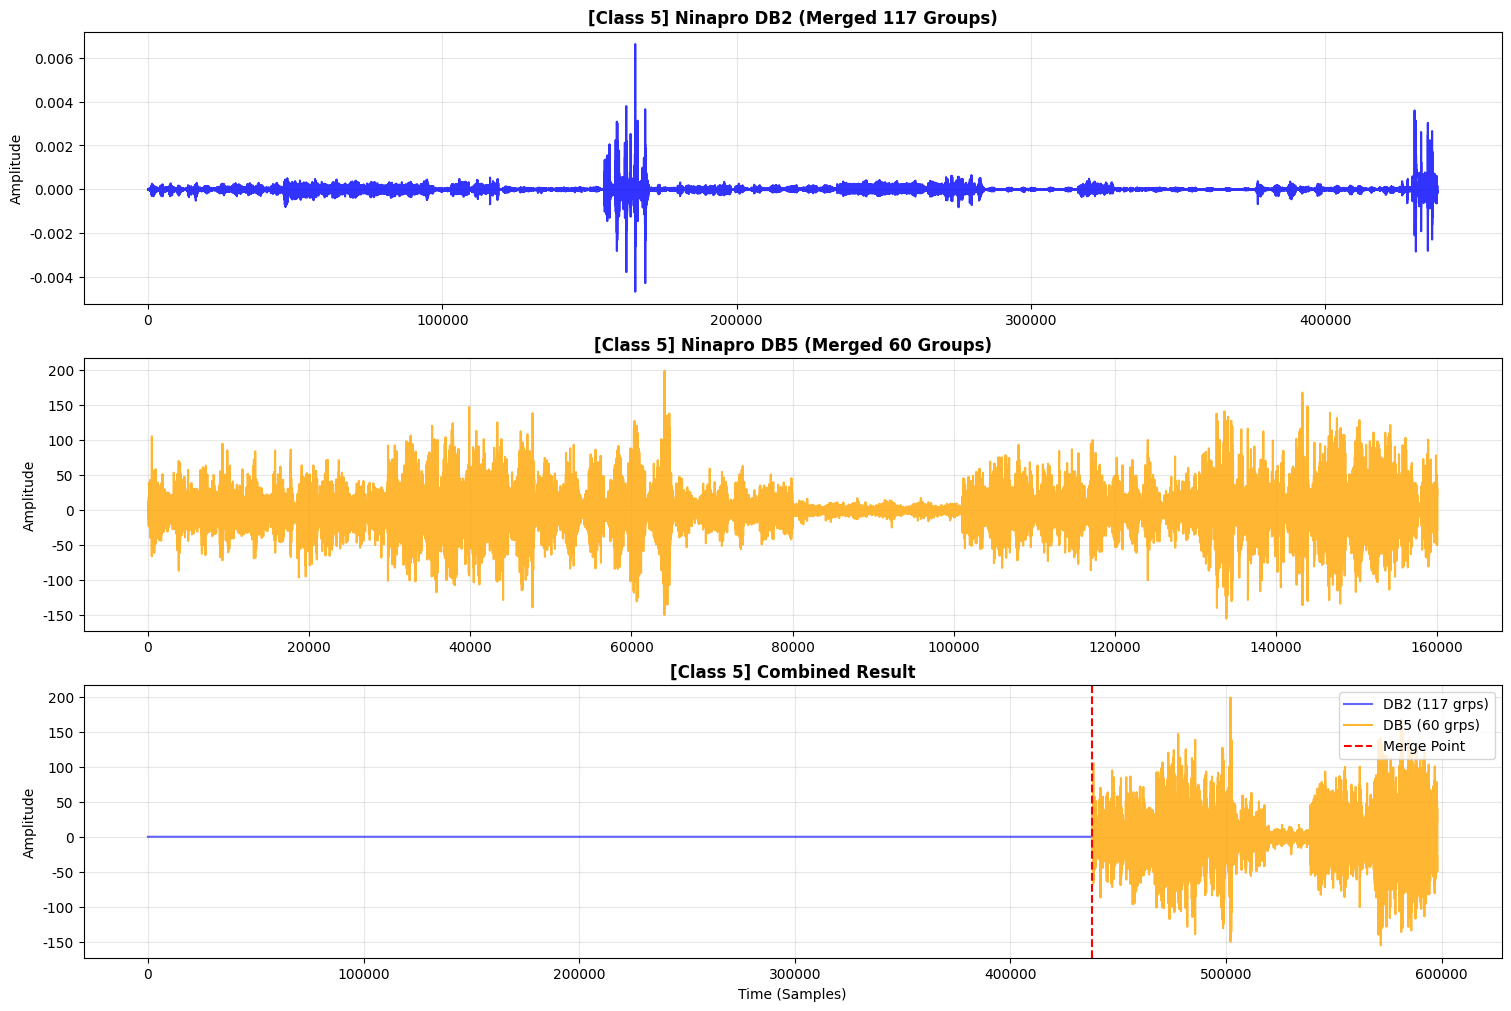

------------------------------------------------------------
Label 6 정보:
  - DB2: 400000 samples (Total 117 Groups merged)
  - DB5: 166000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


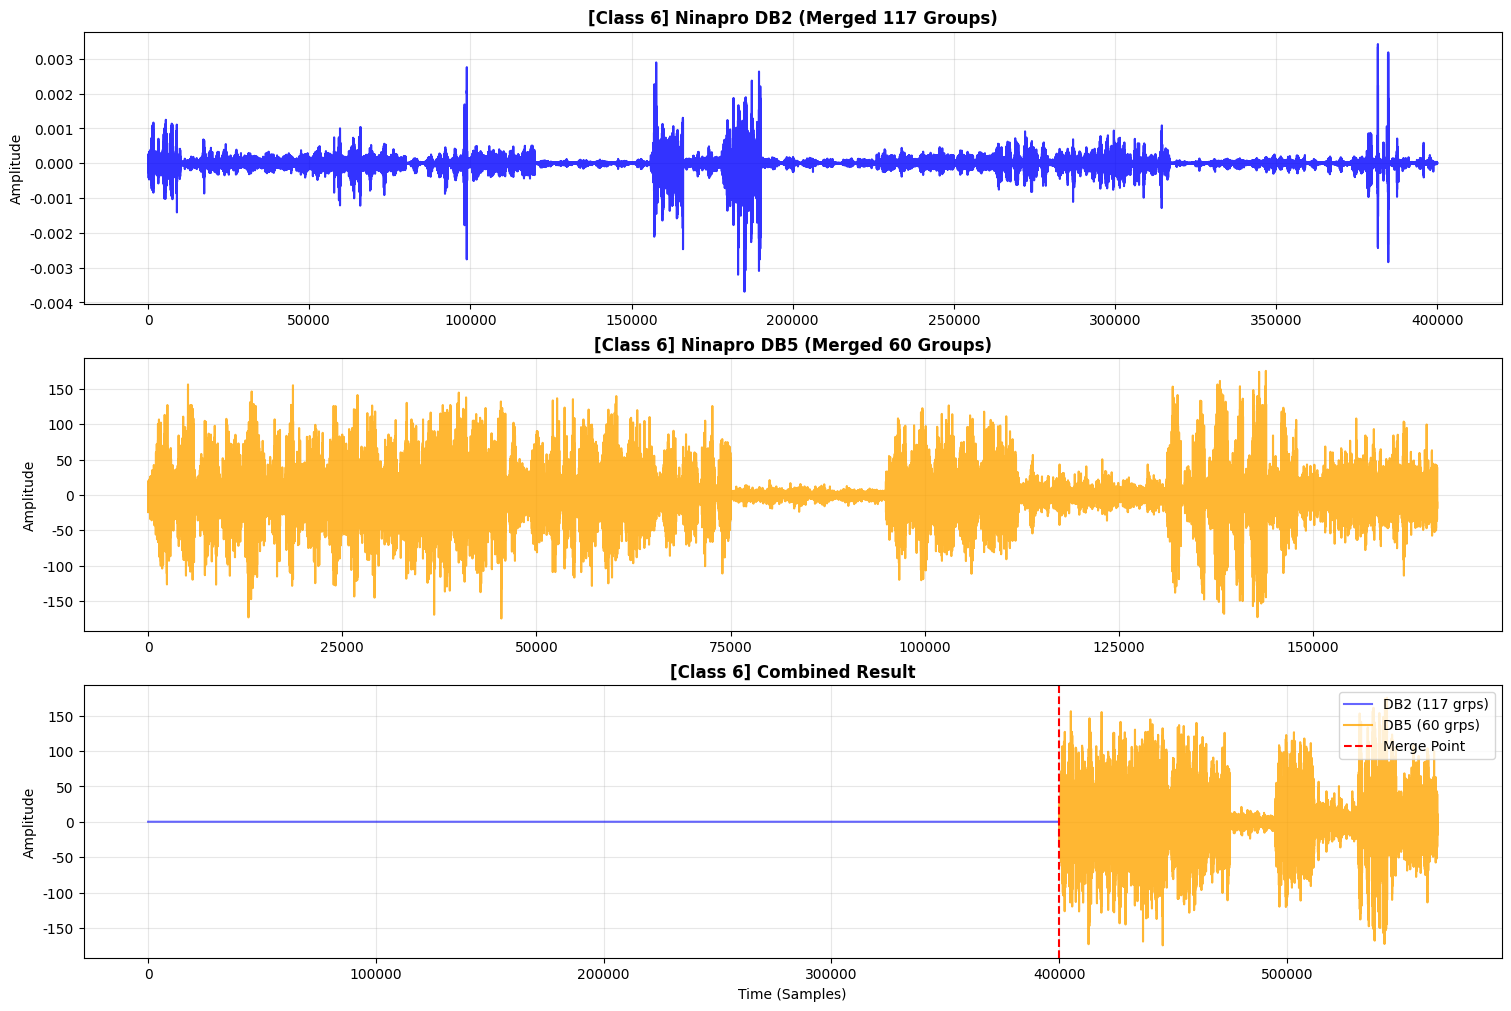

------------------------------------------------------------
Label 7 정보:
  - DB2: 636000 samples (Total 120 Groups merged)
  - DB5: 192000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


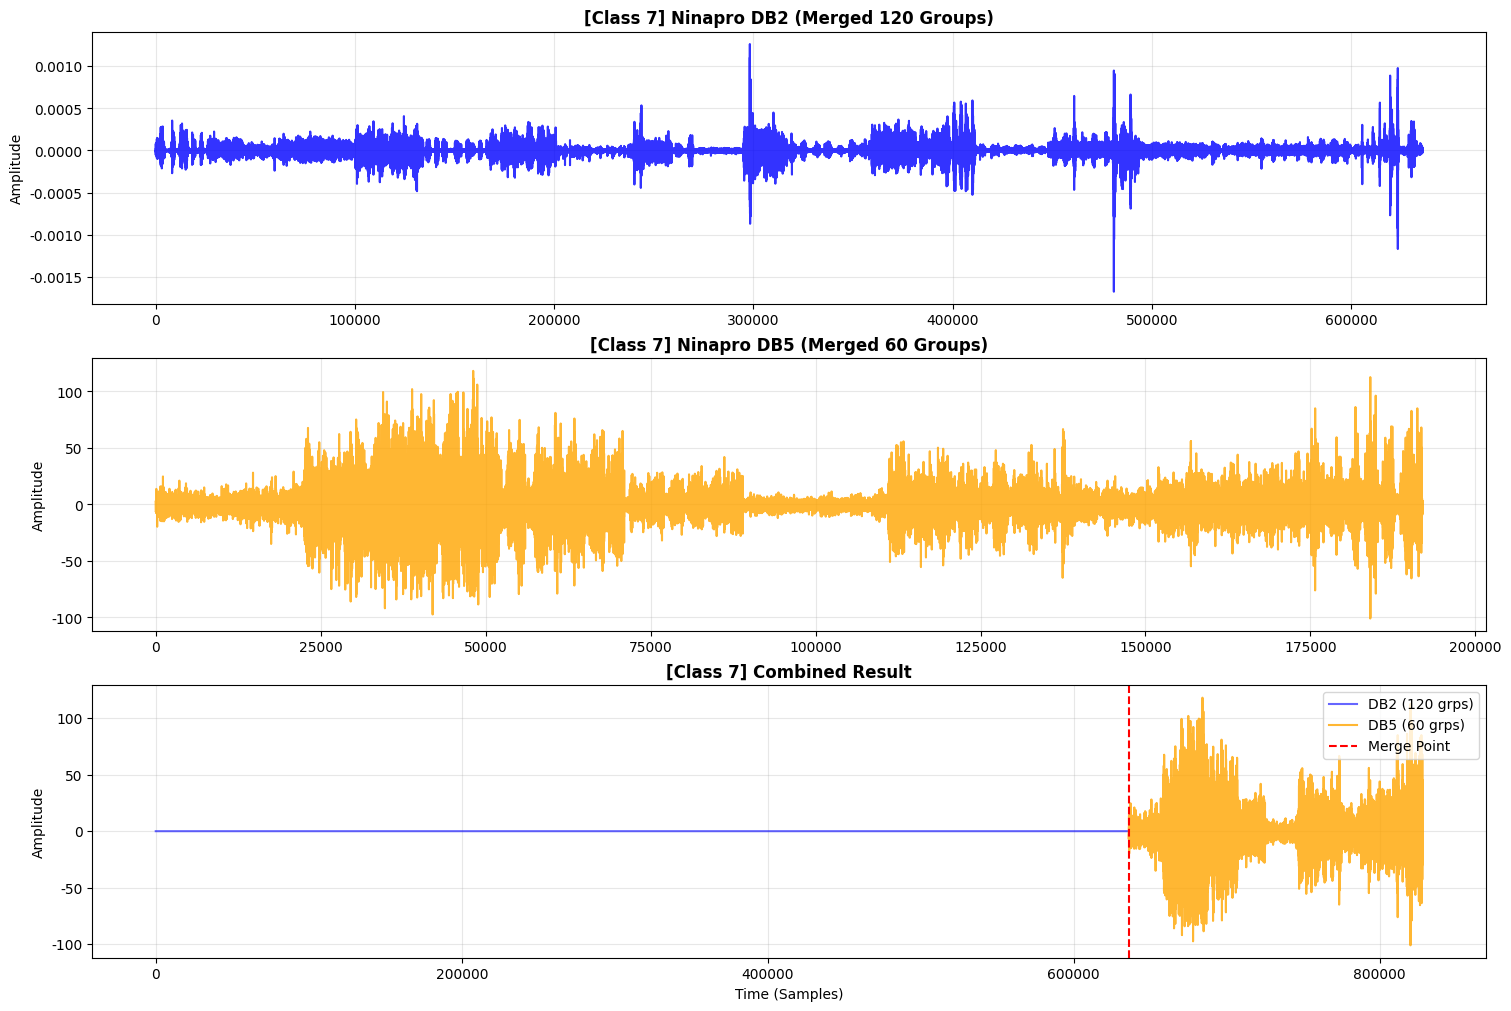

------------------------------------------------------------
Label 8 정보:
  - DB2: 490000 samples (Total 119 Groups merged)
  - DB5: 182000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


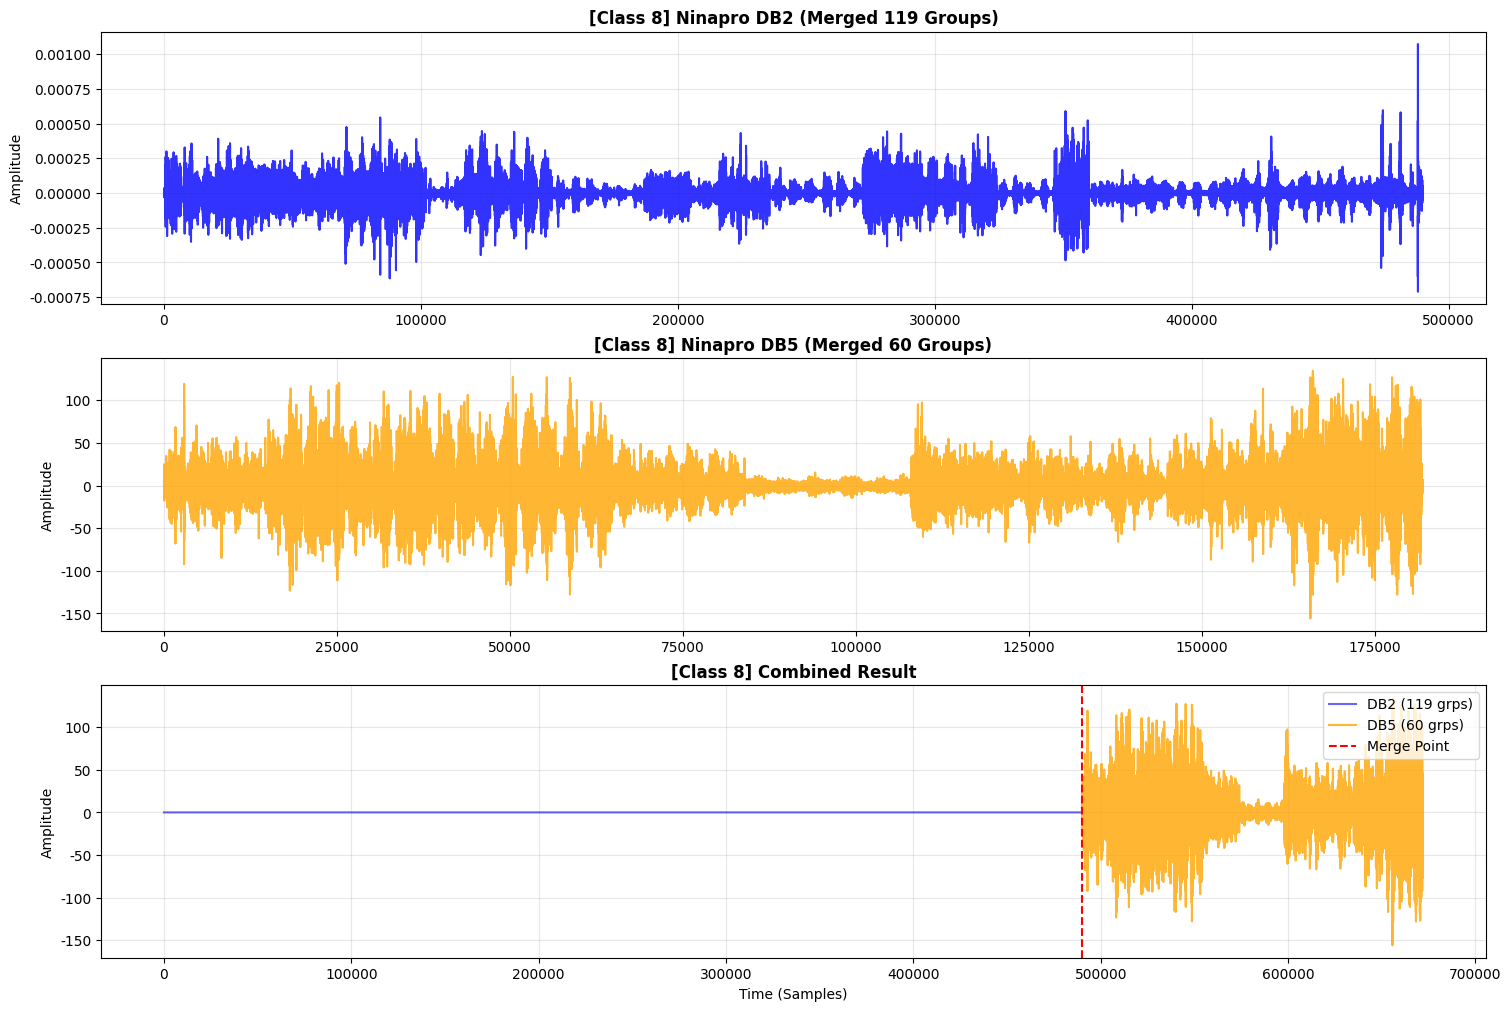

------------------------------------------------------------
Label 9 정보:
  - DB2: 532000 samples (Total 119 Groups merged)
  - DB5: 198000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


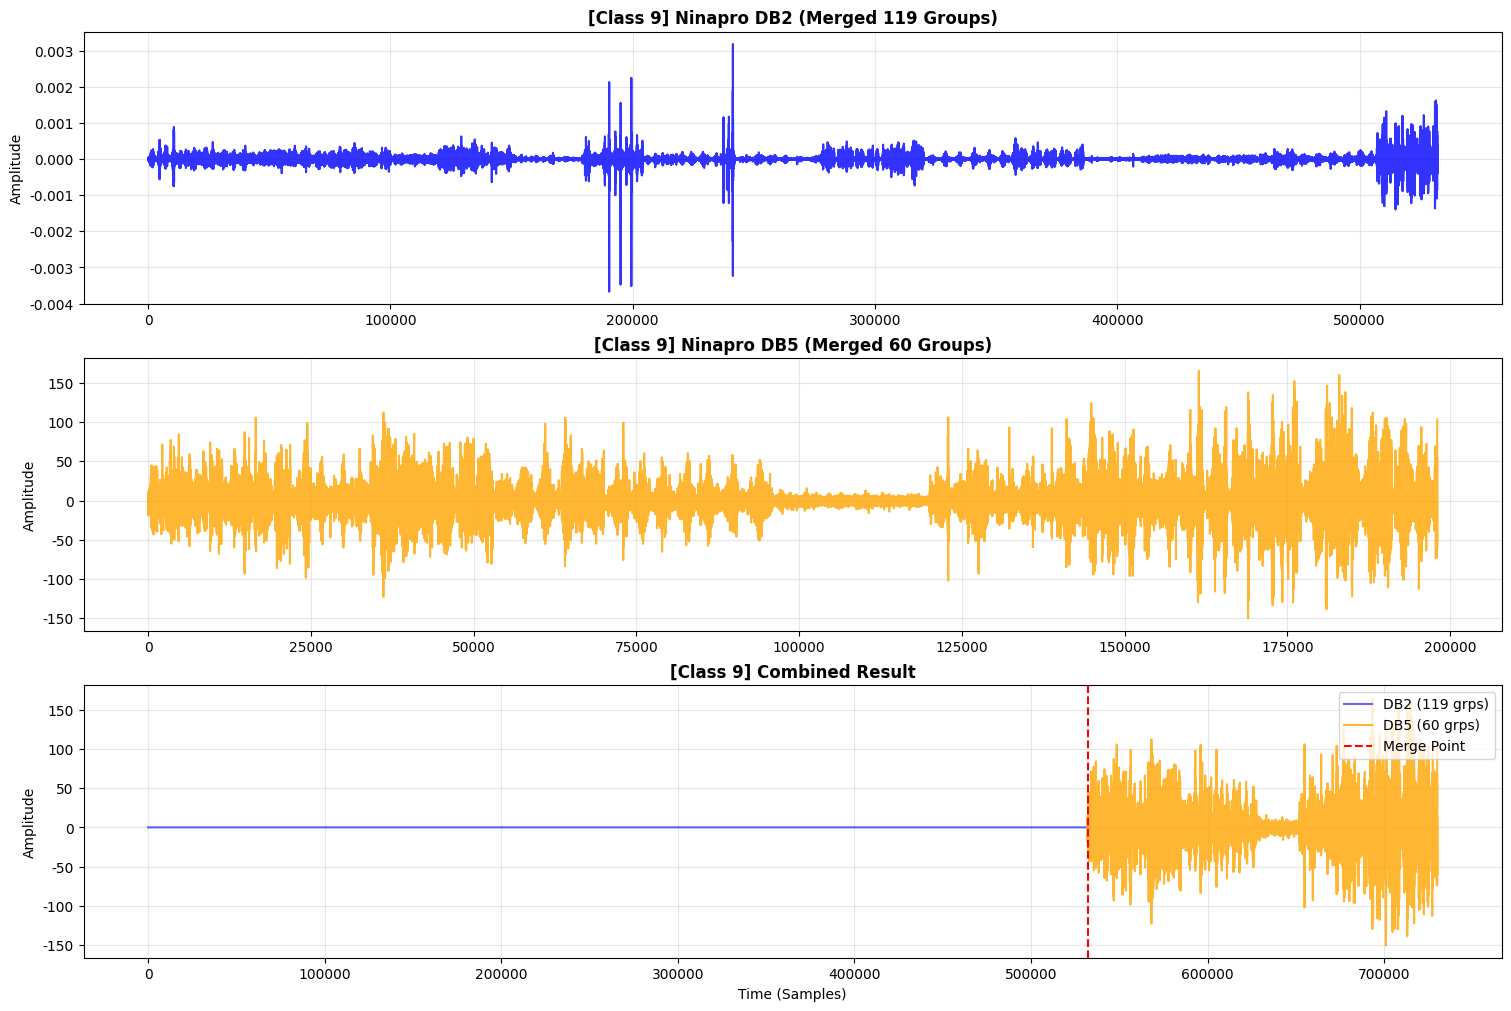

------------------------------------------------------------
Label 10 정보:
  - DB2: 516000 samples (Total 117 Groups merged)
  - DB5: 186000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


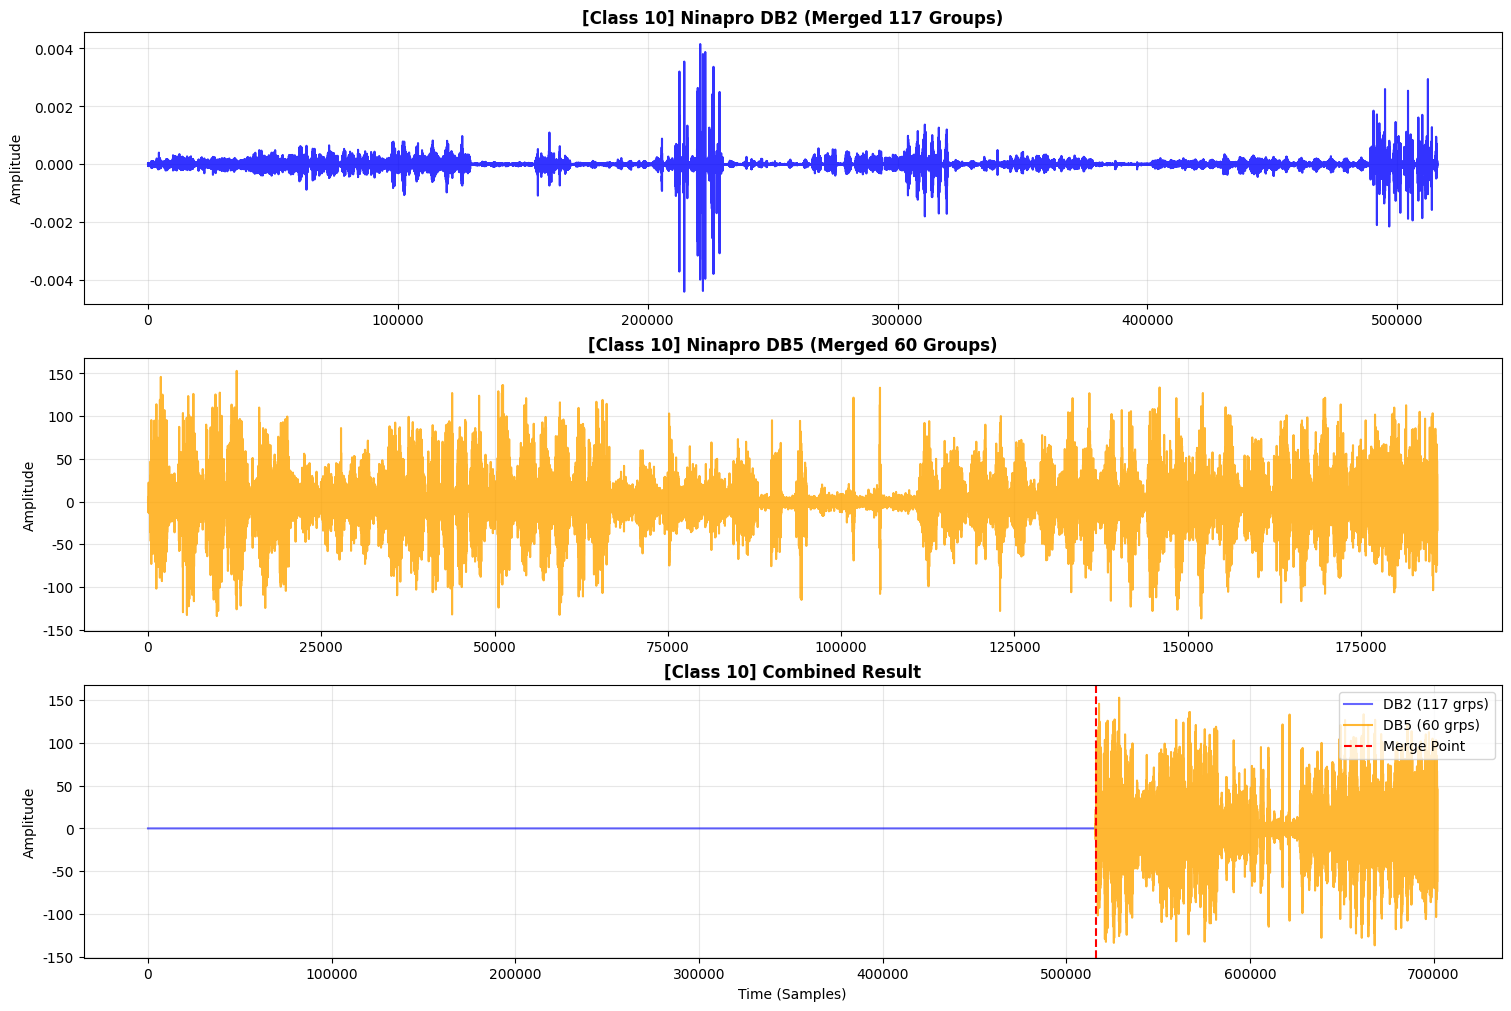

------------------------------------------------------------
Label 11 정보:
  - DB2: 548000 samples (Total 120 Groups merged)
  - DB5: 218000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


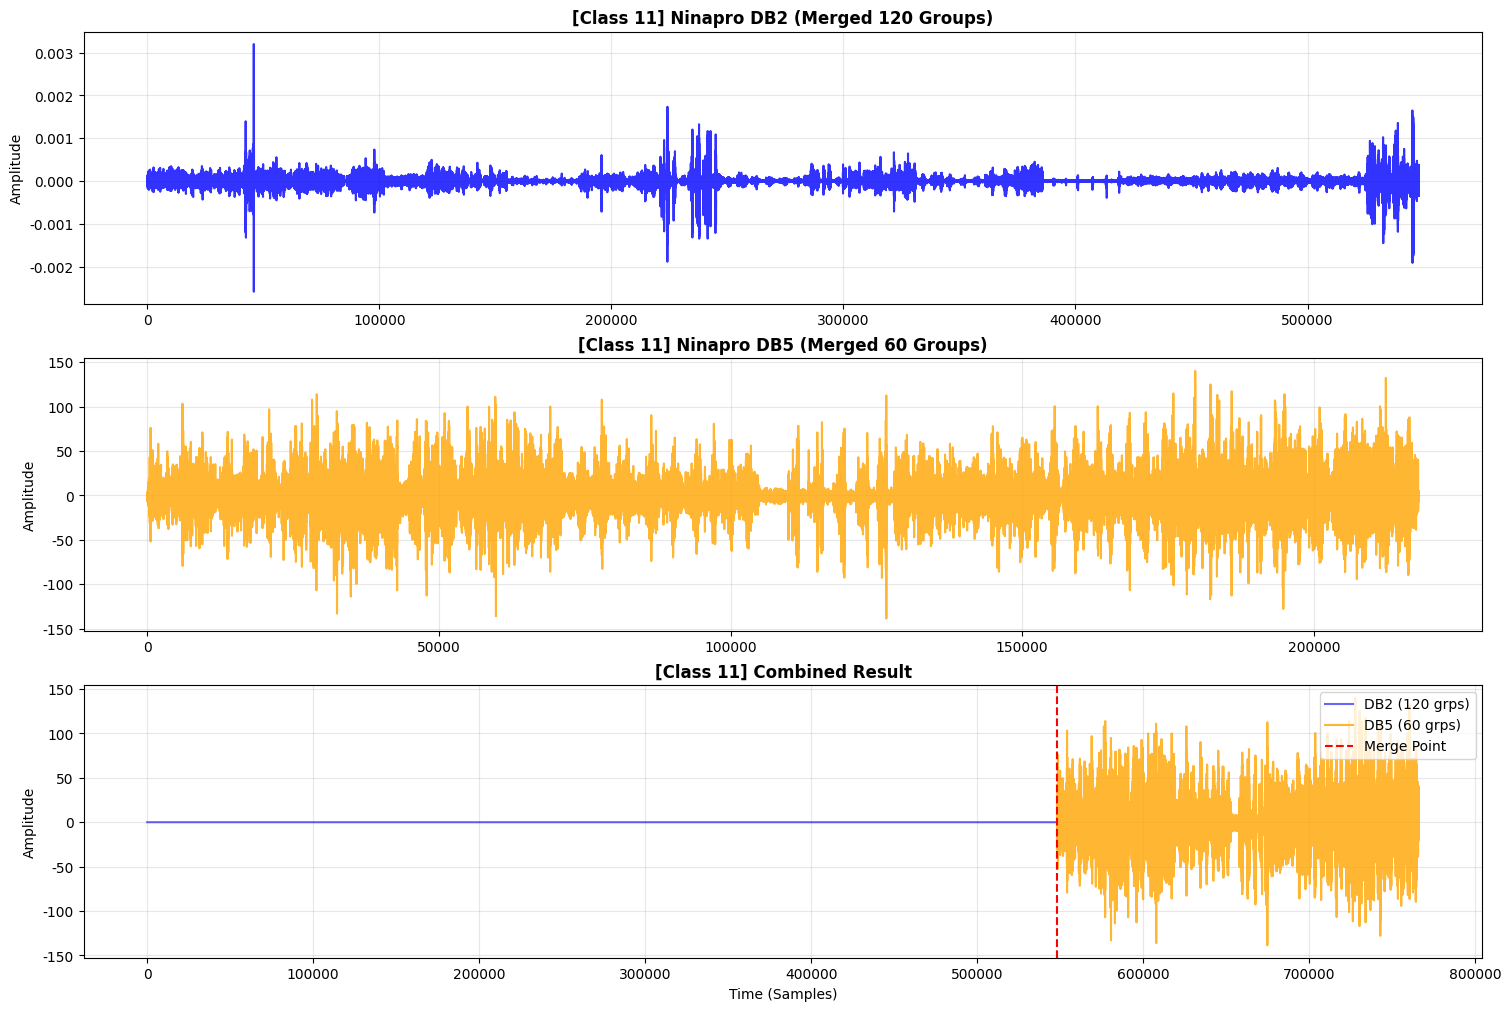

------------------------------------------------------------
Label 12 정보:
  - DB2: 446000 samples (Total 119 Groups merged)
  - DB5: 194000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


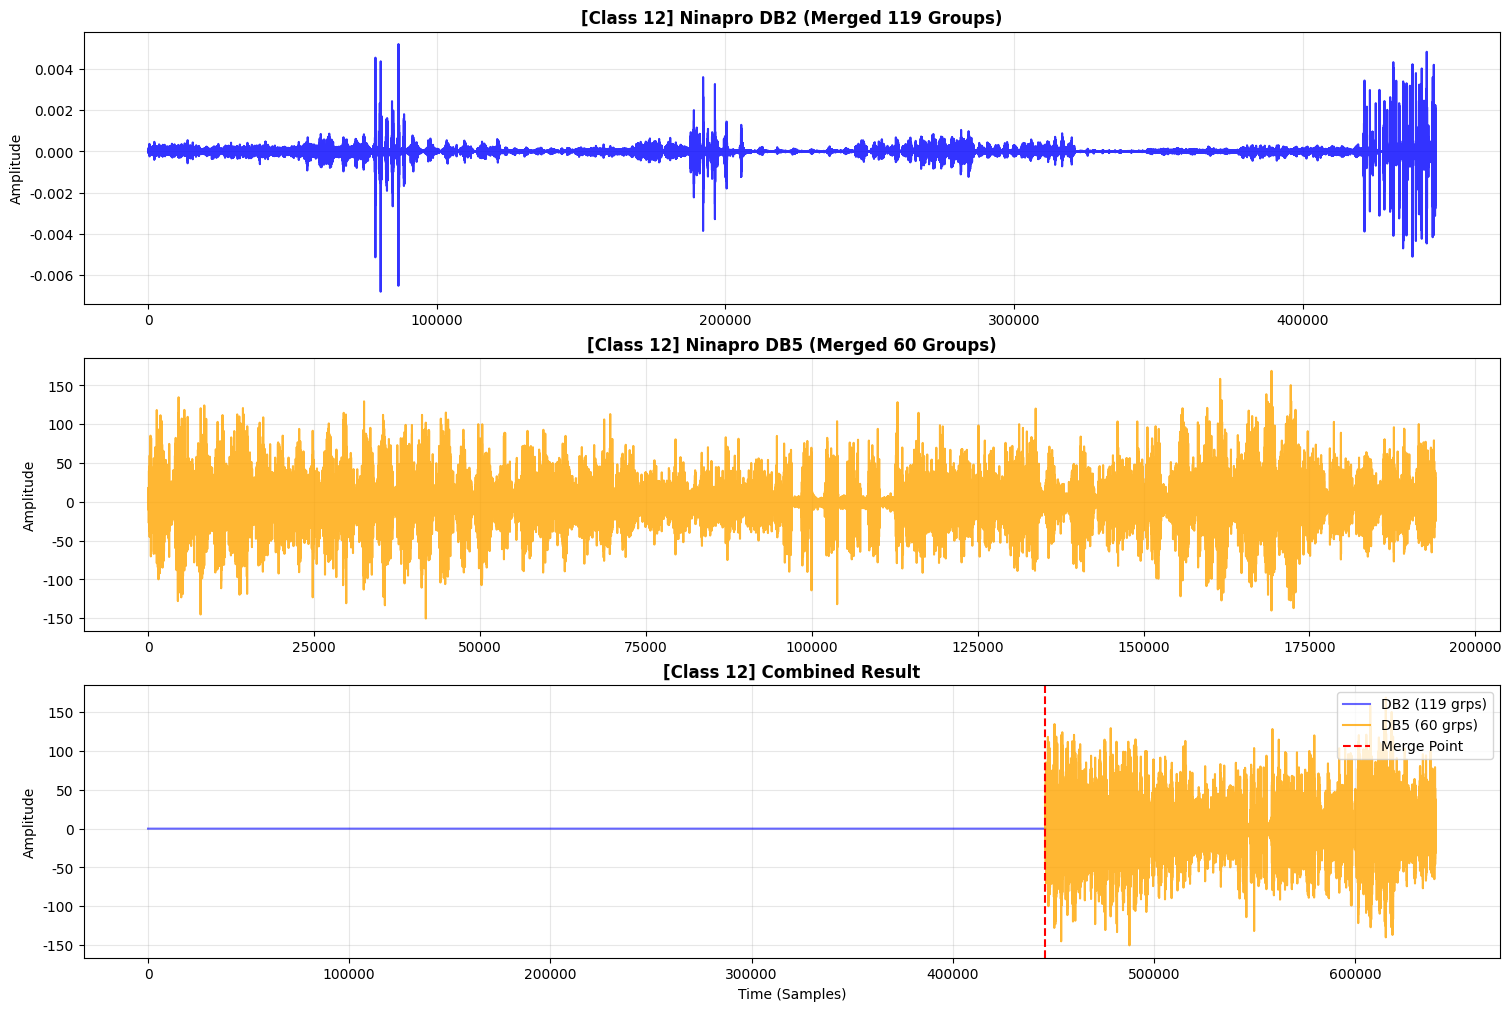

------------------------------------------------------------
Label 13 정보:
  - DB2: 352000 samples (Total 116 Groups merged)
  - DB5: 194000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


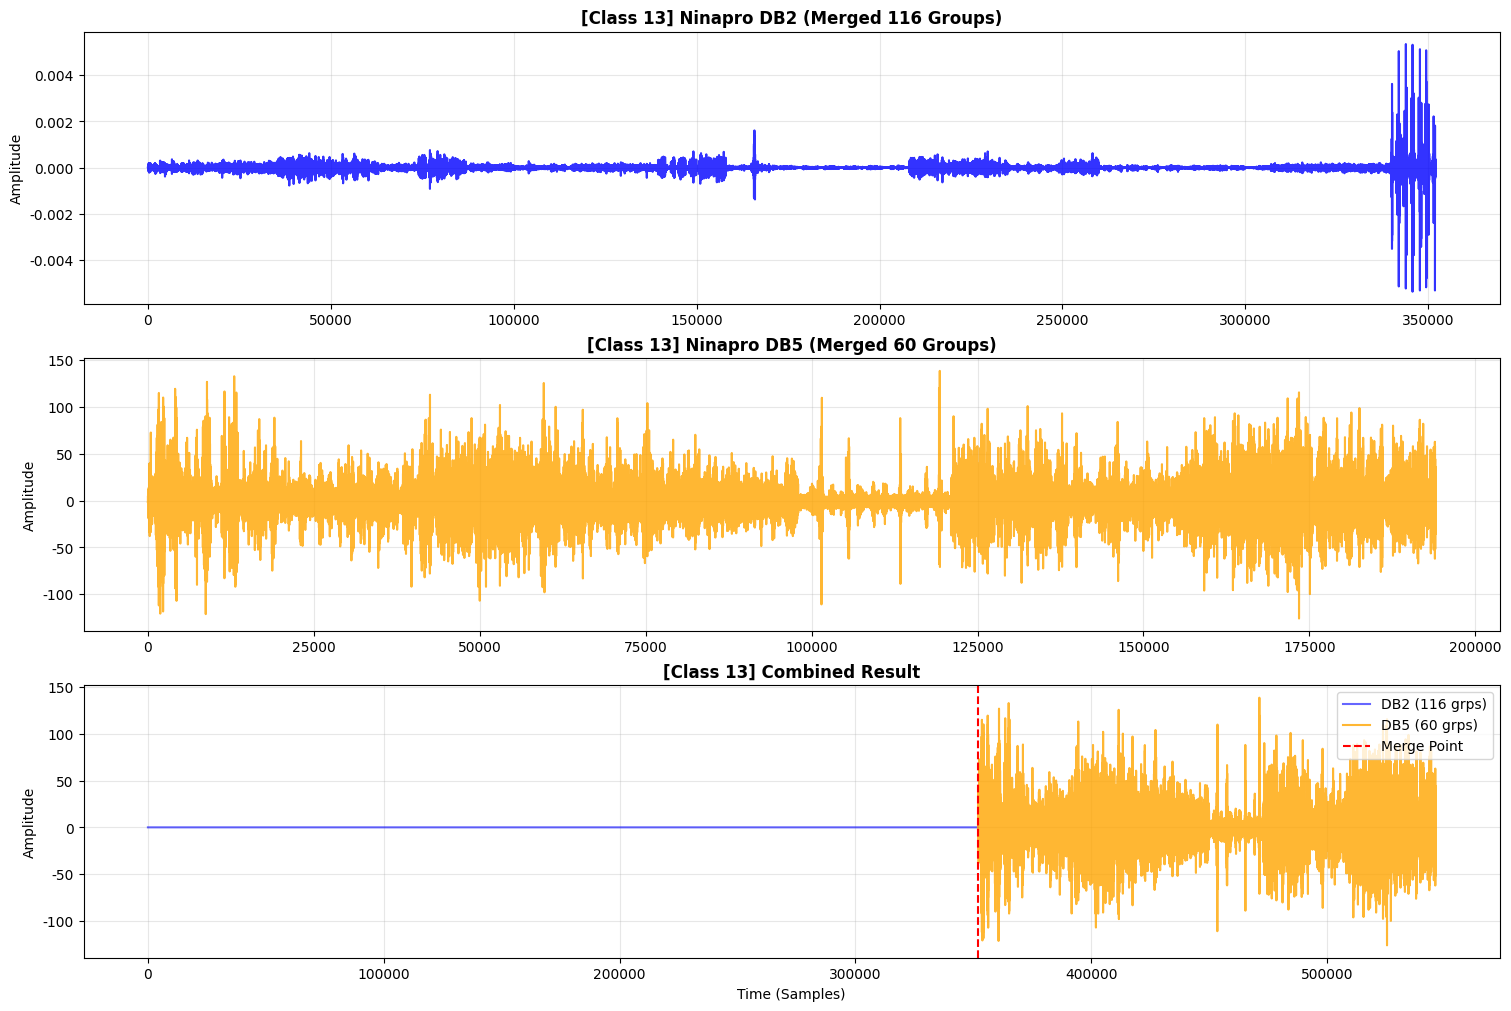

------------------------------------------------------------
Label 14 정보:
  - DB2: 354000 samples (Total 116 Groups merged)
  - DB5: 168000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


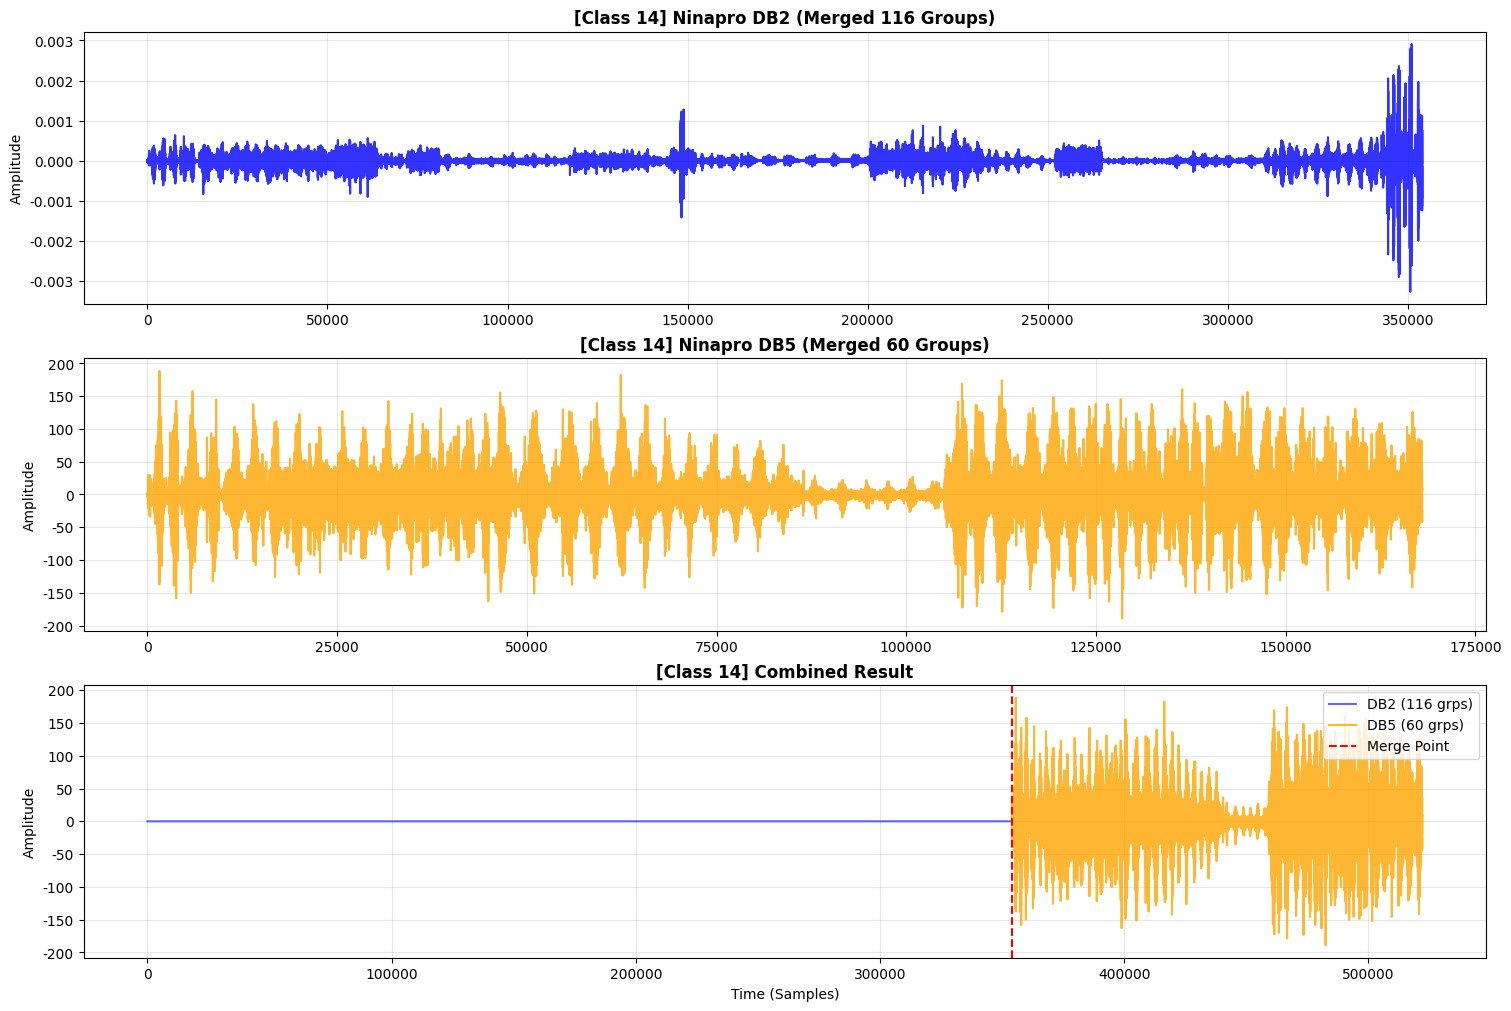

------------------------------------------------------------
Label 15 정보:
  - DB2: 458000 samples (Total 113 Groups merged)
  - DB5: 150000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


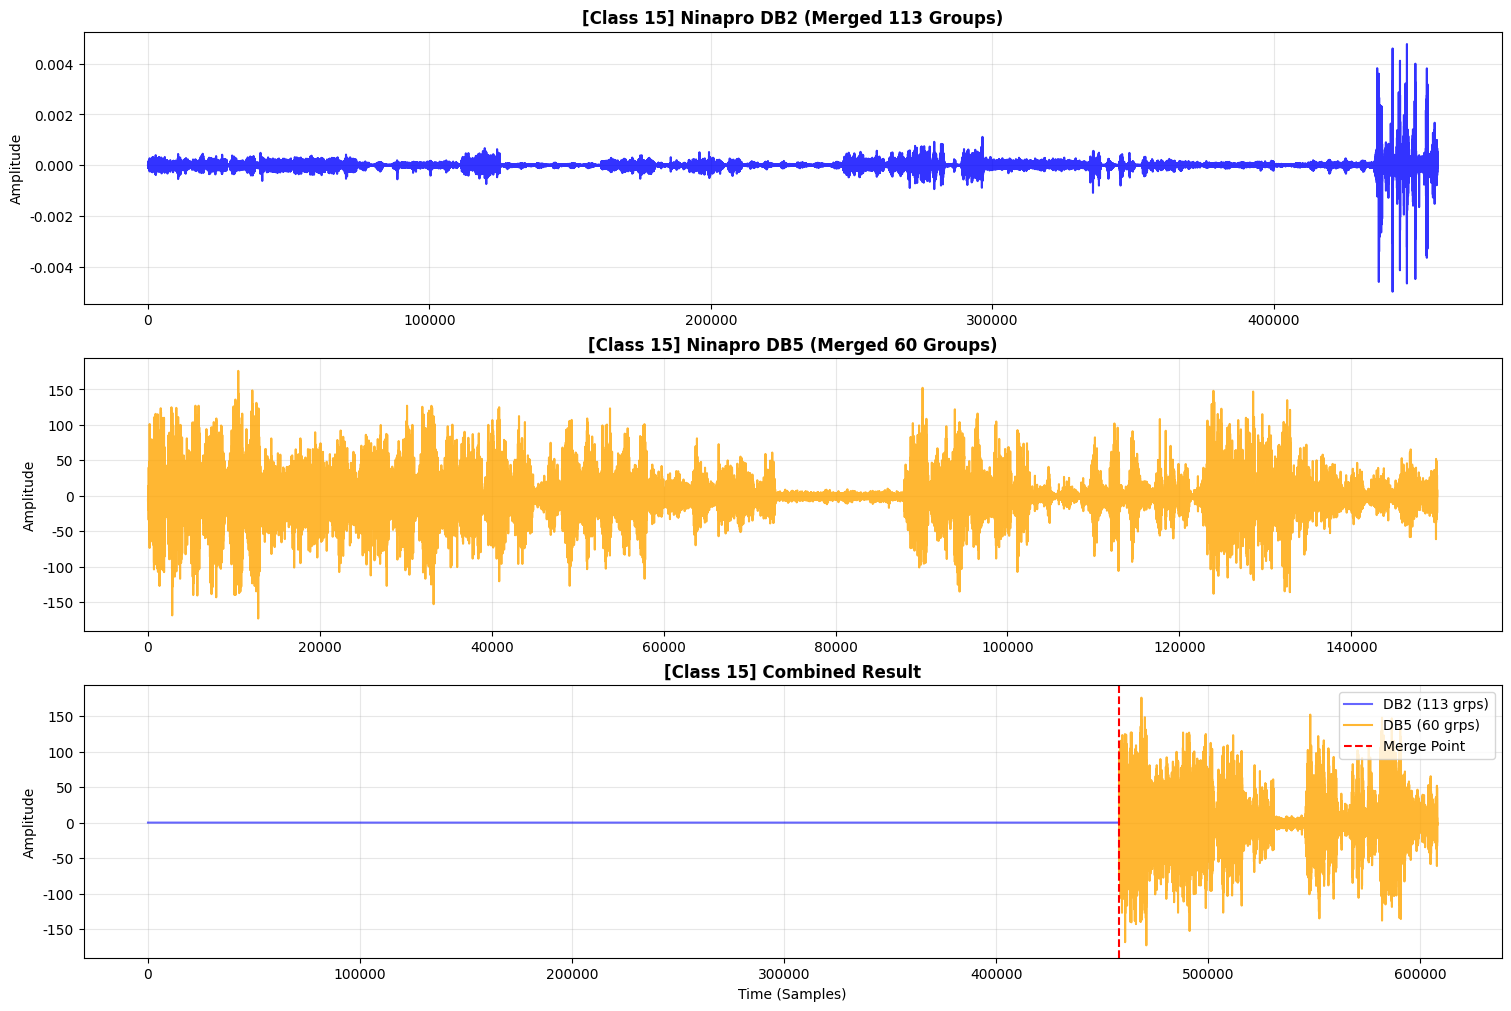

------------------------------------------------------------
Label 16 정보:
  - DB2: 450000 samples (Total 120 Groups merged)
  - DB5: 224000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


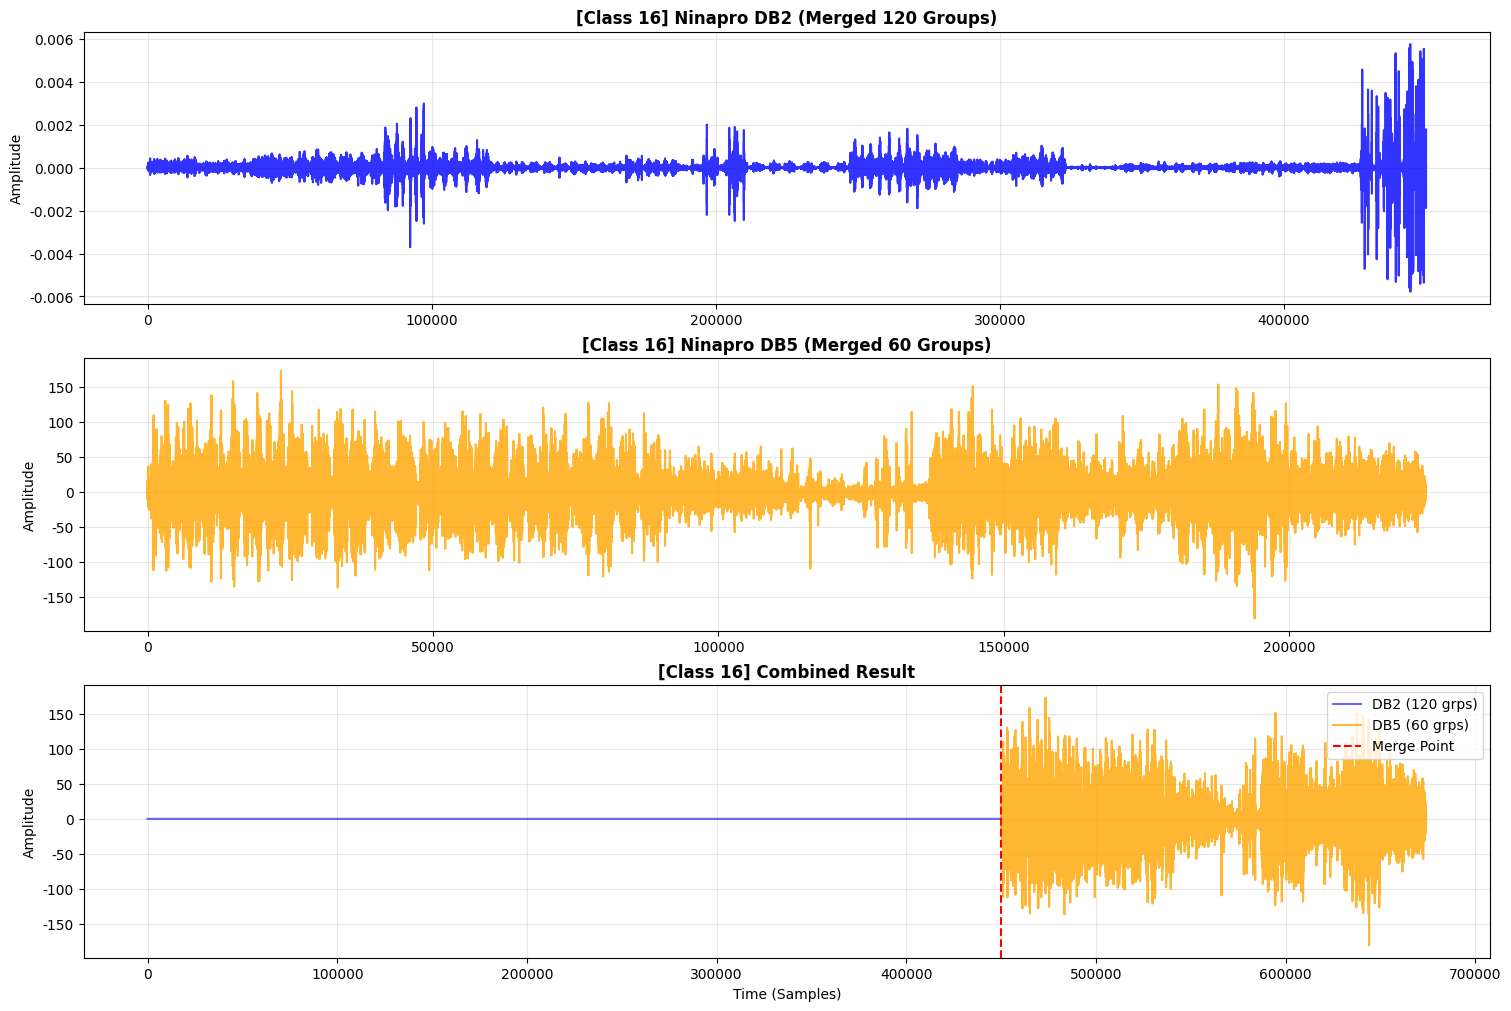

------------------------------------------------------------
Label 17 정보:
  - DB2: 358000 samples (Total 118 Groups merged)
  - DB5: 202000 samples (Total 60 Groups merged)
  >>> 그래프 생성 중...


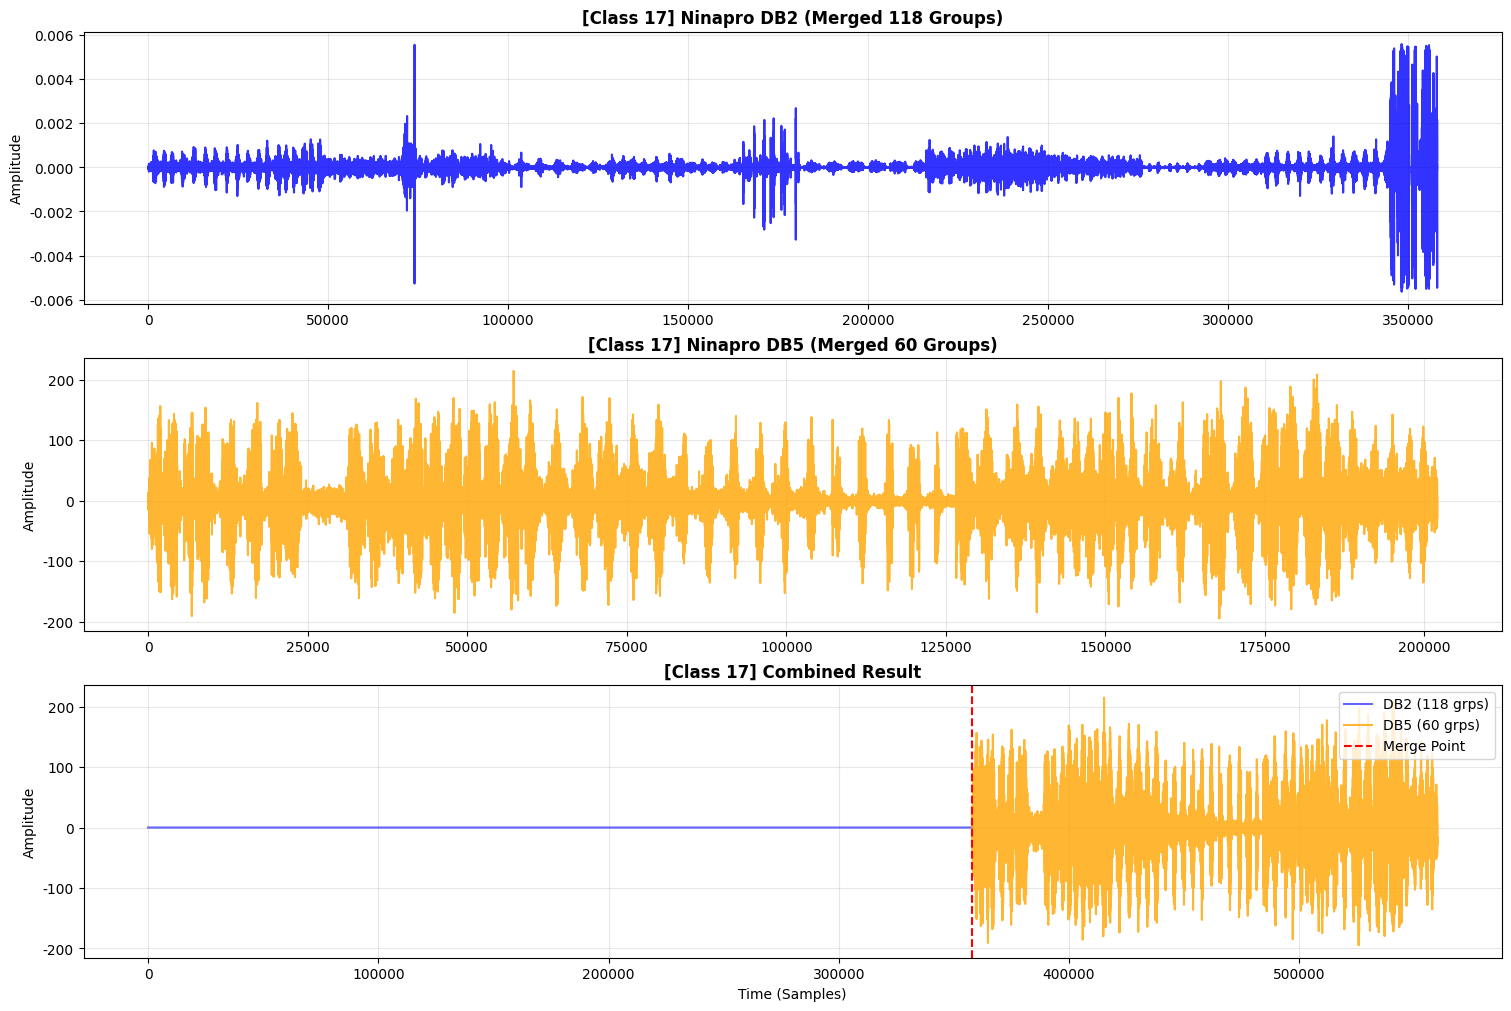

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# [핵심 해결책] 폰트 관련 경고 로그를 차단하고, 폰트를 기본값으로 변경
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# [가정] ninapro_df2, ninapro_df5 데이터프레임이 이미 로드되어 있어야 합니다.

# ==========================================
# 1. 설정
# ==========================================
sensor_idx_to_plot = 0  

if 'ninapro_df2' in locals() and 'ninapro_df5' in locals():
    emg_columns = [col for col in ninapro_df2.columns if col != 'Restimulus']
    target_col_name = emg_columns[sensor_idx_to_plot]

    classes_df2 = set(ninapro_df2['Restimulus'].unique())
    classes_df5 = set(ninapro_df5['Restimulus'].unique())
    all_classes = sorted(list(classes_df2 | classes_df5)) 

    print(f"총 {len(all_classes)}개의 클래스를 발견했습니다: {all_classes}")

    # ==========================================
    # 2. 반복 시각화
    # ==========================================
    for target_class in all_classes:
        
        # --------------------------------------
        # [수정됨] 그룹 수 카운팅 및 데이터 추출
        # --------------------------------------
        # 1. 인덱스를 유지한 상태로 필터링 (원본 위치 확인용)
        raw_df2 = ninapro_df2[ninapro_df2['Restimulus'] == target_class]
        raw_df5 = ninapro_df5[ninapro_df5['Restimulus'] == target_class]
        
        # 2. 그룹 수 계산: 인덱스가 1보다 크게 차이나는 지점(끊긴 지점)의 개수를 셈
        # (데이터가 없으면 0, 있으면 최소 1그룹 + 끊긴 횟수)
        groups_count_2 = 0
        if not raw_df2.empty:
            groups_count_2 = 1 + (raw_df2.index.to_series().diff() > 1).sum()
            
        groups_count_5 = 0
        if not raw_df5.empty:
            groups_count_5 = 1 + (raw_df5.index.to_series().diff() > 1).sum()

        # 3. 그래프용 데이터 준비 (인덱스 초기화)
        df2_subset = raw_df2[target_col_name].reset_index(drop=True)
        df5_subset = raw_df5[target_col_name].reset_index(drop=True)
        
        if df2_subset.empty and df5_subset.empty:
            continue

        # [출력] 데이터 길이 및 합쳐진 그룹 수 정보 출력
        print(f"-" * 60)
        print(f"Label {target_class} 정보:")
        print(f"  - DB2: {len(df2_subset)} samples (Total {groups_count_2} Groups merged)")
        print(f"  - DB5: {len(df5_subset)} samples (Total {groups_count_5} Groups merged)")
        print(f"  >>> 그래프 생성 중...")

        # --------------------------------------
        # 그래프 그리기
        # --------------------------------------
        fig, axes = plt.subplots(3, 1, figsize=(15, 10), constrained_layout=True)
        
        # [1] DB2
        if not df2_subset.empty:
            axes[0].plot(df2_subset, color='blue', alpha=0.8)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Merged {groups_count_2} Groups)', fontsize=12, fontweight='bold')
        else:
            axes[0].text(0.5, 0.5, "No Data in DB2", ha='center', va='center', fontsize=15)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Missing)', fontsize=12, color='red')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)

        # [2] DB5
        if not df5_subset.empty:
            axes[1].plot(df5_subset, color='orange', alpha=0.8)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Merged {groups_count_5} Groups)', fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, "No Data in DB5", ha='center', va='center', fontsize=15)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Missing)', fontsize=12, color='red')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True, alpha=0.3)

        # [3] Merged
        if not df2_subset.empty:
            axes[2].plot(np.arange(len(df2_subset)), df2_subset, color='blue', alpha=0.6, label=f'DB2 ({groups_count_2} grps)')
        
        if not df5_subset.empty:
            start_idx = len(df2_subset)
            axes[2].plot(np.arange(start_idx, start_idx + len(df5_subset)), df5_subset, 
                        color='orange', alpha=0.8, label=f'DB5 ({groups_count_5} grps)')
            if start_idx > 0:
                axes[2].axvline(x=start_idx, color='red', linestyle='--', label='Merge Point')

        axes[2].set_title(f'[Class {target_class}] Combined Result', fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Time (Samples)')
        axes[2].set_ylabel('Amplitude')
        axes[2].legend(loc='upper right')
        axes[2].grid(True, alpha=0.3)

        plt.show() 
else:
    print("오류: 데이터프레임이 정의되지 않았습니다.")

=== 병합 완료 ===
ninapro_df2 크기: (16050000, 17)
ninapro_df5 크기: (9094000, 17)
합쳐진 merged_df 크기: (25144000, 17)


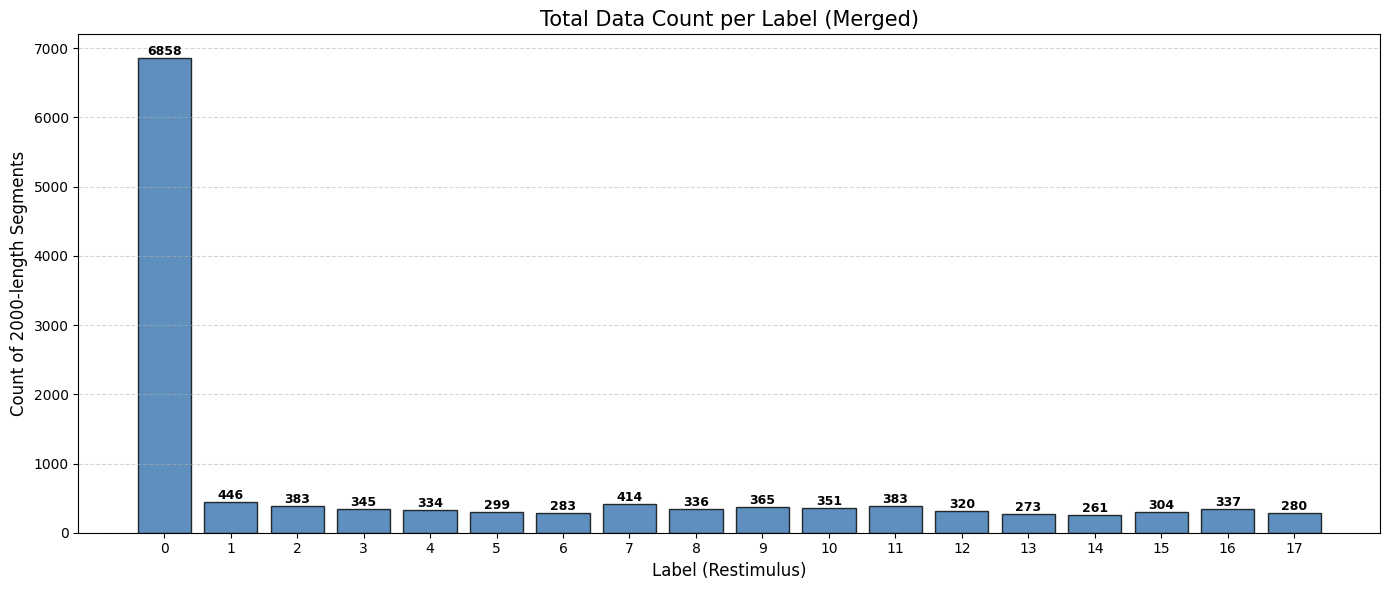


[상세 데이터 개수 (단위: 세트)]
Restimulus
0     6858
1      446
2      383
3      345
4      334
5      299
6      283
7      414
8      336
9      365
10     351
11     383
12     320
13     273
14     261
15     304
16     337
17     280
Name: count, dtype: int64


In [10]:
#데이터 프레임 합치기
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 두 데이터프레임 합치기
# ---------------------------------------------------------
merged_df = pd.concat([ninapro_df2, ninapro_df5], ignore_index=True)

print(f"=== 병합 완료 ===")
print(f"ninapro_df2 크기: {ninapro_df2.shape}")
print(f"ninapro_df5 크기: {ninapro_df5.shape}")
print(f"합쳐진 merged_df 크기: {merged_df.shape}")

# ---------------------------------------------------------
# 2. 라벨별 데이터 개수 계산
# ---------------------------------------------------------
# 전체 행 개수를 셉니다.
row_counts = merged_df['Restimulus'].value_counts().sort_index()

# 우리가 길이를 2000으로 맞췄으므로, 2000으로 나누면 '세트(Trial) 개수'가 됩니다.
segment_counts = row_counts // 2000

# ---------------------------------------------------------
# 3. 그래프 그리기
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

# 막대 그래프 생성
# x축: 라벨(정수형변환), y축: 세트 개수
x_labels = segment_counts.index.astype(int).astype(str)
bars = plt.bar(x_labels, segment_counts.values, color='#3673b0', edgecolor='black', alpha=0.8)

# 막대 위에 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, 
             f'{int(height)}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('Total Data Count per Label (Merged)', fontsize=15)
plt.xlabel('Label (Restimulus)', fontsize=12)
plt.ylabel('Count of 2000-length Segments', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 0번(휴식) 라벨이 압도적으로 많을 수 있으므로 y축 스케일 주의
# 필요하다면 plt.yscale('log') 등을 고려할 수 있음

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 4. 수치로도 출력
# ---------------------------------------------------------
print("\n[상세 데이터 개수 (단위: 세트)]")
print(segment_counts)

처리 전 0번 데이터 길이: 13716000행 (6858 세트)
처리 후 0번 데이터 길이: 800000행 (400 세트)

=== 최종 병합 완료 ===
최종 데이터 크기: (12228000, 17)


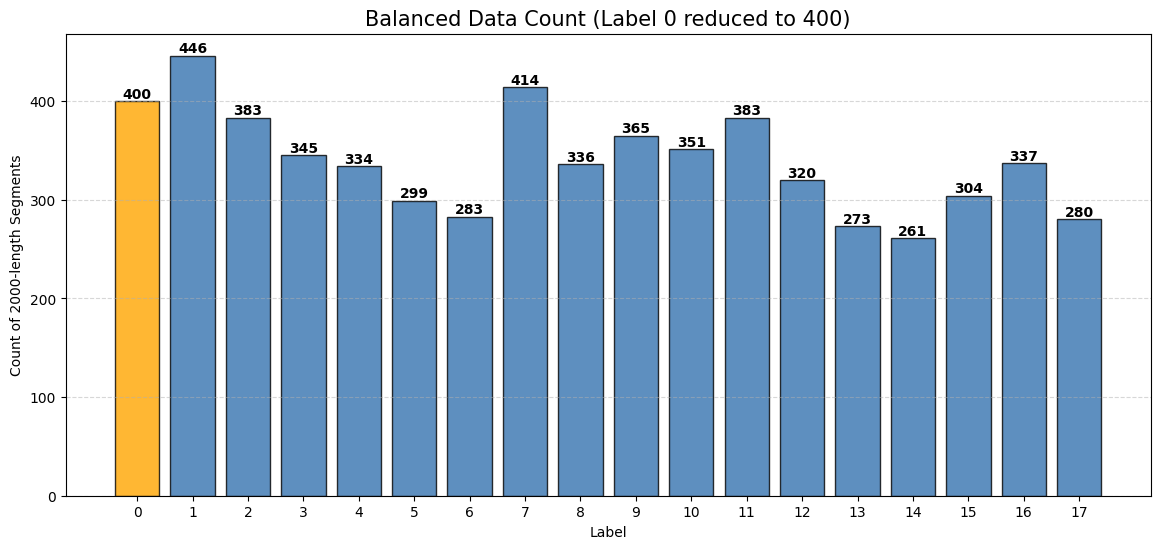

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 설정: 한 세트의 길이와 남길 개수
# ---------------------------------------------------------
ROWS_PER_SET = 2000   # 사용자 코드 기준 1세트 길이
TARGET_SETS_0 = 400   # 0번 라벨을 몇 세트만 남길지 설정

# ---------------------------------------------------------
# 1. 데이터 분리 (0번 vs 나머지)
# ---------------------------------------------------------
df_0 = merged_df[merged_df['Restimulus'] == 0].copy()
df_others = merged_df[merged_df['Restimulus'] != 0].copy()

print(f"처리 전 0번 데이터 길이: {len(df_0)}행 ({len(df_0)//ROWS_PER_SET} 세트)")

# ---------------------------------------------------------
# 2. 0번 데이터 다운샘플링 (세트 단위 유지)
# ---------------------------------------------------------
# (1) 자투리 데이터 제거 (2000으로 딱 나누어 떨어지게 맞춤)
max_rows = (len(df_0) // ROWS_PER_SET) * ROWS_PER_SET
df_0 = df_0.iloc[:max_rows]

# (2) 블록 ID 생성 (0~1999행은 0번 블록, 2000~3999행은 1번 블록...)
# 이렇게 해야 2000개씩 묶어서 다룰 수 있습니다.
num_sets = len(df_0) // ROWS_PER_SET
block_ids = np.repeat(np.arange(num_sets), ROWS_PER_SET)
df_0['block_id'] = block_ids

# (3) 400개 블록 무작위 선택
# replace=False: 중복 없이 뽑기
selected_blocks = np.random.choice(num_sets, TARGET_SETS_0, replace=False)

# (4) 선택된 블록만 남기기
df_0_reduced = df_0[df_0['block_id'].isin(selected_blocks)].copy()
df_0_reduced = df_0_reduced.drop(columns=['block_id']) # 임시 컬럼 삭제

print(f"처리 후 0번 데이터 길이: {len(df_0_reduced)}행 ({len(df_0_reduced)//ROWS_PER_SET} 세트)")

# ---------------------------------------------------------
# 3. 데이터 재병합
# ---------------------------------------------------------
final_df = pd.concat([df_others, df_0_reduced], ignore_index=True)

# (선택사항) 데이터 순서 섞기 (학습을 위해)
# 시계열 덩어리 자체가 깨지는 것은 아니므로 row shuffle을 해도 되지만,
# 안전하게 하려면 이 단계에서는 섞지 않고 나중에 모델에 넣기 직전에 섞는 것이 좋습니다.
# final_df = final_df.sample(frac=1).reset_index(drop=True) 

print(f"\n=== 최종 병합 완료 ===")
print(f"최종 데이터 크기: {final_df.shape}")

# ---------------------------------------------------------
# 4. 결과 검증 (그래프)
# ---------------------------------------------------------
# 개수 다시 계산
final_counts = final_df['Restimulus'].value_counts().sort_index() // ROWS_PER_SET

plt.figure(figsize=(14, 6))
x_labels = final_counts.index.astype(int).astype(str)
bars = plt.bar(x_labels, final_counts.values, color='#3673b0', edgecolor='black', alpha=0.8)

# 0번만 색깔 다르게 표시
bars[0].set_color('orange')
bars[0].set_edgecolor('black')

# 숫자 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, 
             f'{int(height)}', 
             ha='center', va='bottom', fontweight='bold')

plt.title(f'Balanced Data Count (Label 0 reduced to {TARGET_SETS_0})', fontsize=15)
plt.xlabel('Label')
plt.ylabel(f'Count of {ROWS_PER_SET}-length Segments')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 기존 변수에 덮어쓰기 (원할 경우 주석 해제)
# merged_df = final_df

정규화 대상 컬럼 수: 16개
✅ Z-score 정규화 완료!
       emg1      emg2      emg3      emg4      emg5      emg6      emg7  \
0  0.025366  0.027103  0.042651  0.062941  0.030927  0.026728  0.029730   
1  0.025366  0.027103  0.042651  0.062941  0.030927  0.026727  0.029730   
2  0.025366  0.027103  0.042651  0.062940  0.030927  0.026728  0.029730   
3  0.025366  0.027103  0.042651  0.062939  0.030927  0.026727  0.029729   
4  0.025366  0.027103  0.042651  0.062940  0.030927  0.026727  0.029729   

       emg8      emg9     emg10     emg11     emg12     emg13     emg14  \
0  0.028118  0.025417  0.025344  0.045526  0.043126  0.021615  0.028682   
1  0.028119  0.025417  0.025344  0.045526  0.043125  0.021615  0.028682   
2  0.028120  0.025416  0.025344  0.045525  0.043126  0.021615  0.028682   
3  0.028120  0.025417  0.025345  0.045525  0.043128  0.021615  0.028682   
4  0.028120  0.025416  0.025344  0.045525  0.043128  0.021615  0.028682   

      emg15     emg16  Restimulus  
0  0.035106  0.029982      

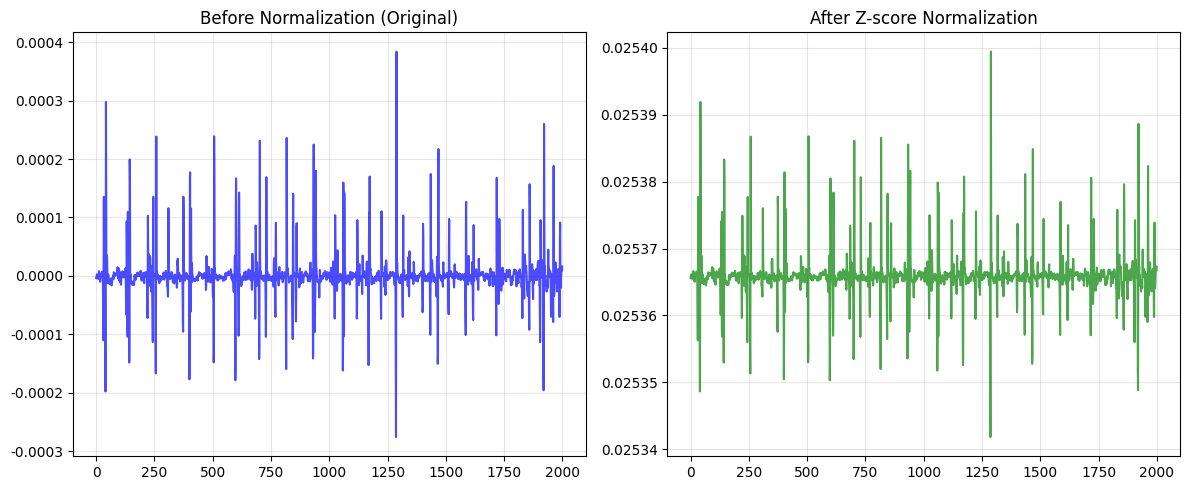

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---------------------------------------------------------
# 1. [핵심 수정] 데이터셋별 "개별 정규화" 수행
# ---------------------------------------------------------
print("=== 1. 데이터셋별 개별 정규화 (Scale Matching) ===")

def scale_features_only(df):
    """라벨(Restimulus)은 건드리지 않고, 센서 데이터만 정규화합니다."""
    # 데이터 분리
    features = df.iloc[:, :-1].values # 마지막 컬럼 제외
    labels = df.iloc[:, -1].values    # 마지막 컬럼 (라벨)
    
    # 정규화 (평균 0, 표준편차 1로 변환)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # 다시 합치기
    df_scaled = pd.DataFrame(features_scaled, columns=df.columns[:-1])
    df_scaled['Restimulus'] = labels
    return df_scaled

# DB2와 DB5를 각각 정규화하여 0.01과 257의 차이를 없앱니다.
print("DB2 정규화 중...")
ninapro_df2_scaled = scale_features_only(ninapro_df2)
print("DB5 정규화 중...")
ninapro_df5_scaled = scale_features_only(ninapro_df5)

print("✅ 개별 정규화 완료! 이제 두 데이터의 스케일이 같습니다.")

# ---------------------------------------------------------
# 2. 3D 변환 및 병합
# ---------------------------------------------------------
print("\n=== 2. 3D 변환 및 병합 (TIME_STEPS=50) ===")
TIME_STEPS = 50  # 200Hz 기준 0.25초

def create_3d_dataset(df, time_steps):
    # 자투리 제거
    cutoff = (len(df) // time_steps) * time_steps
    df = df.iloc[:cutoff]
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    n_samples = len(X) // time_steps
    
    # (샘플 수, 시간, 센서)
    X_3d = X.reshape(n_samples, time_steps, X.shape[1])
    # 라벨 (윈도우의 첫 번째 값 사용)
    y_sampled = y[::time_steps]
    
    return X_3d, y_sampled

# 변환
X_db2, y_db2 = create_3d_dataset(ninapro_df2_scaled, TIME_STEPS)
X_db5, y_db5 = create_3d_dataset(ninapro_df5_scaled, TIME_STEPS)

# 병합
X_final = np.concatenate([X_db2, X_db5], axis=0)
y_final = np.concatenate([y_db2, y_db5], axis=0)

print(f"최종 데이터 Shape: {X_final.shape}")

# ---------------------------------------------------------
# 3. 데이터 분할 (Train/Val/Test)
# ---------------------------------------------------------
print("\n=== 3. 데이터 분할 ===")
y_onehot = to_categorical(y_final)

# 1차 분할: Train+Val (80%) / Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_final, y_onehot, test_size=0.2, random_state=42, stratify=y_final
)

# 2차 분할: Train (80%) / Val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1)
)

print(f"✅ 최종 학습 데이터 준비 완료")
print(f"Train: {X_train.shape}")
print(f"Val  : {X_val.shape}")
print(f"Test : {X_test.shape}")

In [13]:
import numpy as np

print("=== 🔍 데이터 스케일(단위) 불일치 진단 ===")

# DB2 통계 (Raw Data)
# feature 컬럼만 선택 (마지막 Restimulus 제외)
db2_feats = ninapro_df2.iloc[:, :-1].values 
print(f"[DB2] 평균: {np.mean(db2_feats):.4f}, 최대값: {np.max(db2_feats):.4f}")

# DB5 통계 (Raw Data)
db5_feats = ninapro_df5.iloc[:, :-1].values
print(f"[DB5] 평균: {np.mean(db5_feats):.4f}, 최대값: {np.max(db5_feats):.4f}")

# 스케일 비율 계산
ratio = np.mean(np.abs(db2_feats)) / np.mean(np.abs(db5_feats))
print(f"\n👉 스케일 차이: DB2가 DB5보다 약 {ratio:.1f}배 더 큽니다.")

if ratio > 10:
    print("🚨 [결론] 스케일이 너무 다릅니다! 합치기 전에 각각 정규화를 해야 합니다.")
else:
    print("✅ [결론] 스케일이 비슷합니다. 다른 원인을 찾아봐야 합니다.")

=== 🔍 데이터 스케일(단위) 불일치 진단 ===
[DB2] 평균: 0.0000, 최대값: 0.0104
[DB5] 평균: -0.9573, 최대값: 257.6636

👉 스케일 차이: DB2가 DB5보다 약 0.0배 더 큽니다.
✅ [결론] 스케일이 비슷합니다. 다른 원인을 찾아봐야 합니다.


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---------------------------------------------------------
# 1. 각각 따로 정규화 (Scale Matching)
# ---------------------------------------------------------
print("=== 1. 데이터셋별 개별 정규화 수행 ===")

def scale_dataframe(df):
    # 라벨 제외하고 스케일링
    feats = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values
    
    scaler = StandardScaler()
    feats_scaled = scaler.fit_transform(feats)
    
    # 다시 DataFrame으로 복구
    df_scaled = pd.DataFrame(feats_scaled, columns=df.columns[:-1])
    df_scaled['Restimulus'] = labels
    return df_scaled

# DB2와 DB5를 각각 정규화하여 '체급'을 통일시킵니다.
ninapro_df2_scaled = scale_dataframe(ninapro_df2)
ninapro_df5_scaled = scale_dataframe(ninapro_df5)

print("✅ 개별 정규화 완료.")

# ---------------------------------------------------------
# 2. 3D 변환 및 병합 (이전 로직과 동일)
# ---------------------------------------------------------
print("=== 2. 3D 변환 및 병합 ===")
TIME_STEPS = 50

def create_3d_dataset(df, time_steps):
    cutoff = (len(df) // time_steps) * time_steps
    df = df.iloc[:cutoff]
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    n_samples = len(X) // time_steps
    X_3d = X.reshape(n_samples, time_steps, X.shape[1])
    y_sampled = y[::time_steps]
    return X_3d, y_sampled

X_db2, y_db2 = create_3d_dataset(ninapro_df2_scaled, TIME_STEPS)
X_db5, y_db5 = create_3d_dataset(ninapro_df5_scaled, TIME_STEPS)

# 병합
X_final = np.concatenate([X_db2, X_db5], axis=0)
y_final = np.concatenate([y_db2, y_db5], axis=0)

print(f"최종 데이터: {X_final.shape}")

# ---------------------------------------------------------
# 3. 데이터 분할 (Train/Val/Test)
# ---------------------------------------------------------
print("=== 3. 데이터 분할 ===")
y_onehot = to_categorical(y_final)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_final, y_onehot, test_size=0.2, random_state=42, stratify=y_final
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1)
)

print(f"✅ 최종 준비 완료. X_train: {X_train.shape}")
print("이제 학습을 시작하면 '죽은 신호' 없이 잘 될 것입니다.")

설정된 윈도우 길이(Time Steps): 50
변환 전 2D 형태: (12228000, 16)
변환 후 입력(X) 형태: (244560, 50, 16)
변환 후 라벨(y) 형태: (244560, 18)

✅ 데이터 준비 완료
학습 데이터(X_train): (195648, 50, 16)
테스트 데이터(X_test): (48912, 50, 16)
클래스 개수: 18


In [ ]:
import numpy as np

print("=== 🔍 데이터 스케일(단위) 불일치 진단 ===")

# DB2 통계 (Raw Data)
# feature 컬럼만 선택 (마지막 Restimulus 제외)
db2_feats = ninapro_df2.iloc[:, :-1].values 
print(f"[DB2] 평균: {np.mean(db2_feats):.4f}, 최대값: {np.max(db2_feats):.4f}")

# DB5 통계 (Raw Data)
db5_feats = ninapro_df5.iloc[:, :-1].values
print(f"[DB5] 평균: {np.mean(db5_feats):.4f}, 최대값: {np.max(db5_feats):.4f}")

# 스케일 비율 계산
ratio = np.mean(np.abs(db2_feats)) / np.mean(np.abs(db5_feats))
print(f"\n👉 스케일 차이: DB2가 DB5보다 약 {ratio:.1f}배 더 큽니다.")

if ratio > 10:
    print("🚨 [결론] 스케일이 너무 다릅니다! 합치기 전에 각각 정규화를 해야 합니다.")
else:
    print("✅ [결론] 스케일이 비슷합니다. 다른 원인을 찾아봐야 합니다.")

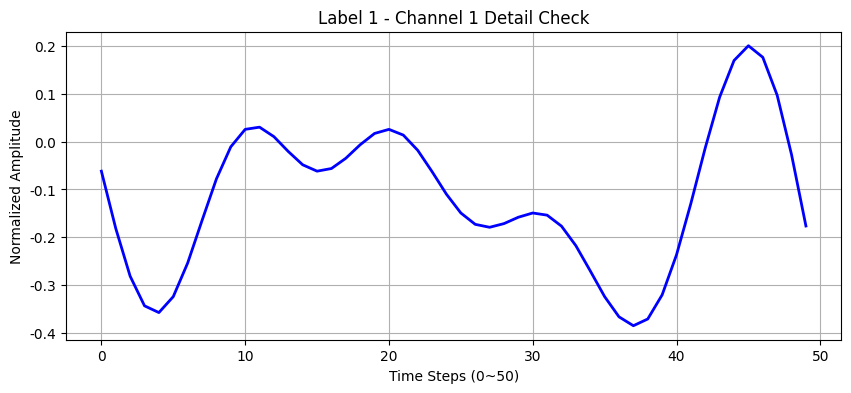

데이터 통계: Max=1.57, Min=-1.83
✅ [정상] 신호의 변동폭이 충분합니다. CNN이 특징을 잡을 수 있습니다.


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 동작 라벨 중 하나 선택 (예: 라벨 1)
target_label = 1
indices = np.where(np.argmax(y_train, axis=1) == target_label)[0]

if len(indices) > 0:
    idx = indices[0] # 첫 번째 샘플
    data = X_train[idx] # (50, 16)

    plt.figure(figsize=(10, 4))
    
    # 16개 중 가장 첫 번째 센서(Channel 0)만 그리기
    plt.plot(data[:, 0], color='blue', linewidth=2)
    
    plt.title(f"Label {target_label} - Channel 1 Detail Check")
    plt.xlabel("Time Steps (0~50)")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)
    plt.show()
    
    print(f"데이터 통계: Max={np.max(data):.2f}, Min={np.min(data):.2f}")
    
    if np.max(data) - np.min(data) < 0.1:
        print("⚠️ [위험] 신호가 너무 약합니다 (Flat). 학습 불가 가능성 높음.")
    else:
        print("✅ [정상] 신호의 변동폭이 충분합니다. CNN이 특징을 잡을 수 있습니다.")
else:
    print("해당 라벨의 데이터가 없습니다.")

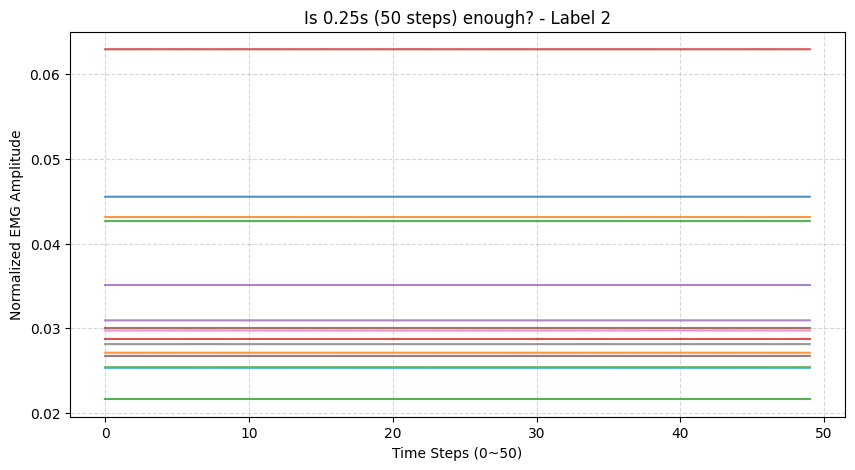

보시다시피 50개 step 안에서도 신호는 수없이 오르내리는 '패턴'을 가지고 있습니다.
CNN은 이 패턴을 이미지처럼 인식하여 분류합니다.


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 동작 라벨(0이 아닌 것) 중 무작위 하나 선택
active_indices = np.where(np.argmax(y_train, axis=1) != 0)[0]
idx = active_indices[8] # 첫 번째 데이터

data = X_train[idx] # (50, 16)

plt.figure(figsize=(10, 5))
plt.plot(data, linewidth=1.5, alpha=0.8) # 16개 채널 겹쳐 그리기
plt.title(f"Is 0.25s (50 steps) enough? - Label {np.argmax(y_train[idx])}")
plt.xlabel("Time Steps (0~50)")
plt.ylabel("Normalized EMG Amplitude")
plt.grid(True, linestyle='--', alpha=0.5)

# 0.25초 동안의 신호 변동폭(Texture) 확인
plt.show()

print("보시다시피 50개 step 안에서도 신호는 수없이 오르내리는 '패턴'을 가지고 있습니다.")
print("CNN은 이 패턴을 이미지처럼 인식하여 분류합니다.")

In [17]:
import numpy as np

# 확인하셨던 그 인덱스 (8번, 4번 등...)
idx = active_indices[8] 
signal = X_train[idx]

# 신호의 최대값과 최소값 차이 (진폭) 계산
peak_to_peak = np.max(signal) - np.min(signal)
std_dev = np.std(signal)

print(f"=== 신호 정밀 진단 (Index {idx}) ===")
print(f"1. 신호 진폭 (Peak-to-Peak): {peak_to_peak:.4f}")
print(f"2. 표준편차 (Activity): {std_dev:.4f}")

print("\n[판정 결과]")
# 정규화된 데이터 기준, 진폭이 1.0 이상이면 확실한 활성 신호입니다.
if peak_to_peak > 1.0:
    print("✅ [정상] 아주 건강한 신호입니다.")
    print("   (그래프가 지저분해 보이는 건 근육이 열심히 일하고 있다는 증거입니다.)")
elif peak_to_peak > 0.1:
    print("⚠️ [주의] 신호가 좀 약하지만, 학습은 가능합니다.")
else:
    print("❌ [위험] 신호가 죽었습니다 (Flat). 전처리를 다시 확인해야 합니다.")

=== 신호 정밀 진단 (Index 8) ===
1. 신호 진폭 (Peak-to-Peak): 0.0413
2. 표준편차 (Activity): 0.0103

[판정 결과]
❌ [위험] 신호가 죽었습니다 (Flat). 전처리를 다시 확인해야 합니다.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # === [CNN Part] 특징 추출 및 차원 축소 ===
    model.add(Input(shape=input_shape))
    
    # 1st Conv Block: 세밀한 패턴 감지
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4)) # 길이 1/4로 축소
    model.add(Dropout(0.3))

    # 2nd Conv Block: 중간 특징 추출
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4)) # 또 1/4로 축소 (총 1/16)
    model.add(Dropout(0.3))

    # 3rd Conv Block: 추상적 특징 추출
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2)) # 1/2로 축소 (총 1/32)
    model.add(Dropout(0.3))
    
    # (참고) 입력이 2000이라면, 여기까지 오면 길이는 약 62 (2000 / 32)가 됩니다.
    # LSTM이 처리하기 딱 좋은 길이가 됩니다.

    # === [LSTM Part] 시계열 패턴 학습 ===
    # Bidirectional을 사용하여 과거와 미래 정보를 동시에 활용
    model.add(Bidirectional(LSTM(128, return_sequences=False))) 
    model.add(Dropout(0.4))

    # === [Classifier Part] 분류 ===
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # 모델 컴파일
    optimizer = Adam(learning_rate=0.0005) # LSTM은 학습률을 조금 낮추는 게 안정적임
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    return model

# ---------------------------------------------------------
# 모델 생성 및 확인
# ---------------------------------------------------------
# X_train의 형태에 맞춰 자동으로 입력 크기 설정
# 예: (2000, 16) 또는 (400, 16) 등 현재 데이터에 맞게 적용됨
input_shape = (X_train.shape[1], X_train.shape[2]) 
num_classes = y_train.shape[1]

print(f"🔹 입력 형태: {input_shape}")
print(f"🔹 클래스 수: {num_classes}")

model = build_cnn_lstm_model(input_shape, num_classes)
model.summary()

🔹 입력 형태: (50, 16)
🔹 클래스 수: 18


2026-01-08 19:27:28.115653: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-08 19:27:28.115717: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2026-01-08 19:27:28.115741: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2026-01-08 19:27:28.115789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-08 19:27:28.115809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 64)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 559,698 (2.14 MB)

 Trainable params: 558,802 (2.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,             # 7번 참음
    restore_best_weights=True, 
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,             # 학습률 절반으로 뚝
    patience=3,             # 3번 참음
    min_lr=1e-6, 
    verbose=1
)

# 2. 학습 시작
print("\n🚀 CNN-LSTM 모델 학습 시작...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), # 이전 단계에서 분리한 Val/Test 데이터 사용 권장
    epochs=50,
    batch_size=64,          # 메모리 부족 시 32로 줄이세요
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


🚀 CNN-LSTM 모델 학습 시작...
Epoch 1/50


2026-01-08 19:27:29.478375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 300/3057 ━━━━━━━━━━━━━━━━━━━━ 2:17 50ms/step - accuracy: 0.0753 - loss: 2.9284

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # 1. 값 추출
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # 2. 그래프 그리기 (1행 2열)
    plt.figure(figsize=(14, 5))
    
    # (1) 정확도(Accuracy) 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # (2) 손실(Loss) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 사용법: model.fit()의 결과인 history 변수를 넣어주세요
if 'history' in locals():
    plot_training_history(history)
else:
    print("history 변수가 없습니다. 모델 학습을 먼저 실행해주세요.")